<a href="https://colab.research.google.com/github/tetiana-zhuchenko/ver_2_Restaurant_Analysis_Diploma/blob/main/ver_2_Restaurant_Analysis_Diploma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Setup код проекту з модулями та файлами

In [ ]:
# ============================================================================
# КРОК 1: СТВОРЕННЯ СТРУКТУРИ ФАЙЛІВ В COLAB
# ============================================================================

print("🚀 Створення структури проекту в Google Colab")
print("=" * 60)

# Створення директорій для проекту
import os
import sys
from pathlib import Path

# Створюємо структуру папок
project_dirs = [
    'restaurant_analysis',
    'restaurant_analysis/data',
    'restaurant_analysis/plots',
    'restaurant_analysis/logs',
    'restaurant_analysis/configs',
    'restaurant_analysis/modules'
]

for dir_path in project_dirs:
    os.makedirs(dir_path, exist_ok=True)
    print(f"📁 Створено: {dir_path}")

# Додаємо шлях до нашого проекту в sys.path
sys.path.append('/content/restaurant_analysis')

print("\n✅ Структура проекту створена!")

# ============================================================================
# КРОК 2: СТВОРЕННЯ МОДУЛЯ КОНФІГУРАЦІЇ
# ============================================================================

config_module = '''
"""
Модуль конфігурації для системи аналізу відгуків ресторанів
"""

import json
import logging
from datetime import datetime

class Config:
    """Конфігураційний клас для налаштувань системи"""

    def __init__(self):
        self.config = {
            # Дані
            "data": {
                "url": "https://raw.githubusercontent.com/tetiana-zhuchenko/dataset-restaurant-reviewss/main/reviews-uK-lang.csv",
                "delimiter": ",",
                "encoding": "utf-8",
                "test_size": 0.2,
                "random_state": 42
            },

            # Препроцесинг
            "preprocessing": {
                "text_column": "Review",
                "target_column": "Liked",
                "language": "uk",
                "max_features": 5000,
                "ngram_range": (1, 2),
                "remove_stopwords": True,
                "lowercase": True,
                "remove_special_chars": True
            },

            # Візуалізація
            "visualization": {
                "figure_size": (12, 8),
                "style": "seaborn-v0_8",
                "palette": "husl",
                "dpi": 100,
                "save_plots": True,
                "plots_dir": "/content/restaurant_analysis/plots"
            },

            # Машинне навчання
            "ml": {
                "algorithms": [
                    "LogisticRegression",
                    "MultinomialNB",
                    "SVC",
                    "RandomForest",
                    "DecisionTree"
                ],
                "cv_folds": 5,
                "scoring": "f1_weighted",
                "grid_search": True
            },

            # Логування
            "logging": {
                "level": "INFO",
                "format": "%(asctime)s - %(name)s - %(levelname)s - %(message)s",
                "file": "/content/restaurant_analysis/logs/analysis.log",
                "console": True
            }
        }

    def get(self, key_path, default=None):
        """Отримання значення за шляхом ключа з підтримкою значення за замовчуванням"""
        keys = key_path.split('.')
        value = self.config
        for key in keys:
            value = value.get(key, None)
            if value is None:
                return default
        return value

    def set(self, key_path, value):
        """Встановлення значення за шляхом ключа"""
        keys = key_path.split('.')
        config = self.config
        for key in keys[:-1]:
            config = config.setdefault(key, {})
        config[keys[-1]] = value

    def save_config(self, filepath=None):
        """Збереження конфігурації у файл"""
        if filepath is None:
            filepath = "/content/restaurant_analysis/configs/config.json"

        with open(filepath, 'w', encoding='utf-8') as f:
            json.dump(self.config, f, indent=4, ensure_ascii=False)
        print(f"💾 Конфігурація збережена: {filepath}")

    def load_config(self, filepath=None):
        """Завантаження конфігурації з файлу"""
        if filepath is None:
            filepath = "/content/restaurant_analysis/configs/config.json"

        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                self.config = json.load(f)
            print(f"📥 Конфігурація завантажена: {filepath}")
        except FileNotFoundError:
            print(f"⚠️ Файл {filepath} не знайдено. Використовуються стандартні налаштування.")
'''

# Записуємо модуль конфігурації у файл
with open('/content/restaurant_analysis/modules/config.py', 'w', encoding='utf-8') as f:
    f.write(config_module)

print("✅ Модуль config.py створено")

# ============================================================================
# КРОК 3: СТВОРЕННЯ МОДУЛЯ ЛОГУВАННЯ
# ============================================================================

logger_module = '''
"""
Модуль логування для системи аналізу відгуків ресторанів
"""

import logging
import os
from pathlib import Path

class Logger:
    """Клас для налаштування та управління логуванням"""

    def __init__(self, config):
        self.config = config
        self.logger = None
        self.setup_logger()

    def setup_logger(self):
        """Налаштування логера"""
        # Створення логера
        self.logger = logging.getLogger('RestaurantAnalysis')
        self.logger.setLevel(getattr(logging, self.config.get('logging.level')))

        # Очищення існуючих handlers
        self.logger.handlers.clear()

        # Форматування
        formatter = logging.Formatter(self.config.get('logging.format'))

        # Консольний handler
        if self.config.get('logging.console'):
            console_handler = logging.StreamHandler()
            console_handler.setFormatter(formatter)
            self.logger.addHandler(console_handler)

        # Файловий handler
        log_file = self.config.get('logging.file')
        if log_file:
            # Створюємо директорію для логів якщо не існує
            os.makedirs(os.path.dirname(log_file), exist_ok=True)
            file_handler = logging.FileHandler(log_file, encoding='utf-8')
            file_handler.setFormatter(formatter)
            self.logger.addHandler(file_handler)

    def get_logger(self):
        """Отримання логера"""
        return self.logger
'''

# Записуємо модуль логування у файл
with open('/content/restaurant_analysis/modules/logger.py', 'w', encoding='utf-8') as f:
    f.write(logger_module)

print("✅ Модуль logger.py створено")

# ============================================================================
# КРОК 4: СТВОРЕННЯ МОДУЛЯ ЗАВАНТАЖЕННЯ ДАНИХ
# ============================================================================

data_loader_module = '''
"""
Модуль завантаження та валідації даних
"""

import pandas as pd
import numpy as np
from datetime import datetime
import logging

class DataLoader:
    """Клас для завантаження та валідації даних"""

    def __init__(self, config, logger):
        self.config = config
        self.logger = logger
        self.data = None
        self.data_info = {}

    def load_data(self, url=None, delimiter=None):
        """Завантаження даних з URL або файлу"""
        try:
            url = url or self.config.get('data.url')
            delimiter = delimiter or self.config.get('data.delimiter')

            self.logger.info(f"Завантаження даних з: {url}")

            # Завантаження даних
            self.data = pd.read_csv(url, delimiter=delimiter, encoding='utf-8')

            # Збереження інформації про дані
            self.data_info = {
                'shape': self.data.shape,
                'columns': list(self.data.columns),
                'dtypes': dict(self.data.dtypes),
                'memory_usage': self.data.memory_usage(deep=True).sum(),
                'loaded_at': datetime.now().isoformat()
            }

            self.logger.info(f"Дані успішно завантажено. Розмір: {self.data.shape}")
            return self.data

        except Exception as e:
            self.logger.error(f"Помилка завантаження даних: {str(e)}")
            raise

    def validate_data(self):
        """Валідація завантажених даних"""
        if self.data is None:
            raise ValueError("Дані не завантажено. Спочатку викличте load_data()")

        self.logger.info("Початок валідації даних...")

        validation_results = {
            'is_valid': True,
            'issues': [],
            'warnings': []
        }

        # Перевірка на порожність
        if self.data.empty:
            validation_results['is_valid'] = False
            validation_results['issues'].append("Датасет порожній")

        # Перевірка наявності необхідних колонок
        required_columns = [
            self.config.get('preprocessing.text_column'),
            self.config.get('preprocessing.target_column')
        ]

        missing_columns = [col for col in required_columns if col not in self.data.columns]
        if missing_columns:
            validation_results['is_valid'] = False
            validation_results['issues'].append(f"Відсутні обов\\'язкові колонки: {missing_columns}")

        # Перевірка на дублікати
        duplicate_count = self.data.duplicated().sum()
        if duplicate_count > 0:
            validation_results['warnings'].append(f"Знайдено дублікатів: {duplicate_count}")

        # Перевірка на пропущені значення
        missing_values = self.data.isnull().sum()
        if missing_values.any():
            validation_results['warnings'].append(f"Пропущені значення: {missing_values.to_dict()}")

        # Логування результатів
        if validation_results['is_valid']:
            self.logger.info("Валідація пройдена успішно")
        else:
            self.logger.error(f"Валідація не пройдена: {validation_results['issues']}")

        if validation_results['warnings']:
            self.logger.warning(f"Попередження: {validation_results['warnings']}")

        return validation_results

    def get_data_summary(self):
        """Отримання загальної інформації про дані"""
        if self.data is None:
            return None

        summary = {
            'basic_info': self.data_info,
            'statistical_summary': self.data.describe(include='all').to_dict(),
            'missing_values': self.data.isnull().sum().to_dict(),
            'unique_values': {col: self.data[col].nunique() for col in self.data.columns},
            'data_types': dict(self.data.dtypes)
        }

        return summary
'''

# Записуємо модуль завантаження даних у файл
with open('/content/restaurant_analysis/modules/data_loader.py', 'w', encoding='utf-8') as f:
    f.write(data_loader_module)

print("✅ Модуль data_loader.py створено")

# ============================================================================
# КРОК 5: СТВОРЕННЯ МОДУЛЯ EDA
# ============================================================================

eda_module = '''
"""
Модуль розвідувального аналізу даних (EDA)
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

class EDAAnalyzer:
    """Клас для розвідувального аналізу даних"""

    def __init__(self, config, logger):
        self.config = config
        self.logger = logger
        self.data = None
        self.plots_dir = Path(self.config.get('visualization.plots_dir'))
        self.plots_dir.mkdir(exist_ok=True)

        # Налаштування стилю візуалізації
        plt.style.use(self.config.get('visualization.style'))
        sns.set_palette(self.config.get('visualization.palette'))

    def set_data(self, data):
        """Встановлення даних для аналізу"""
        self.data = data.copy()
        self.logger.info(f"Дані для EDA встановлено. Розмір: {self.data.shape}")

    def basic_statistics(self):
        """Базова статистика даних"""
        if self.data is None:
            raise ValueError("Дані не встановлено")

        self.logger.info("Обчислення базової статистики...")

        stats = {
            'shape': self.data.shape,
            'columns': list(self.data.columns),
            'data_types': dict(self.data.dtypes),
            'memory_usage': self.data.memory_usage(deep=True).sum(),
            'missing_values': self.data.isnull().sum().to_dict(),
            'duplicate_rows': self.data.duplicated().sum()
        }

        # Статистика для числових колонок
        numeric_columns = self.data.select_dtypes(include=[np.number]).columns
        if len(numeric_columns) > 0:
            stats['numeric_summary'] = self.data[numeric_columns].describe().to_dict()

        # Статистика для категоріальних колонок
        categorical_columns = self.data.select_dtypes(include=['object']).columns
        if len(categorical_columns) > 0:
            stats['categorical_summary'] = {}
            for col in categorical_columns:
                stats['categorical_summary'][col] = {
                    'unique_count': self.data[col].nunique(),
                    'most_frequent': self.data[col].mode().iloc[0] if not self.data[col].mode().empty else None,
                    'value_counts': self.data[col].value_counts().head().to_dict()
                }

        return stats

    def plot_target_distribution(self):
        """Візуалізація розподілу цільової змінної"""
        target_col = self.config.get('preprocessing.target_column')

        if target_col not in self.data.columns:
            self.logger.warning(f"Колонка {target_col} не знайдена")
            return

        fig, axes = plt.subplots(1, 2, figsize=self.config.get('visualization.figure_size'))

        # Гістограма
        self.data[target_col].value_counts().plot(kind='bar', ax=axes[0])
        axes[0].set_title(f'Розподіл {target_col}')
        axes[0].set_xlabel(target_col)
        axes[0].set_ylabel('Кількість')

        # Кільцева діаграма
        self.data[target_col].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%')
        axes[1].set_title(f'Розподіл {target_col} (%)')

        plt.tight_layout()

        if self.config.get('visualization.save_plots'):
            plt.savefig(self.plots_dir / 'target_distribution.png',
                       dpi=self.config.get('visualization.dpi'))

        plt.show()

        self.logger.info(f"Візуалізація розподілу {target_col} створена")

    def plot_text_analysis(self):
        """Аналіз текстових даних"""
        text_col = self.config.get('preprocessing.text_column')

        if text_col not in self.data.columns:
            self.logger.warning(f"Колонка {text_col} не знайдена")
            return

        # Обчислення довжини тексту
        self.data['text_length'] = self.data[text_col].str.len()
        self.data['word_count'] = self.data[text_col].str.split().str.len()

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Розподіл довжини тексту
        self.data['text_length'].hist(bins=50, ax=axes[0, 0])
        axes[0, 0].set_title('Розподіл довжини тексту (символи)')
        axes[0, 0].set_xlabel('Довжина')
        axes[0, 0].set_ylabel('Частота')

        # Розподіл кількості слів
        self.data['word_count'].hist(bins=50, ax=axes[0, 1])
        axes[0, 1].set_title('Розподіл кількості слів')
        axes[0, 1].set_xlabel('Кількість слів')
        axes[0, 1].set_ylabel('Частота')

        # Довжина тексту за класами
        if self.config.get('preprocessing.target_column') in self.data.columns:
            target_col = self.config.get('preprocessing.target_column')

            for class_val in self.data[target_col].unique():
                subset = self.data[self.data[target_col] == class_val]
                axes[1, 0].hist(subset['text_length'], alpha=0.7,
                              label=f'{target_col}={class_val}', bins=30)

            axes[1, 0].set_title('Довжина тексту за класами')
            axes[1, 0].set_xlabel('Довжина тексту')
            axes[1, 0].set_ylabel('Частота')
            axes[1, 0].legend()

            # Boxplot довжини тексту за класами
            self.data.boxplot(column='text_length', by=target_col, ax=axes[1, 1])
            axes[1, 1].set_title('Boxplot довжини тексту за класами')

        plt.tight_layout()

        if self.config.get('visualization.save_plots'):
            plt.savefig(self.plots_dir / 'text_analysis.png',
                       dpi=self.config.get('visualization.dpi'))

        plt.show()

        self.logger.info("Аналіз текстових даних завершено")
'''

# Записуємо модуль EDA у файл
with open('/content/restaurant_analysis/modules/eda_analyzer.py', 'w', encoding='utf-8') as f:
    f.write(eda_module)

print("✅ Модуль eda_analyzer.py створено")

# ============================================================================
# КРОК 6: СТВОРЕННЯ ГОЛОВНОГО МОДУЛЯ СИСТЕМИ
# ============================================================================

main_system_module = '''
"""
Головний модуль системи аналізу відгуків ресторанів
"""

import sys
import os

# Додаємо шлях до модулів
sys.path.append('/content/restaurant_analysis/modules')

from config import Config
from logger import Logger
from data_loader import DataLoader
from eda_analyzer import EDAAnalyzer

class RestaurantAnalysisSystem:
    """Головний клас системи аналізу відгуків ресторанів"""

    def __init__(self, config_file=None):
        # Ініціалізація конфігурації
        self.config = Config()
        if config_file:
            self.config.load_config(config_file)

        # Ініціалізація логера
        self.logger_manager = Logger(self.config)
        self.logger = self.logger_manager.get_logger()

        # Ініціалізація компонентів
        self.data_loader = DataLoader(self.config, self.logger)
        self.eda_analyzer = EDAAnalyzer(self.config, self.logger)

        # Змінні для збереження стану
        self.raw_data = None
        self.processed_data = None

        self.logger.info("Система аналізу відгуків ресторанів ініціалізована")

    def run_data_loading(self):
        """Запуск процесу завантаження даних"""
        self.logger.info("🔄 Початок завантаження даних...")

        # Завантаження даних
        self.raw_data = self.data_loader.load_data()

        # Валідація
        validation_results = self.data_loader.validate_data()

        if not validation_results['is_valid']:
            raise ValueError(f"Дані не пройшли валідацію: {validation_results['issues']}")

        # Встановлення даних для EDA
        self.eda_analyzer.set_data(self.raw_data)

        self.logger.info("✅ Завантаження даних завершено успішно")

        return self.raw_data

    def run_eda(self):
        """Запуск розвідувального аналізу даних"""
        if self.raw_data is None:
            raise ValueError("Дані не завантажено. Спочатку викличте run_data_loading()")

        self.logger.info("🔍 Початок розвідувального аналізу даних...")

        # Базова статистика
        stats = self.eda_analyzer.basic_statistics()

        # Візуалізації
        self.eda_analyzer.plot_target_distribution()
        self.eda_analyzer.plot_text_analysis()

        self.logger.info("✅ Розвідувальний аналіз даних завершено")

        return stats

    def get_system_info(self):
        """Отримання інформації про систему"""
        return {
            'config': self.config.config,
            'data_info': self.data_loader.data_info if self.raw_data is not None else None,
            'components': {
                'data_loader': 'активний',
                'eda_analyzer': 'активний',
                'preprocessor': 'не ініціалізовано',
                'ml_analyzer': 'не ініціалізовано'
            }
        }
'''

# Записуємо головний модуль у файл
with open('/content/restaurant_analysis/modules/main_system.py', 'w', encoding='utf-8') as f:
    f.write(main_system_module)

print("✅ Модуль main_system.py створено")

# ============================================================================
# КРОК 7: СТВОРЕННЯ __init__.py ФАЙЛІВ
# ============================================================================

# Створюємо __init__.py файл для modules
init_content = '''
"""
Модулі системи аналізу відгуків ресторанів
"""

from .config import Config
from .logger import Logger
from .data_loader import DataLoader
from .eda_analyzer import EDAAnalyzer
from .main_system import RestaurantAnalysisSystem

__all__ = [
    'Config',
    'Logger',
    'DataLoader',
    'EDAAnalyzer',
    'RestaurantAnalysisSystem'
]
'''

with open('/content/restaurant_analysis/modules/__init__.py', 'w', encoding='utf-8') as f:
    f.write(init_content)

# Створюємо головний __init__.py
main_init = '''
"""
Система аналізу відгуків ресторанів
Дипломна робота
"""

__version__ = "1.0.0"
__author__ = "Тетяна Жученко"
'''

with open('/content/restaurant_analysis/__init__.py', 'w', encoding='utf-8') as f:
    f.write(main_init)

print("✅ __init__.py файли створено")

# ============================================================================
# КРОК 8: ВСТАНОВЛЕННЯ НЕОБХІДНИХ БІБЛІОТЕК
# ============================================================================

print("\n📦 Встановлення необхідних бібліотек...")

# Встановлення бібліотек
!pip install pandas numpy scikit-learn matplotlib seaborn wordcloud nltk textblob sweetviz -q

print("✅ Бібліотеки встановлено")

# ============================================================================
# КРОК 9: ТЕСТУВАННЯ СИСТЕМИ
# ============================================================================

print("\n🧪 Тестування модульної системи...")

# Імпорт нашої системи
sys.path.append('/content/restaurant_analysis/modules')
from main_system import RestaurantAnalysisSystem

try:
    # Ініціалізація системи
    system = RestaurantAnalysisSystem()

    # Збереження конфігурації
    system.config.save_config()

    print("✅ Система ініціалізована успішно!")
    print(f"📊 Конфігурація: {len(system.config.config)} розділів")
    print(f"📁 Логи зберігаються у: {system.config.get('logging.file')}")
    print(f"📈 Графіки зберігаються у: {system.config.get('visualization.plots_dir')}")

except Exception as e:
    print(f"❌ Помилка ініціалізації: {str(e)}")

# ============================================================================
# КРОК 10: ІНСТРУКЦІЇ ДЛЯ ВИКОРИСТАННЯ
# ============================================================================

print("\n" + "="*60)
print("🎉 МОДУЛЬНА СИСТЕМА СТВОРЕНА УСПІШНО!")
print("="*60)

print("""
📋 СТРУКТУРА ПРОЕКТУ:
/content/restaurant_analysis/
├── modules/
│   ├── __init__.py
│   ├── config.py          # Конфігурація
│   ├── logger.py          # Логування
│   ├── data_loader.py     # Завантаження даних
│   ├── eda_analyzer.py    # EDA аналіз
│   └── main_system.py     # Головна система
├── configs/
│   └── config.json        # Файл конфігурації
├── logs/
│   └── analysis.log       # Логи системи
├── plots/                 # Графіки та візуалізації
└── data/                  # Дані (якщо потрібно)

🚀 ЯК ВИКОРИСТОВУВАТИ В НАСТУПНИХ КОМІРКАХ:

# Імпорт системи
import sys
sys.path.append('/content/restaurant_analysis/modules')
from main_system import RestaurantAnalysisSystem

# Ініціалізація
system = RestaurantAnalysisSystem()

# Завантаження даних
data = system.run_data_loading()

# EDA аналіз
stats = system.run_eda()

# Інформація про систему
info = system.get_system_info()
""")

print("\n✅ Готово! Тепер можна використовувати модульну систему.")

🚀 Створення структури проекту в Google Colab
📁 Створено: restaurant_analysis
📁 Створено: restaurant_analysis/data
📁 Створено: restaurant_analysis/plots
📁 Створено: restaurant_analysis/logs
📁 Створено: restaurant_analysis/configs
📁 Створено: restaurant_analysis/modules

✅ Структура проекту створена!
✅ Модуль config.py створено
✅ Модуль logger.py створено
✅ Модуль data_loader.py створено
✅ Модуль eda_analyzer.py створено
✅ Модуль main_system.py створено
✅ __init__.py файли створено

📦 Встановлення необхідних бібліотек...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 64.2 MB/s eta 0:00:00
✅ Бібліотеки встановлено

🧪 Тестування модульної системи...


2025-09-20 10:00:16,918 - RestaurantAnalysis - INFO - Система аналізу відгуків ресторанів ініціалізована
INFO:RestaurantAnalysis:Система аналізу відгуків ресторанів ініціалізована


💾 Конфігурація збережена: /content/restaurant_analysis/configs/config.json
✅ Система ініціалізована успішно!
📊 Конфігурація: 5 розділів
📁 Логи зберігаються у: /content/restaurant_analysis/logs/analysis.log
📈 Графіки зберігаються у: /content/restaurant_analysis/plots

🎉 МОДУЛЬНА СИСТЕМА СТВОРЕНА УСПІШНО!

📋 СТРУКТУРА ПРОЕКТУ:
/content/restaurant_analysis/
├── modules/
│   ├── __init__.py
│   ├── config.py          # Конфігурація
│   ├── logger.py          # Логування
│   ├── data_loader.py     # Завантаження даних
│   ├── eda_analyzer.py    # EDA аналіз
│   └── main_system.py     # Головна система
├── configs/
│   └── config.json        # Файл конфігурації
├── logs/
│   └── analysis.log       # Логи системи
├── plots/                 # Графіки та візуалізації
└── data/                  # Дані (якщо потрібно)

🚀 ЯК ВИКОРИСТОВУВАТИ В НАСТУПНИХ КОМІРКАХ:

# Імпорт системи
import sys
sys.path.append('/content/restaurant_analysis/modules')
from main_system import RestaurantAnalysisSystem

# 

2025-09-20 10:30:30,286 - RestaurantAnalysis - INFO - Система аналізу відгуків ресторанів ініціалізована
INFO:RestaurantAnalysis:Система аналізу відгуків ресторанів ініціалізована
2025-09-20 10:30:30,289 - RestaurantAnalysis - INFO - 🔄 Початок завантаження даних...
INFO:RestaurantAnalysis:🔄 Початок завантаження даних...
2025-09-20 10:30:30,291 - RestaurantAnalysis - INFO - Завантаження даних з: https://raw.githubusercontent.com/tetiana-zhuchenko/dataset-restaurant-reviewss/main/reviews-uK-lang.csv
INFO:RestaurantAnalysis:Завантаження даних з: https://raw.githubusercontent.com/tetiana-zhuchenko/dataset-restaurant-reviewss/main/reviews-uK-lang.csv
2025-09-20 10:30:30,470 - RestaurantAnalysis - INFO - Дані успішно завантажено. Розмір: (1663, 2)
INFO:RestaurantAnalysis:Дані успішно завантажено. Розмір: (1663, 2)
2025-09-20 10:30:30,472 - RestaurantAnalysis - INFO - Початок валідації даних...
INFO:RestaurantAnalysis:Початок валідації даних...
2025-09-20 10:30:30,487 - RestaurantAnalysis - I

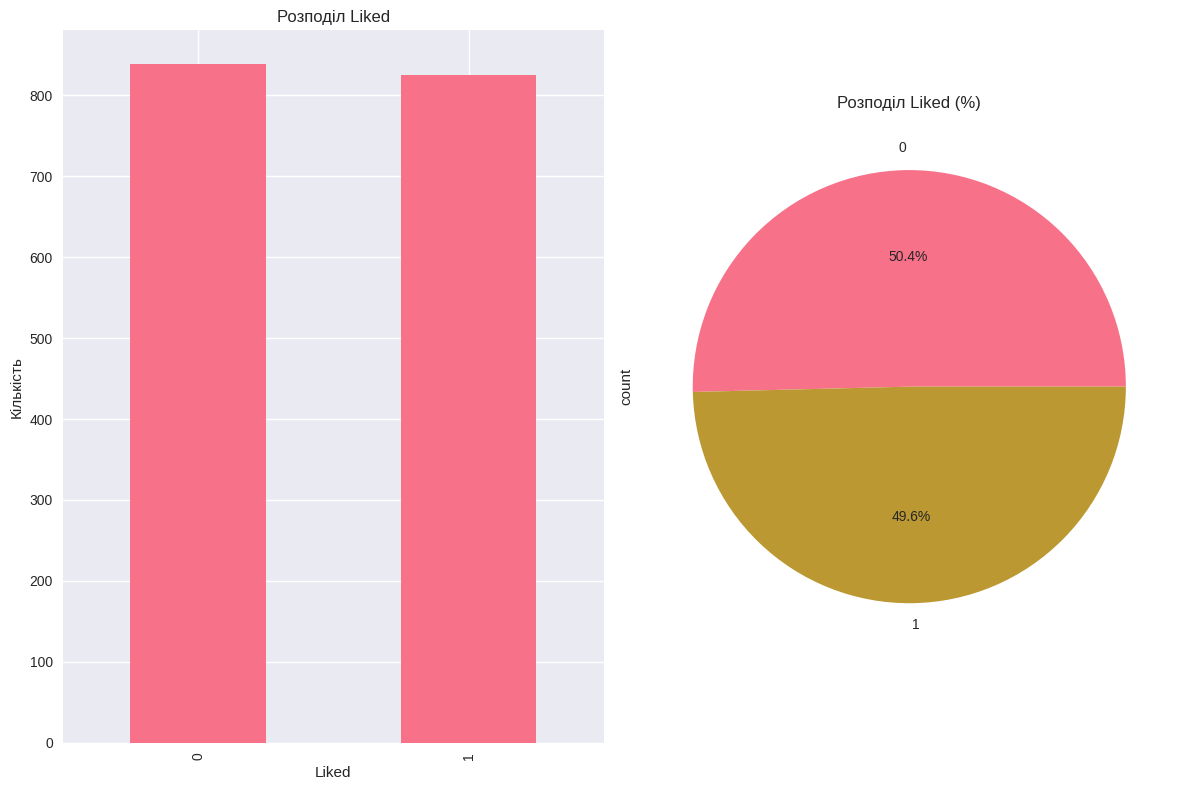

2025-09-20 10:30:32,364 - RestaurantAnalysis - INFO - Візуалізація розподілу Liked створена
INFO:RestaurantAnalysis:Візуалізація розподілу Liked створена


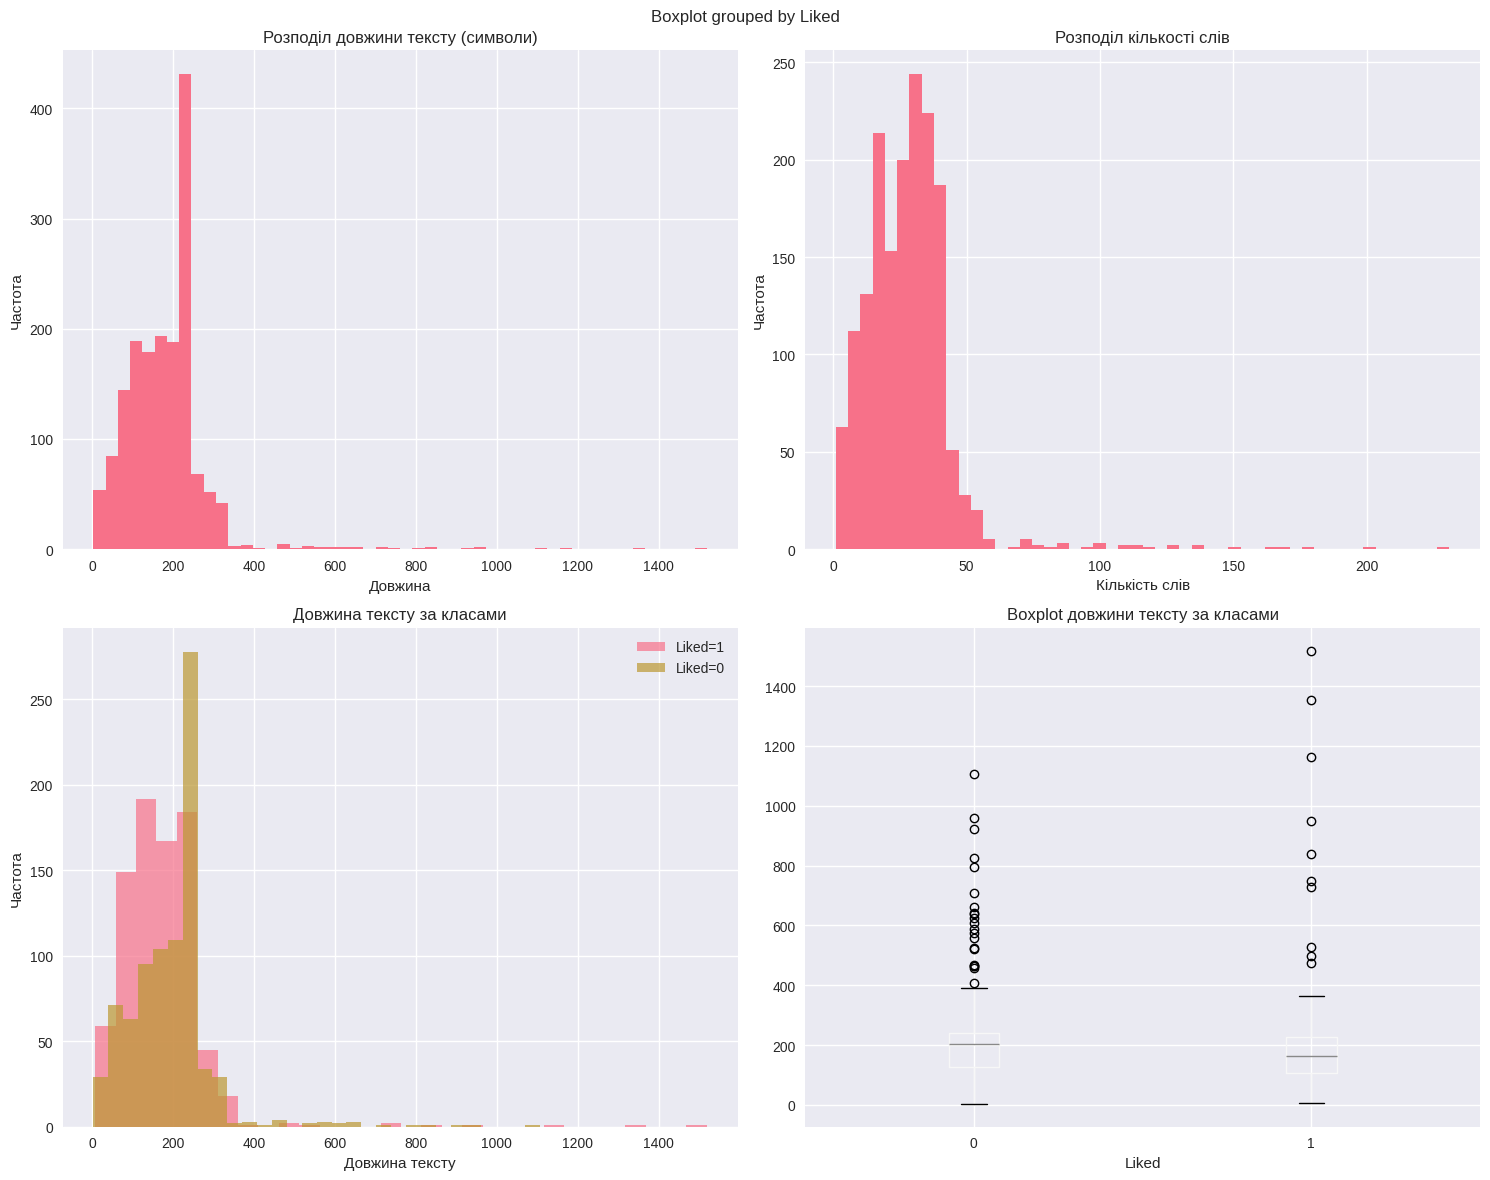

2025-09-20 10:30:36,086 - RestaurantAnalysis - INFO - Аналіз текстових даних завершено
INFO:RestaurantAnalysis:Аналіз текстових даних завершено
2025-09-20 10:30:36,109 - RestaurantAnalysis - INFO - ✅ Розвідувальний аналіз даних завершено
INFO:RestaurantAnalysis:✅ Розвідувальний аналіз даних завершено


In [2]:
# Імпорт системи
import sys
sys.path.append('/content/restaurant_analysis/modules')
from main_system import RestaurantAnalysisSystem

# Ініціалізація та робота
system = RestaurantAnalysisSystem()
data = system.run_data_loading()
stats = system.run_eda()

In [3]:
# ============================================================================
# ЕТАП 2: РОЗШИРЕНИЙ EDA ТА ОЧИЩЕННЯ ДАНИХ
# ============================================================================

# Встановлення тільки необхідних бібліотек
!pip install sweetviz wordcloud plotly -q

print("🔍 ЕТАП 2: РОЗШИРЕНИЙ EDA ТА ОЧИЩЕННЯ ДАНИХ")
print("="*60)

# Імпорт бібліотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Для роботи з текстом
import nltk
import re
from collections import Counter
from wordcloud import WordCloud
from pathlib import Path
import os
import sys

# Для статистичного аналізу
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Завантаження NLTK даних
try:
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('vader_lexicon', quiet=True)
    print("✅ NLTK дані завантажено")
except:
    print("⚠️ Проблема з NLTK - продовжуємо без нього")

# ============================================================================
# РОЗШИРЕННЯ МОДУЛЯ EDA ANALYZER
# ============================================================================

class AdvancedEDAAnalyzer:
    """Розширений клас для глибокого аналізу даних (стабільна версія)"""

    def __init__(self, config, logger):
        self.config = config
        self.logger = logger
        self.data = None
        self.plots_dir = Path(self.config.get('visualization.plots_dir'))
        self.plots_dir.mkdir(exist_ok=True)

        # Налаштування стилю
        plt.style.use(self.config.get('visualization.style'))
        sns.set_palette(self.config.get('visualization.palette'))

        self.logger.info("🔍 Розширений EDA аналізатор ініціалізовано")

    def set_data(self, data):
        """Встановлення даних для аналізу"""
        self.data = data.copy()
        self.logger.info(f"Дані для розширеного EDA встановлено. Розмір: {self.data.shape}")

    def generate_sweetviz_report(self):
        """Генерація автоматичного звіту з Sweetviz"""
        self.logger.info("📊 Генерація Sweetviz звіту...")

        try:
            # Створення звіту
            report = sv.analyze(self.data)

            # Збереження звіту
            report_path = self.plots_dir / "sweetviz_report.html"
            report.show_html(str(report_path))

            self.logger.info(f"✅ Sweetviz звіт збережено: {report_path}")

            # Показ основної інформації
            print("📊 SWEETVIZ АВТОМАТИЧНИЙ АНАЛІЗ ЗГЕНЕРОВАНО")
            print(f"📁 Звіт збережено: {report_path}")
            print("💡 Відкрийте файл у браузері для детального перегляду")

            return report_path

        except Exception as e:
            self.logger.error(f"Помилка генерації Sweetviz звіту: {str(e)}")
            print(f"⚠️ Помилка Sweetviz: {str(e)}")
            print("Продовжуємо без автоматичного звіту...")
            return None

    def missing_values_analysis(self):
        """Детальний аналіз пропущених значень"""
        self.logger.info("🔍 Аналіз пропущених значень...")

        # Підрахунок пропущених значень
        missing_data = pd.DataFrame({
            'Колонка': self.data.columns,
            'Пропущені': self.data.isnull().sum(),
            'Відсоток': (self.data.isnull().sum() / len(self.data)) * 100
        }).sort_values('Пропущені', ascending=False)

        print("🔍 АНАЛІЗ ПРОПУЩЕНИХ ЗНАЧЕНЬ")
        print("-" * 40)
        print(missing_data)

        # Візуалізація пропущених значень
        if missing_data['Пропущені'].sum() > 0:
            fig, axes = plt.subplots(1, 2, figsize=(15, 6))

            # Гістограма пропущених значень
            missing_data[missing_data['Пропущені'] > 0].plot(
                x='Колонка', y='Пропущені', kind='bar', ax=axes[0]
            )
            axes[0].set_title('Кількість пропущених значень')
            axes[0].set_ylabel('Кількість')
            axes[0].tick_params(axis='x', rotation=45)

            # Відсоток пропущених значень
            missing_data[missing_data['Пропущені'] > 0].plot(
                x='Колонка', y='Відсоток', kind='bar', ax=axes[1], color='orange'
            )
            axes[1].set_title('Відсоток пропущених значень')
            axes[1].set_ylabel('Відсоток (%)')
            axes[1].tick_params(axis='x', rotation=45)

            plt.tight_layout()
            plt.savefig(self.plots_dir / 'missing_values_analysis.png', dpi=300, bbox_inches='tight')
            plt.show()
        else:
            print("✅ Пропущених значень не виявлено!")

        return missing_data

    def duplicates_analysis(self):
        """Аналіз дублікатів"""
        self.logger.info("🔄 Аналіз дублікатів...")

        # Загальні дублікати
        total_duplicates = self.data.duplicated().sum()

        # Дублікати по колонках
        text_col = self.config.get('preprocessing.text_column')
        target_col = self.config.get('preprocessing.target_column')

        text_duplicates = self.data[text_col].duplicated().sum() if text_col in self.data.columns else 0

        print("🔄 АНАЛІЗ ДУБЛІКАТІВ")
        print("-" * 25)
        print(f"Загальні дублікати: {total_duplicates}")
        print(f"Дублікати тексту: {text_duplicates}")
        print(f"Відсоток дублікатів: {(total_duplicates/len(self.data)*100):.2f}%")

        duplicated_rows = None
        if total_duplicates > 0:
            # Показ прикладів дублікатів
            duplicated_rows = self.data[self.data.duplicated(keep=False)]
            print(f"\n📋 Приклади дублікатів:")
            print(duplicated_rows.head())

            # Аналіз дублікатів по класах
            if target_col in self.data.columns:
                duplicate_by_class = duplicated_rows[target_col].value_counts()
                print(f"\n🎯 Дублікати по класах:")
                print(duplicate_by_class)

        return {
            'total_duplicates': total_duplicates,
            'text_duplicates': text_duplicates,
            'duplicate_rows': duplicated_rows
        }

    def advanced_text_analysis(self):
        """Глибокий аналіз тексту (без textstat)"""
        self.logger.info("📝 Розширений аналіз тексту...")

        text_col = self.config.get('preprocessing.text_column')
        target_col = self.config.get('preprocessing.target_column')

        if text_col not in self.data.columns:
            self.logger.warning(f"Колонка {text_col} не знайдена")
            return

        # Основні текстові метрики
        self.data['char_count'] = self.data[text_col].str.len()
        self.data['word_count'] = self.data[text_col].str.split().str.len()
        self.data['sentence_count'] = self.data[text_col].str.count(r'[.!?]+') + 1
        self.data['avg_word_length'] = self.data[text_col].apply(
            lambda x: np.mean([len(word) for word in str(x).split()]) if str(x).split() else 0
        )

        # Специфічні символи та емоції
        self.data['exclamation_count'] = self.data[text_col].str.count('!')
        self.data['question_count'] = self.data[text_col].str.count(r'\?')
        self.data['caps_count'] = self.data[text_col].str.count(r'[A-Z]')
        self.data['caps_ratio'] = self.data['caps_count'] / self.data['char_count']

        # Проста метрика складності тексту
        self.data['complexity_score'] = (
            self.data['avg_word_length'] * 0.4 +
            self.data['sentence_count'] * 0.3 +
            self.data['word_count'] / self.data['sentence_count'] * 0.3
        )

        print("📝 РОЗШИРЕНИЙ АНАЛІЗ ТЕКСТУ")
        print("-" * 35)

        text_metrics = ['char_count', 'word_count', 'sentence_count', 'avg_word_length',
                      'exclamation_count', 'question_count', 'caps_ratio', 'complexity_score']

        # УКРАЇНСЬКІ НАЗВИ ДЛЯ ГРАФІКІВ ТА ТАБЛИЦЬ
        metric_names_ua = {
            'char_count': 'Кількість символів',
            'word_count': 'Кількість слів',
            'sentence_count': 'Кількість речень',
            'avg_word_length': 'Середня довжина слова',
            'exclamation_count': 'Кількість знаків оклику',
            'question_count': 'Кількість знаків питання',
            'caps_ratio': 'Коефіцієнт великих літер',
            'complexity_score': 'Показник складності'
        }

        # Статистика по метриках З УКРАЇНСЬКИМИ НАЗВАМИ
        text_stats = self.data[text_metrics].describe()
        text_stats_ua = text_stats.rename(columns=metric_names_ua)
        print("📊 Статистика текстових метрик:")
        print(text_stats_ua.round(2))

        # Візуалізація З УКРАЇНСЬКИМИ НАЗВАМИ
        fig, axes = plt.subplots(2, 4, figsize=(20, 12))
        axes = axes.flatten()

        for i, metric in enumerate(text_metrics):
            self.data[metric].hist(bins=30, ax=axes[i], alpha=0.7, edgecolor='black')
            axes[i].set_title(f'Розподіл {metric_names_ua[metric]}')  # УКРАЇНСЬКА НАЗВА
            axes[i].set_xlabel(metric_names_ua[metric])                # УКРАЇНСЬКА НАЗВА
            axes[i].set_ylabel('Частота')
            axes[i].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(self.plots_dir / 'advanced_text_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Аналіз по класах З УКРАЇНСЬКИМИ НАЗВАМИ
        if target_col in self.data.columns:
            print(f"\n🎯 ПОРІВНЯННЯ ПО КЛАСАХ ({target_col}):")
            for class_val in self.data[target_col].unique():
                subset = self.data[self.data[target_col] == class_val]
                print(f"\n📋 Клас {class_val} (n={len(subset)}):")
                class_stats = subset[text_metrics].describe().loc[['mean', 'std']]
                class_stats_ua = class_stats.rename(columns=metric_names_ua)  # УКРАЇНСЬКІ НАЗВИ
                print(class_stats_ua.round(2))

        return text_stats


    def word_frequency_analysis(self):
        """Аналіз частоти слів та N-грам"""
        self.logger.info("📊 Аналіз частоти слів...")

        text_col = self.config.get('preprocessing.text_column')
        target_col = self.config.get('preprocessing.target_column')

        # Об'єднання всього тексту
        all_text = ' '.join(self.data[text_col].astype(str)).lower()

        # Очищення тексту
        clean_text = re.sub(r'[^a-zA-Z\s]', '', all_text)
        words = clean_text.split()

        # Видалення коротких слів
        words = [word for word in words if len(word) > 2]

        # Частота слів
        word_freq = Counter(words)
        common_words = word_freq.most_common(20)

        print("📊 АНАЛІЗ ЧАСТОТИ СЛІВ")
        print("-" * 30)
        print("🔤 Топ-20 найчастіших слів:")
        for i, (word, count) in enumerate(common_words, 1):
            print(f"{i:2d}. {word:<15} : {count}")

        # Візуалізація частоти слів
        fig, axes = plt.subplots(1, 3, figsize=(20, 6))

        # Топ слова
        words_df = pd.DataFrame(common_words, columns=['Слово', 'Частота'])
        words_df.plot(x='Слово', y='Частота', kind='bar', ax=axes[0], color='skyblue')
        axes[0].set_title('Топ-20 найчастіших слів')
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].grid(True, alpha=0.3)

        # Хмара слів
        if len(clean_text) > 0:
            try:
                wordcloud = WordCloud(
                    width=800, height=400,
                    background_color='white',
                    max_words=100,
                    colormap='viridis'
                ).generate(clean_text)
                axes[1].imshow(wordcloud, interpolation='bilinear')
                axes[1].set_title('Хмара слів (всі відгуки)')
                axes[1].axis('off')
            except:
                axes[1].text(0.5, 0.5, 'Помилка створення\nхмари слів',
                           ha='center', va='center', transform=axes[1].transAxes)
                axes[1].set_title('Хмара слів')

        # Розподіл довжини слів
        word_lengths = [len(word) for word in words]
        axes[2].hist(word_lengths, bins=range(1, max(word_lengths)+2), alpha=0.7,
                    edgecolor='black', color='lightcoral')
        axes[2].set_title('Розподіл довжини слів')
        axes[2].set_xlabel('Довжина слова')
        axes[2].set_ylabel('Частота')
        axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(self.plots_dir / 'word_frequency_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()

        # N-грами аналіз
        self._ngram_analysis()

        return word_freq

    def _ngram_analysis(self):
        """Аналіз N-грам"""
        text_col = self.config.get('preprocessing.text_column')

        try:
            # Біграми
            vectorizer_bigram = CountVectorizer(
                ngram_range=(2, 2),
                stop_words='english',
                max_features=20,
                lowercase=True
            )
            bigram_matrix = vectorizer_bigram.fit_transform(self.data[text_col].astype(str))
            bigram_freq = bigram_matrix.sum(axis=0).A1
            bigram_names = vectorizer_bigram.get_feature_names_out()

            # Тріграми
            vectorizer_trigram = CountVectorizer(
                ngram_range=(3, 3),
                stop_words='english',
                max_features=15,
                lowercase=True
            )
            trigram_matrix = vectorizer_trigram.fit_transform(self.data[text_col].astype(str))
            trigram_freq = trigram_matrix.sum(axis=0).A1
            trigram_names = vectorizer_trigram.get_feature_names_out()

            # Візуалізація N-грам
            fig, axes = plt.subplots(1, 2, figsize=(20, 8))

            # Біграми
            bigram_df = pd.DataFrame({'Біграма': bigram_names, 'Частота': bigram_freq})
            bigram_df = bigram_df.sort_values('Частота', ascending=True).tail(15)
            bigram_df.plot(x='Біграма', y='Частота', kind='barh', ax=axes[0], color='lightgreen')
            axes[0].set_title('Топ-15 біграм')
            axes[0].grid(True, alpha=0.3)

            # Тріграми
            trigram_df = pd.DataFrame({'Тріграма': trigram_names, 'Частота': trigram_freq})
            trigram_df = trigram_df.sort_values('Частота', ascending=True).tail(10)
            trigram_df.plot(x='Тріграма', y='Частота', kind='barh', ax=axes[1], color='lightblue')
            axes[1].set_title('Топ-10 тріграм')
            axes[1].grid(True, alpha=0.3)

            plt.tight_layout()
            plt.savefig(self.plots_dir / 'ngram_analysis.png', dpi=300, bbox_inches='tight')
            plt.show()

            print("\n📊 N-ГРАМИ АНАЛІЗ")
            print("-" * 20)
            print("🔤 Топ-10 біграм:")
            for i, (bigram, freq) in enumerate(zip(bigram_names, bigram_freq)):
                if i < 10:
                    print(f"{i+1:2d}. {bigram:<25} : {freq}")

        except Exception as e:
            print(f"⚠️ Помилка N-грам аналізу: {str(e)}")

    def outliers_detection(self):
        """Виявлення викидів в даних"""
        self.logger.info("🎯 Виявлення викидів...")

        # Числові колонки для аналізу викидів
        numeric_cols = self.data.select_dtypes(include=[np.number]).columns.tolist()

        if len(numeric_cols) == 0:
            print("⚠️ Немає числових колонок для аналізу викидів")
            return {}

        outliers_info = {}

        print("🎯 ВИЯВЛЕННЯ ВИКИДІВ")
        print("-" * 25)

        for col in numeric_cols:
            # Метод IQR
            Q1 = self.data[col].quantile(0.25)
            Q3 = self.data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outliers = self.data[(self.data[col] < lower_bound) | (self.data[col] > upper_bound)]
            outliers_count = len(outliers)
            outliers_percent = (outliers_count / len(self.data)) * 100

            outliers_info[col] = {
                'count': outliers_count,
                'percent': outliers_percent,
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            }

            print(f"📊 {col}:")
            print(f"   Викиди: {outliers_count} ({outliers_percent:.2f}%)")
            print(f"   Межі: [{lower_bound:.2f}, {upper_bound:.2f}]")

        # Візуалізація викидів
        if len(numeric_cols) > 0:
            n_cols = min(len(numeric_cols), 4)
            fig, axes = plt.subplots(1, n_cols, figsize=(5*n_cols, 6))
            if n_cols == 1:
                axes = [axes]

            for i, col in enumerate(numeric_cols[:4]):
                ax = axes[i] if n_cols > 1 else axes[0]
                self.data.boxplot(column=col, ax=ax)
                ax.set_title(f'Boxplot {col}')
                ax.grid(True, alpha=0.3)

            plt.tight_layout()
            plt.savefig(self.plots_dir / 'outliers_analysis.png', dpi=300, bbox_inches='tight')
            plt.show()

        return outliers_info

    def correlation_heatmap(self):
        """Розширена матриця кореляції"""
        self.logger.info("🔗 Аналіз кореляції...")

        # УКРАЇНСЬКІ НАЗВИ ДЛЯ ГРАФІКІВ ТА ТАБЛИЦЬ
        column_names_ua = {
        'char_count': 'Кількість символів',
        'word_count': 'Кількість слів',
        'sentence_count': 'Кількість речень',
        'avg_word_length': 'Середня довжина слова',
        'exclamation_count': 'Кількість знаків оклику',
        'question_count': 'Кількість знаків питання',
        'caps_count': 'Кількість великих літер',
        'caps_ratio': 'Коефіцієнт великих літер',
        'complexity_score': 'Показник складності',
        }

        # Числові колонки
        numeric_data = self.data.select_dtypes(include=[np.number])

        if numeric_data.empty:
            print("⚠️ Немає числових даних для кореляції")
            return None

        # Матриця кореляції
        correlation_matrix = numeric_data.corr()
        # Змінити назви колонок після розрахунку кореляції
        correlation_matrix_ua = correlation_matrix.rename(
        columns=column_names_ua,
        index=column_names_ua
        )

        # Візуалізація
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))

        # Звичайна heatmap
        sns.heatmap(correlation_matrix_ua, annot=True, cmap='RdYlBu_r', center=0,
                    square=True, linewidths=0.5, ax=axes[0], fmt='.2f')
        axes[0].set_title('Матриця кореляції')

        # Маскована heatmap (показує тільки сильні кореляції)
        mask = np.abs(correlation_matrix) < 0.3
        sns.heatmap(correlation_matrix_ua, mask=mask, annot=True, cmap='RdYlBu_r',
                    center=0, square=True, linewidths=0.5, ax=axes[1], fmt='.2f')
        axes[1].set_title('Сильні кореляції (|r| ≥ 0.3)')

        plt.tight_layout()
        plt.savefig(self.plots_dir / 'enhanced_correlation.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Виявлення найсильніших кореляцій
        print("🔗 НАЙСИЛЬНІШІ КОРЕЛЯЦІЇ")
        print("-" * 30)

        # Перетворення матриці в список пар
        correlations = []
        for i in range(len(correlation_matrix.columns)):
            for j in range(i+1, len(correlation_matrix.columns)):
                corr_val = correlation_matrix.iloc[i, j]
                if abs(corr_val) > 0.3:  # Тільки сильні кореляції
                    correlations.append({
                        'Змінна 1': correlation_matrix.columns[i],
                        'Змінна 2': correlation_matrix.columns[j],
                        'Кореляція': corr_val
                    })

        if correlations:
            corr_df = pd.DataFrame(correlations).sort_values('Кореляція', key=abs, ascending=False)
            print(corr_df)
        else:
            print("Сильних кореляцій не виявлено")

        return correlation_matrix

# ============================================================================
# ІНТЕГРАЦІЯ З ОСНОВНОЮ СИСТЕМОЮ
# ============================================================================

class EnhancedRestaurantAnalysisSystem:
    """Розширена система з додатковими можливостями EDA"""

    def __init__(self, existing_system):
        self.base_system = existing_system
        self.config = existing_system.config
        self.logger = existing_system.logger
        self.advanced_eda = AdvancedEDAAnalyzer(self.config, self.logger)

        self.logger.info("🚀 Розширена система аналізу ініціалізована")

    def run_advanced_eda(self):
        """Запуск розширеного EDA"""
        if self.base_system.raw_data is None:
            raise ValueError("Дані не завантажено. Спочатку викличте run_data_loading()")

        self.logger.info("🔍 Початок розширеного EDA...")

        # Виведення даних
        print("\n" + "="*60)
        print("Відображення перших 20 значень")
        print(self.base_system.raw_data.head(20))
        print("\n" + "="*60)

        # Встановлення даних
        self.advanced_eda.set_data(self.base_system.raw_data)

        results = {}

        # 1. Sweetviz автоматичний звіт
        print("\n" + "="*60)
        print("1️⃣ ГЕНЕРАЦІЯ АВТОМАТИЧНОГО ЗВІТУ (SWEETVIZ)")
        results['sweetviz_path'] = self.advanced_eda.generate_sweetviz_report()

        # 2. Аналіз пропущених значень
        print("\n" + "="*60)
        print("2️⃣ АНАЛІЗ ПРОПУЩЕНИХ ЗНАЧЕНЬ")
        results['missing_analysis'] = self.advanced_eda.missing_values_analysis()

        # 3. Аналіз дублікатів
        print("\n" + "="*60)
        print("3️⃣ АНАЛІЗ ДУБЛІКАТІВ")
        results['duplicates_analysis'] = self.advanced_eda.duplicates_analysis()

        # 4. Розширений аналіз тексту
        print("\n" + "="*60)
        print("4️⃣ РОЗШИРЕНИЙ АНАЛІЗ ТЕКСТУ")
        results['text_analysis'] = self.advanced_eda.advanced_text_analysis()

        # 5. Аналіз частоти слів
        print("\n" + "="*60)
        print("5️⃣ АНАЛІЗ ЧАСТОТИ СЛІВ ТА N-ГРАМ")
        results['word_frequency'] = self.advanced_eda.word_frequency_analysis()

        # 6. Виявлення викидів
        print("\n" + "="*60)
        print("6️⃣ ВИЯВЛЕННЯ ВИКИДІВ")
        results['outliers'] = self.advanced_eda.outliers_detection()

        # 7. Розширена кореляція
        print("\n" + "="*60)
        print("7️⃣ РОЗШИРЕНИЙ АНАЛІЗ КОРЕЛЯЦІЇ")
        results['correlation'] = self.advanced_eda.correlation_heatmap()

        self.logger.info("✅ Розширений EDA завершено")

        print("\n" + "="*60)
        print("🎉 ЕТАП 2 ЗАВЕРШЕНО УСПІШНО!")
        print("="*60)
        print("📁 Всі графіки збережено у папці: /content/restaurant_analysis/plots/")
        print("📊 Sweetviz звіт доступний для перегляду")
        print("🔍 Детальна інформація про дані отримана")

        return results

    def get_data_quality_report(self):
        """Генерація звіту про якість даних"""
        data = self.base_system.raw_data

        quality_report = {
            'dataset_size': data.shape,
            'missing_values_total': data.isnull().sum().sum(),
            'duplicates_total': data.duplicated().sum(),
            'memory_usage_mb': data.memory_usage(deep=True).sum() / 1024 / 1024,
            'columns_info': {
                'total': len(data.columns),
                'numeric': len(data.select_dtypes(include=[np.number]).columns),
                'categorical': len(data.select_dtypes(include=['object']).columns)
            }
        }

        print("📋 ЗВІТ ПРО ЯКІСТЬ ДАНИХ")
        print("="*40)
        print(f"📊 Розмір датасету: {quality_report['dataset_size']}")
        print(f"❓ Пропущені значення: {quality_report['missing_values_total']}")
        print(f"🔄 Дублікати: {quality_report['duplicates_total']}")
        print(f"💾 Використання пам'яті: {quality_report['memory_usage_mb']:.2f} MB")
        print(f"📋 Колонки: {quality_report['columns_info']}")

        return quality_report

    def display_file_info(self):
      """Відображення детальної інформації про файл"""
      df = self.base_system.raw_data

      # Виведення основної інформації
      print("\n" + "="*60)
      print("БАЗОВА ІНФОРМАЦІЯ ПРО ФАЙЛ")
      print("="*60)

      # Розмір датасету
      print(f"Розмір даних: {df.shape[0]} рядків, {df.shape[1]} стовпців")

      # Загальна інформація
      print("\nЗАГАЛЬНА ІНФОРМАЦІЯ:\n")
      df.info()

      # Типи даних
      print("\nТИПИ ДАНИХ:\n")
      print(df.dtypes)

      # Назви стовпців
      print(f"\nНАЗВИ СТОВПЦІВ ({len(df.columns)}):")
      for i, col in enumerate(df.columns, 1):
          print(f"{i:2d}. {col}")

# ============================================================================
# ІНСТРУКЦІЇ ДЛЯ ЗАПУСКУ
# ============================================================================

print("\n🎯 ГОТОВНІСТЬ ДО ЗАПУСКУ ЕТАПУ 2")
print("="*60)
print("""
📋 ЩО БУДЕ ВИКОНАНО:

1️⃣ Sweetviz автоматичний звіт (HTML)
2️⃣ Детальний аналіз пропущених значень
3️⃣ Аналіз та обробка дублікатів
4️⃣ Розширені текстові метрики (8 нових показників)
5️⃣ Частота слів та N-грами (біграми, тріграми)
6️⃣ Виявлення викидів (метод IQR)
7️⃣ Розширена матриця кореляції

🚀 ІНСТРУКЦІЯ ДЛЯ ЗАПУСКУ:

# Завантажити дані в основну систему
print("🔄 Завантаження даних...")
data = system.run_data_loading()
print(f"✅ Дані завантажено: {data.shape}")

# Використовуємо існуючу систему з Етапу 1
enhanced_system = EnhancedRestaurantAnalysisSystem(system)

# Запуск розширеного EDA
results = enhanced_system.run_advanced_eda()

# Звіт про якість даних
quality_report = enhanced_system.get_data_quality_report()

""")

🔍 ЕТАП 2: РОЗШИРЕНИЙ EDA ТА ОЧИЩЕННЯ ДАНИХ
✅ NLTK дані завантажено

🎯 ГОТОВНІСТЬ ДО ЗАПУСКУ ЕТАПУ 2

📋 ЩО БУДЕ ВИКОНАНО:

1️⃣ Sweetviz автоматичний звіт (HTML)
2️⃣ Детальний аналіз пропущених значень
3️⃣ Аналіз та обробка дублікатів
4️⃣ Розширені текстові метрики (8 нових показників)
5️⃣ Частота слів та N-грами (біграми, тріграми)
6️⃣ Виявлення викидів (метод IQR)
7️⃣ Розширена матриця кореляції

🚀 ІНСТРУКЦІЯ ДЛЯ ЗАПУСКУ:

# Завантажити дані в основну систему
print("🔄 Завантаження даних...")
data = system.run_data_loading()
print(f"✅ Дані завантажено: {data.shape}")

# Використовуємо існуючу систему з Етапу 1
enhanced_system = EnhancedRestaurantAnalysisSystem(system)

# Запуск розширеного EDA
results = enhanced_system.run_advanced_eda()

# Звіт про якість даних
quality_report = enhanced_system.get_data_quality_report()




2025-09-20 10:31:00,499 - RestaurantAnalysis - INFO - 🔄 Початок завантаження даних...
INFO:RestaurantAnalysis:🔄 Початок завантаження даних...
2025-09-20 10:31:00,510 - RestaurantAnalysis - INFO - Завантаження даних з: https://raw.githubusercontent.com/tetiana-zhuchenko/dataset-restaurant-reviewss/main/reviews-uK-lang.csv
INFO:RestaurantAnalysis:Завантаження даних з: https://raw.githubusercontent.com/tetiana-zhuchenko/dataset-restaurant-reviewss/main/reviews-uK-lang.csv
2025-09-20 10:31:00,579 - RestaurantAnalysis - INFO - Дані успішно завантажено. Розмір: (1663, 2)
INFO:RestaurantAnalysis:Дані успішно завантажено. Розмір: (1663, 2)
2025-09-20 10:31:00,584 - RestaurantAnalysis - INFO - Початок валідації даних...
INFO:RestaurantAnalysis:Початок валідації даних...
2025-09-20 10:31:00,595 - RestaurantAnalysis - INFO - Валідація пройдена успішно
INFO:RestaurantAnalysis:Валідація пройдена успішно
2025-09-20 10:31:00,600 - RestaurantAnalysis - WARNING - Попередження: ['Знайдено дублікатів: 29

🔄 Завантаження даних...
✅ Дані завантажено: (1663, 2)
🚀 Розширена система створена

БАЗОВА ІНФОРМАЦІЯ ПРО ФАЙЛ
Розмір даних: 1663 рядків, 2 стовпців

ЗАГАЛЬНА ІНФОРМАЦІЯ:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1663 entries, 0 to 1662
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  1663 non-null   object
 1   Liked   1663 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 26.1+ KB

ТИПИ ДАНИХ:

Review    object
Liked      int64
dtype: object

НАЗВИ СТОВПЦІВ (2):
 1. Review
 2. Liked

Відображення перших 20 значень
                                               Review  Liked
0   Все було надзвичайно смачно та приємно! Атмосф...      1
1   Затишне місце з гарною терасою, де можна чудов...      1
2   Дякуємо за смачну їжу!\nСтрави були справді на...      1
3   Чудове місце, дуже смачно, красиво та приємний...      1
4   Дякуємо за чудовий вечір у вашому ресторані! Ї...      1
5   Дуже тихе та затишне 

                                             |          | [  0%]   00:00 -> (? left)

2025-09-20 10:31:02,441 - RestaurantAnalysis - INFO - ✅ Sweetviz звіт збережено: /content/restaurant_analysis/plots/sweetviz_report.html
INFO:RestaurantAnalysis:✅ Sweetviz звіт збережено: /content/restaurant_analysis/plots/sweetviz_report.html
2025-09-20 10:31:02,448 - RestaurantAnalysis - INFO - 🔍 Аналіз пропущених значень...
INFO:RestaurantAnalysis:🔍 Аналіз пропущених значень...
2025-09-20 10:31:02,457 - RestaurantAnalysis - INFO - 🔄 Аналіз дублікатів...
INFO:RestaurantAnalysis:🔄 Аналіз дублікатів...
2025-09-20 10:31:02,469 - RestaurantAnalysis - INFO - 📝 Розширений аналіз тексту...
INFO:RestaurantAnalysis:📝 Розширений аналіз тексту...


Report /content/restaurant_analysis/plots/sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
📊 SWEETVIZ АВТОМАТИЧНИЙ АНАЛІЗ ЗГЕНЕРОВАНО
📁 Звіт збережено: /content/restaurant_analysis/plots/sweetviz_report.html
💡 Відкрийте файл у браузері для детального перегляду

2️⃣ АНАЛІЗ ПРОПУЩЕНИХ ЗНАЧЕНЬ
🔍 АНАЛІЗ ПРОПУЩЕНИХ ЗНАЧЕНЬ
----------------------------------------
       Колонка  Пропущені  Відсоток
Review  Review          0       0.0
Liked    Liked          0       0.0
✅ Пропущених значень не виявлено!

3️⃣ АНАЛІЗ ДУБЛІКАТІВ
🔄 АНАЛІЗ ДУБЛІКАТІВ
-------------------------
Загальні дублікати: 290
Дублікати тексту: 290
Відсоток дублікатів: 17.44%

📋 Приклади дублікатів:
                                                Review  Liked
190  30.11 відпочивали в першій кабінці, бармен зіп...      0
191  За тиждень забронювали столик та попередили, щ...      0
192  Ресторан і кухня більш менш. Обслуго

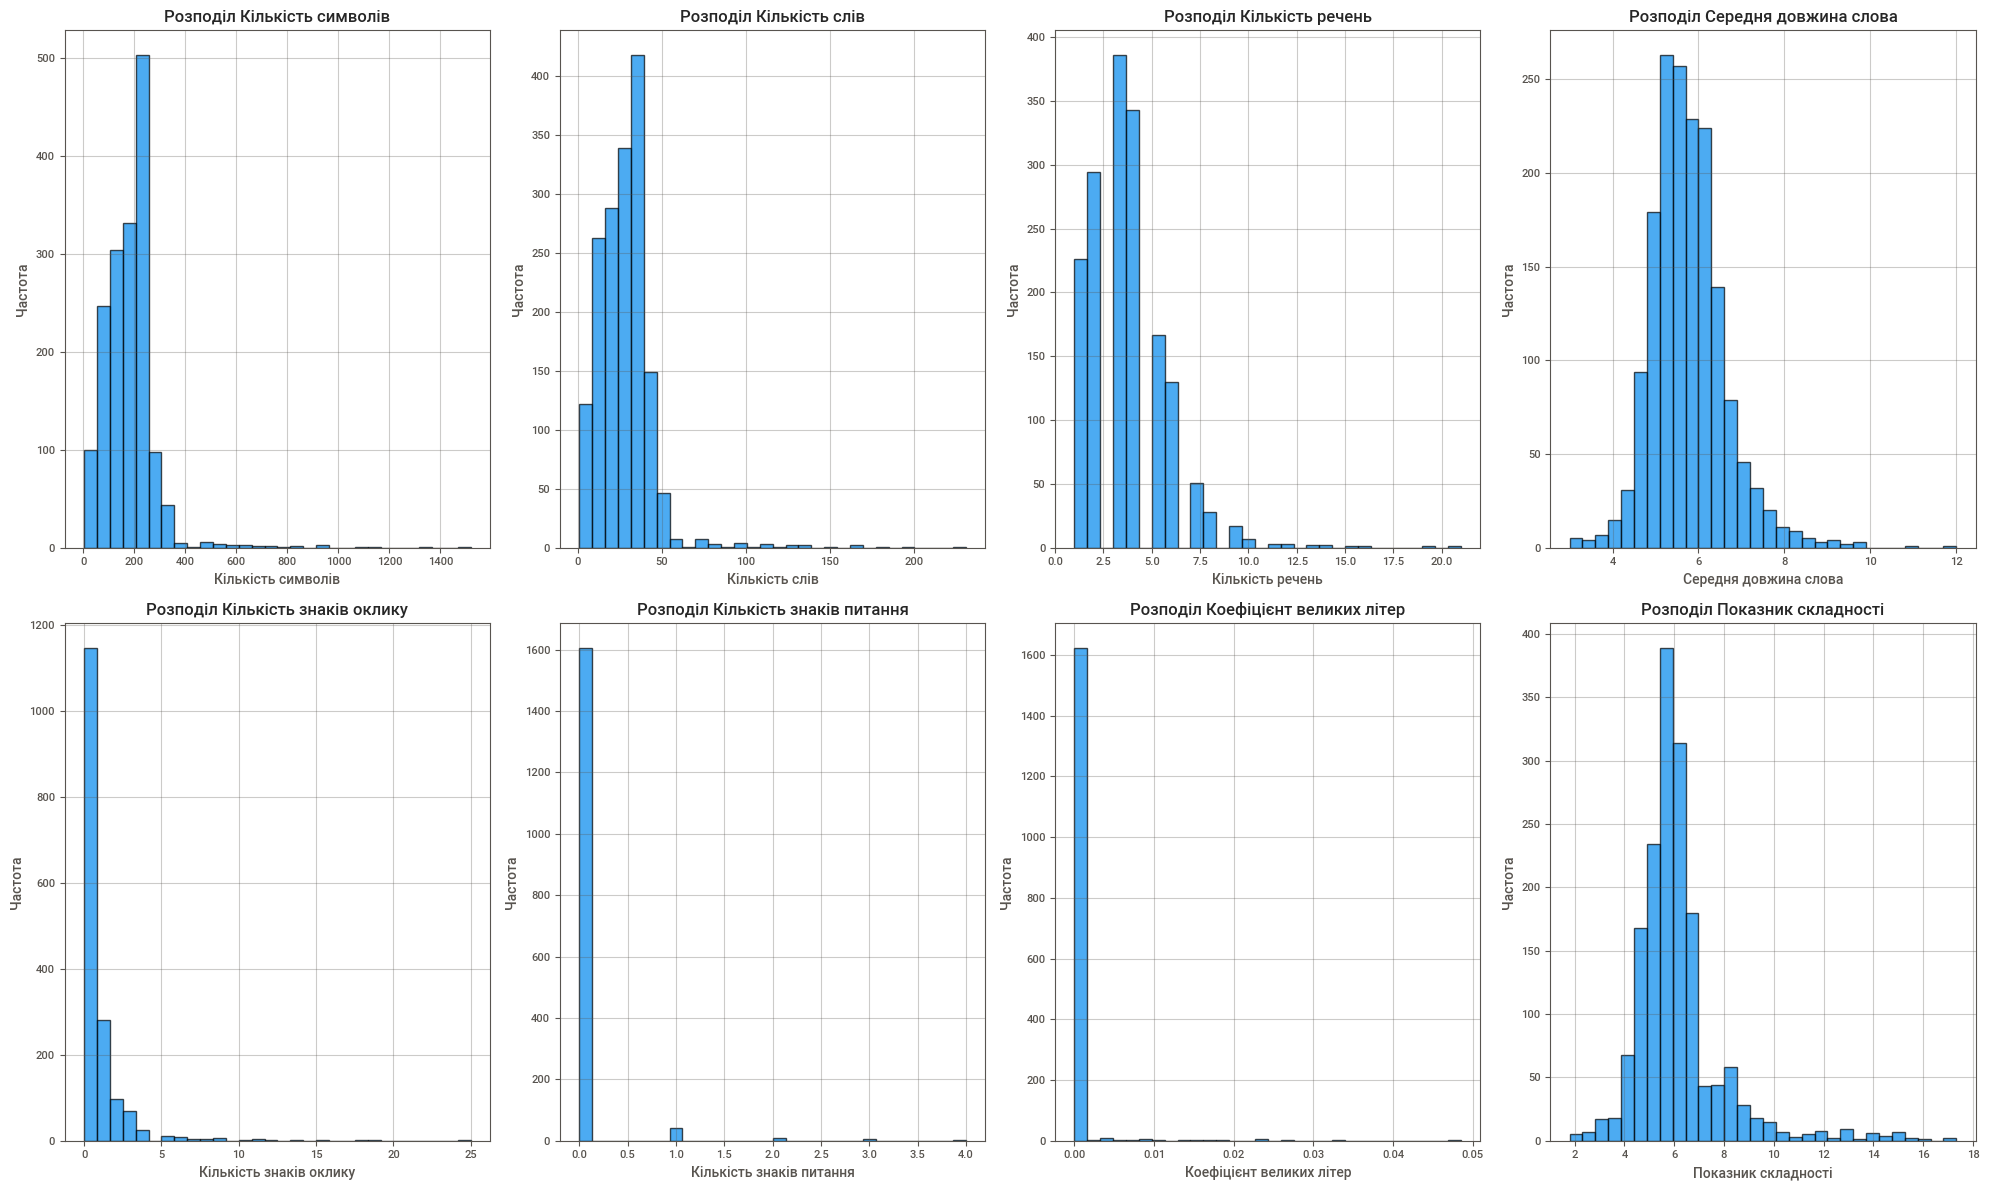

2025-09-20 10:31:13,194 - RestaurantAnalysis - INFO - 📊 Аналіз частоти слів...
INFO:RestaurantAnalysis:📊 Аналіз частоти слів...



🎯 ПОРІВНЯННЯ ПО КЛАСАХ (Liked):

📋 Клас 1 (n=825):
      Кількість символів  Кількість слів  Кількість речень  \
mean              171.64            25.0              3.42   
std               113.33            17.0              2.00   

      Середня довжина слова  Кількість знаків оклику  \
mean                   6.01                     0.80   
std                    0.86                     1.42   

      Кількість знаків питання  Коефіцієнт великих літер  Показник складності  
mean                      0.00                       0.0                 5.99  
std                       0.06                       0.0                 1.55  

📋 Клас 0 (n=838):
      Кількість символів  Кількість слів  Кількість речень  \
mean              194.96           30.64              3.74   
std               107.17           17.48              2.11   

      Середня довжина слова  Кількість знаків оклику  \
mean                   5.50                     0.63   
std                    0.81       

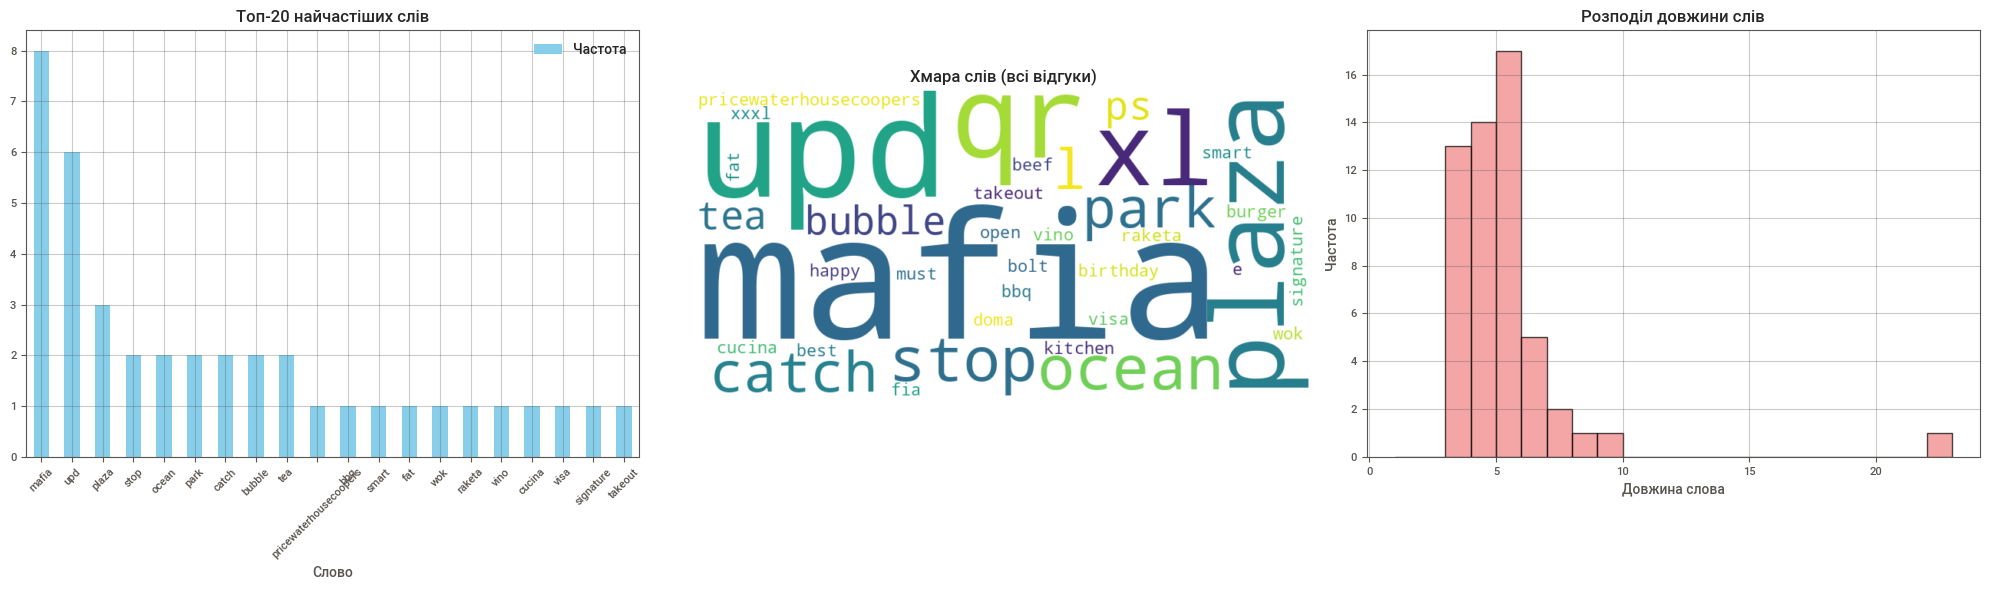

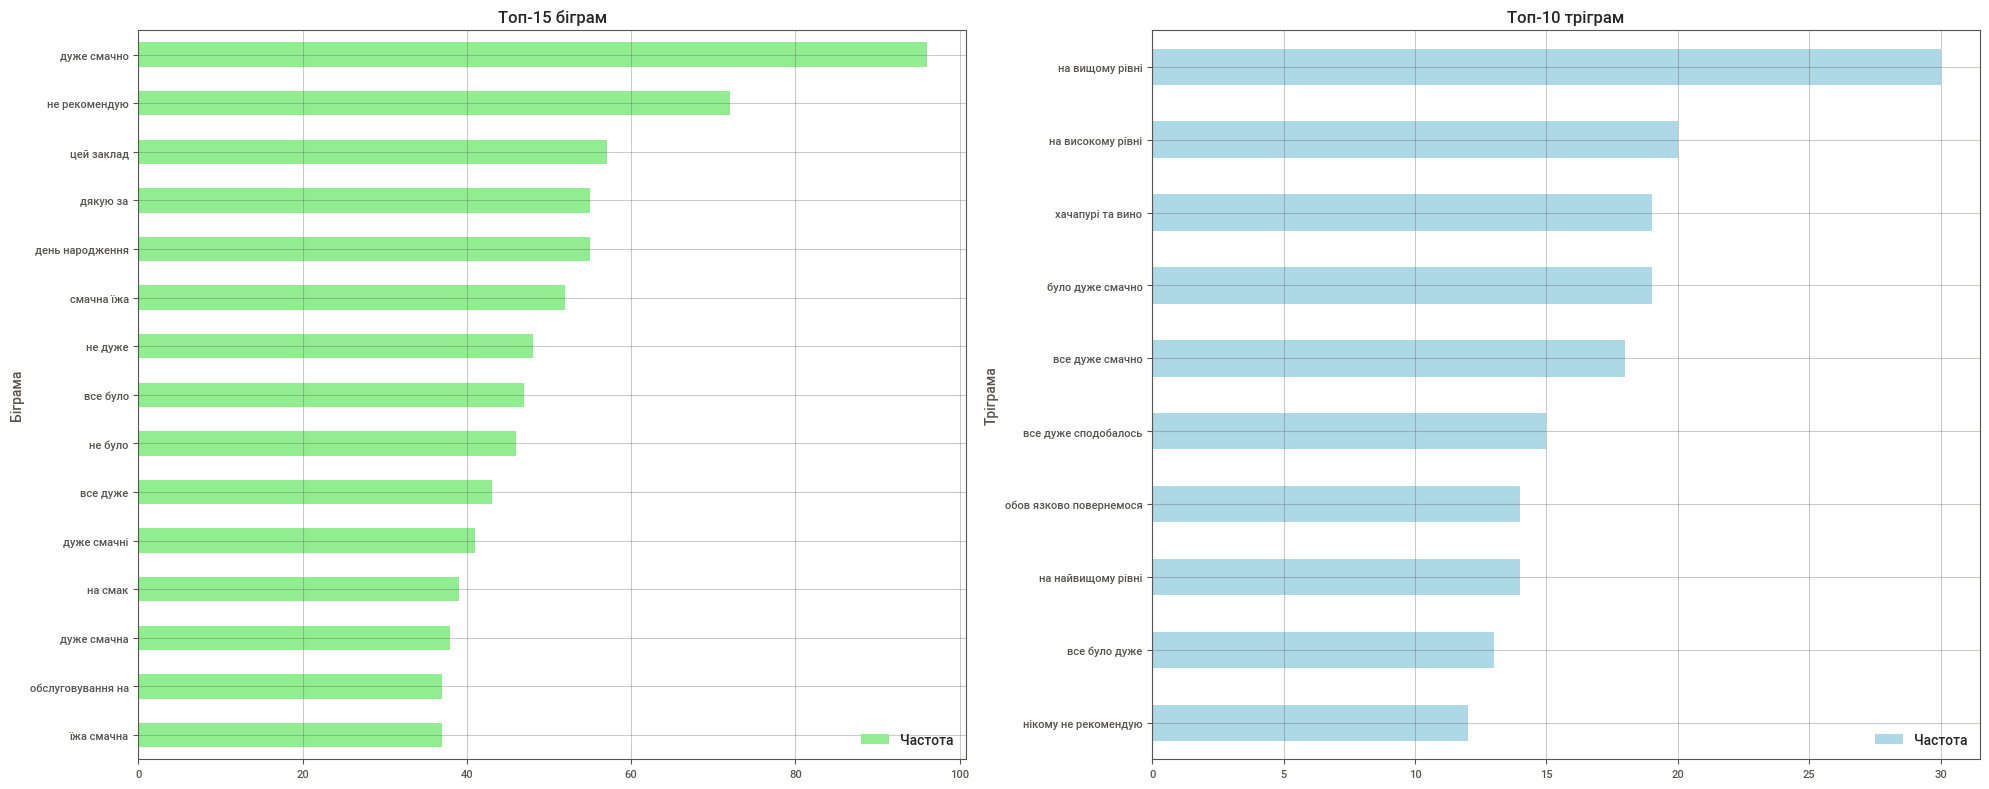

2025-09-20 10:31:24,383 - RestaurantAnalysis - INFO - 🎯 Виявлення викидів...
INFO:RestaurantAnalysis:🎯 Виявлення викидів...



📊 N-ГРАМИ АНАЛІЗ
--------------------
🔤 Топ-10 біграм:
 1. все було                  : 47
 2. все дуже                  : 43
 3. день народження           : 55
 4. дуже смачна               : 38
 5. дуже смачно               : 96
 6. дуже смачні               : 41
 7. дякую за                  : 55
 8. на смак                   : 39
 9. не було                   : 46
10. не дуже                   : 48

6️⃣ ВИЯВЛЕННЯ ВИКИДІВ
🎯 ВИЯВЛЕННЯ ВИКИДІВ
-------------------------
📊 Liked:
   Викиди: 0 (0.00%)
   Межі: [-1.50, 2.50]
📊 char_count:
   Викиди: 30 (1.80%)
   Межі: [-60.50, 415.50]
📊 word_count:
   Викиди: 31 (1.86%)
   Межі: [-11.50, 64.50]
📊 sentence_count:
   Викиди: 66 (3.97%)
   Межі: [-1.00, 7.00]
📊 avg_word_length:
   Викиди: 59 (3.55%)
   Межі: [3.73, 7.67]
📊 exclamation_count:
   Викиди: 141 (8.48%)
   Межі: [-1.50, 2.50]
📊 question_count:
   Викиди: 58 (3.49%)
   Межі: [0.00, 0.00]
📊 caps_count:
   Викиди: 41 (2.47%)
   Межі: [0.00, 0.00]
📊 caps_ratio:
   Викиди: 41 (2.47%)


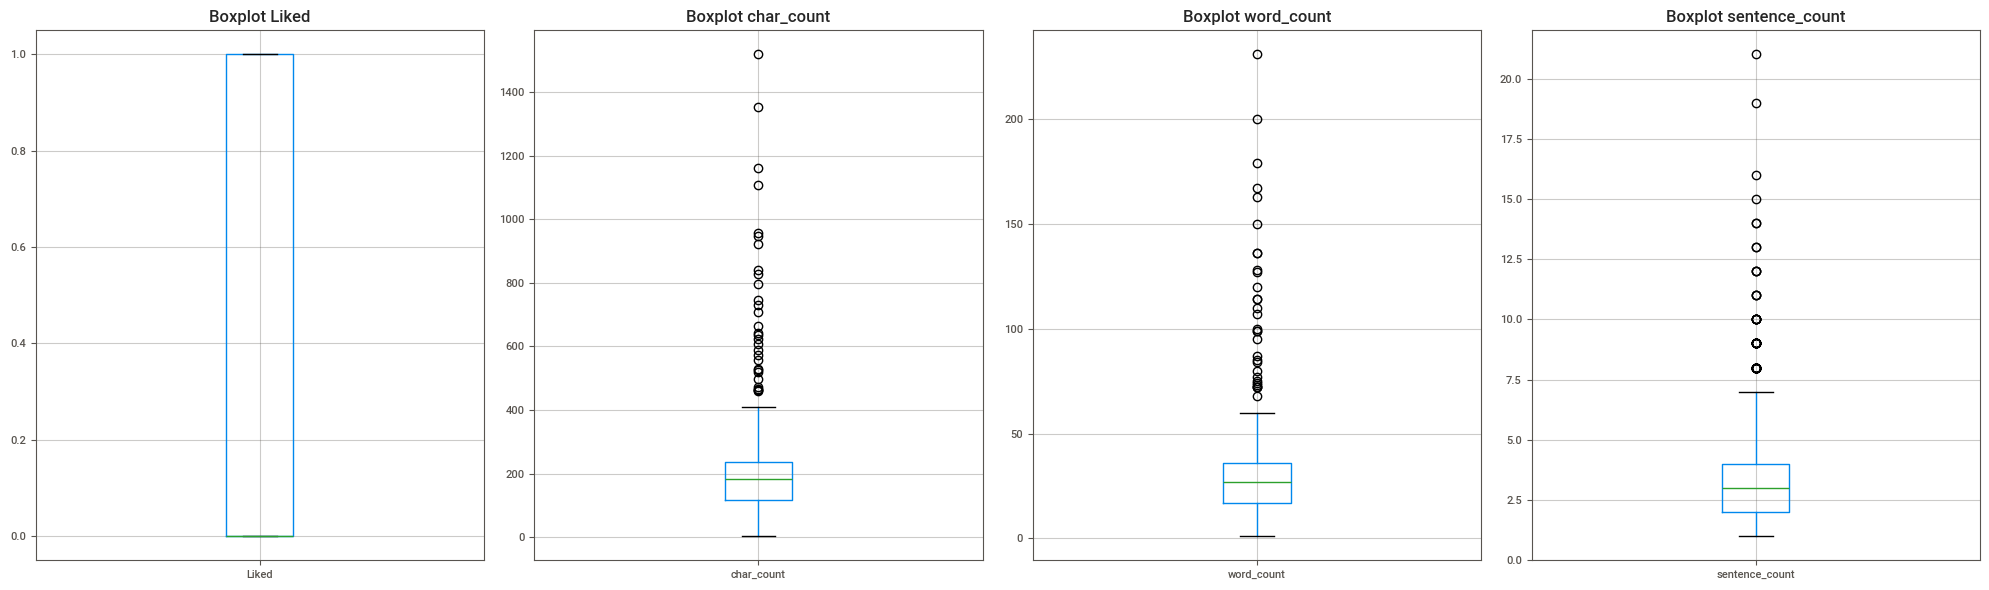

2025-09-20 10:31:27,797 - RestaurantAnalysis - INFO - 🔗 Аналіз кореляції...
INFO:RestaurantAnalysis:🔗 Аналіз кореляції...



7️⃣ РОЗШИРЕНИЙ АНАЛІЗ КОРЕЛЯЦІЇ


IndexError: Inconsistent shape between the condition and the input (got (19, 19) and (10, 10))

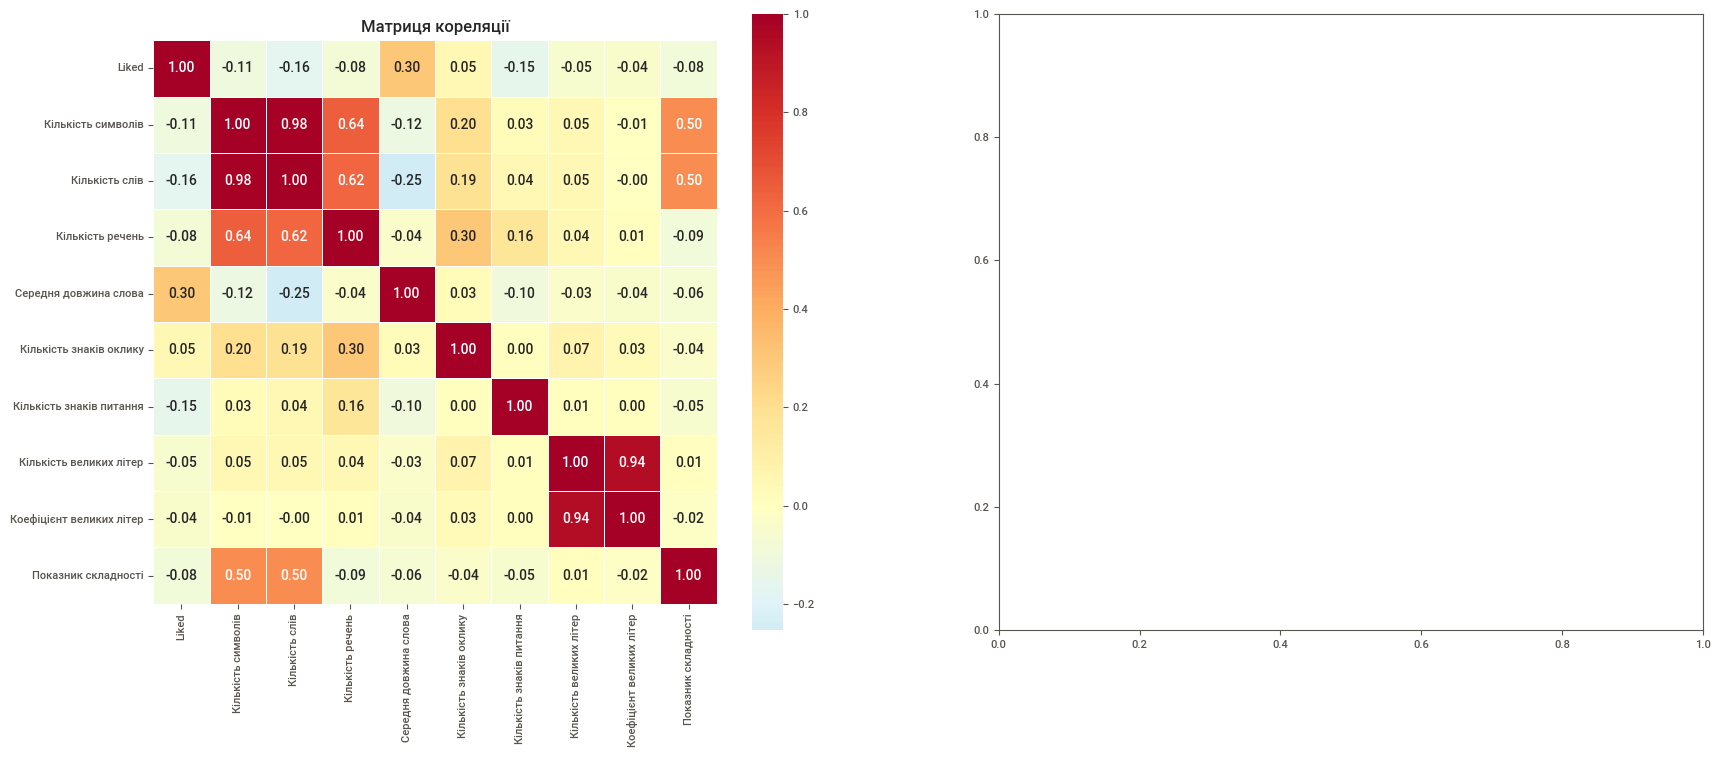

In [4]:
# Завантажити дані в основну систему
print("🔄 Завантаження даних...")
data = system.run_data_loading()
print(f"✅ Дані завантажено: {data.shape}")

# Створити розширену систему
enhanced_system = EnhancedRestaurantAnalysisSystem(system)
print("🚀 Розширена система створена")

# Опис файлу
quality_report = enhanced_system.display_file_info()

# Запустити розширений EDA
results = enhanced_system.run_advanced_eda()

# Звіт про якість даних
quality_report = enhanced_system.get_data_quality_report()



In [5]:
# ============================================================================
# ЕТАП 3 : ОБРОБКА ДАНИХ ТА ПІДГОТОВКА ДО ML З 4 АСПЕКТАМИ
# ============================================================================

print("🧹 ЕТАП 3: ОБРОБКА ДАНИХ З АСПЕКТНИМ АНАЛІЗОМ")
print("="*70)

# Імпорт необхідних бібліотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import warnings
warnings.filterwarnings('ignore')

# Для обробки тексту
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Для ML підготовки
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import resample

# Для оцінки якості
from sklearn.metrics import classification_report, confusion_matrix
import scipy.stats as stats

# ============================================================================
# КЛАС ДЛЯ ОБРОБКИ ПРОПУЩЕНИХ ЗНАЧЕНЬ (БЕЗ ЗМІН)
# ============================================================================

class MissingDataHandler:
    """Клас для комплексної обробки пропущених значень"""

    def __init__(self, config, logger):
        self.config = config
        self.logger = logger
        self.missing_strategies = {
            'remove': self._remove_missing,
            'mean_fill': self._mean_fill,
            'median_fill': self._median_fill,
            'mode_fill': self._mode_fill,
            'forward_fill': self._forward_fill,
            'backward_fill': self._backward_fill,
            'interpolate': self._interpolate_fill
        }

        self.logger.info("🔧 Обробник пропущених значень ініціалізовано")

    def analyze_missing_patterns(self, data):
        """Аналіз паттернів пропущених значень"""
        self.logger.info("🔍 Аналіз паттернів пропущених значень...")

        missing_info = {}

        for column in data.columns:
            missing_count = data[column].isnull().sum()
            missing_percent = (missing_count / len(data)) * 100

            if missing_count > 0:
                missing_type = self._classify_missing_type(data, column)

                missing_info[column] = {
                    'count': missing_count,
                    'percent': missing_percent,
                    'type': missing_type,
                    'recommended_strategy': self._recommend_strategy(missing_percent, missing_type)
                }

        print("🔍 АНАЛІЗ ПРОПУЩЕНИХ ЗНАЧЕНЬ")
        print("-" * 40)

        if missing_info:
            for col, info in missing_info.items():
                print(f"📊 {col}:")
                print(f"   Кількість: {info['count']}")
                print(f"   Відсоток: {info['percent']:.2f}%")
                print(f"   Тип: {info['type']}")
                print(f"   Рекомендація: {info['recommended_strategy']}")
                print()
        else:
            print("✅ Пропущених значень не виявлено!")

        return missing_info

    def _classify_missing_type(self, data, column):
        """Класифікація типу пропущених значень"""
        missing_mask = data[column].isnull()
        missing_percent = missing_mask.sum() / len(data)

        if missing_percent < 0.05:
            return "MCAR (Missing Completely At Random)"
        elif missing_percent < 0.15:
            return "MAR (Missing At Random)"
        else:
            return "MNAR (Missing Not At Random)"

    def _recommend_strategy(self, missing_percent, missing_type):
        """Рекомендація стратегії обробки"""
        if missing_percent < 5:
            return "remove (видалення рядків)"
        elif missing_percent < 15:
            return "mean/median/mode fill"
        else:
            return "advanced imputation"

    def handle_missing_values(self, data, strategy='auto'):
        """Обробка пропущених значень"""
        if strategy == 'auto':
            return self._auto_handle_missing(data)
        else:
            return self.missing_strategies[strategy](data)

    def _auto_handle_missing(self, data):
        """Автоматична обробка пропущених значень"""
        processed_data = data.copy()

        for column in data.columns:
            missing_count = data[column].isnull().sum()
            if missing_count > 0:
                missing_percent = (missing_count / len(data)) * 100

                if missing_percent < 5:
                    processed_data = processed_data.dropna(subset=[column])
                elif data[column].dtype in ['int64', 'float64']:
                    processed_data[column].fillna(data[column].median(), inplace=True)
                else:
                    processed_data[column].fillna(data[column].mode().iloc[0], inplace=True)

        return processed_data

    def _remove_missing(self, data):
        return data.dropna()

    def _mean_fill(self, data):
        return data.fillna(data.mean(numeric_only=True))

    def _median_fill(self, data):
        return data.fillna(data.median(numeric_only=True))

    def _mode_fill(self, data):
        return data.fillna(data.mode().iloc[0])

    def _forward_fill(self, data):
        return data.fillna(method='ffill')

    def _backward_fill(self, data):
        return data.fillna(method='bfill')

    def _interpolate_fill(self, data):
        return data.interpolate()

# ============================================================================
# РОЗШИРЕНИЙ КЛАС ДЛЯ ПРЕПРОЦЕСИНГУ ДАНИХ З АСПЕКТАМИ
# ============================================================================

class AspectAwareDataPreprocessor:
    """Клас для препроцесингу з аспект-орієнтованим аналізом"""

    def __init__(self, config, logger):
        self.config = config
        self.logger = logger
        self.text_vectorizer = None
        self.label_encoder = None
        self.scaler = None
        self.feature_names = []

        # Налаштування мови та стоп-слів
        self.language = self.config.get('preprocessing.language') or 'uk'
        self.stop_words = self._load_stopwords(self.language)

        self.stemmer = PorterStemmer()

        # Словники ключових слів для 4 аспектів (на основі N-грам)
        self.aspect_keywords = {
            'food': {
                'positive': [
                    # Загальні позитивні
                    'смачно', 'смачний', 'смачна', 'смачне', 'смачні',
                    'дуже смачно', 'неймовірно смачно', 'чудово', 'чудовий', 'чудова', 'чудове',
                    'відмінно', 'відмінний', 'відмінна', 'відмінне', 'відмінні',
                    'прекрасно', 'прекрасний', 'прекрасна', 'прекрасне', 'прекрасні',
                    'класно', 'класний', 'класна', 'класне', 'класні',
                    'супер', 'топ', 'бомба', 'огонь',

                    # Свіжість
                    'свіжий', 'свіжа', 'свіже', 'свіжі', 'свіжість',
                    'свіжайший', 'свіжайша', 'свіжайше', 'свіжайші',

                    # Текстура та смак
                    'соковитий', 'соковита', 'соковите', 'соковиті',
                    'ніжний', 'ніжна', 'ніжне', 'ніжні', 'ніжність',
                    'м\'який', 'м\'яка', 'м\'яке', 'м\'які', 'м\'якість',
                    'хрустящий', 'хрустяща', 'хрустяще', 'хрустящі',
                    'ароматний', 'ароматна', 'ароматне', 'ароматні', 'аромат',
                    'пікантний', 'пікантна', 'пікантне', 'пікантні',

                    # Приготування
                    'добре приготовлений', 'добре приготовлена', 'добре приготовлене',
                    'ідеально приготований', 'ідеально приготовлена', 'ідеально приготовлене',
                    'майстерно приготований', 'професійно приготований',

                    # Емоційні оцінки
                    'неймовірний', 'неймовірна', 'неймовірне', 'неймовірні',
                    'фантастичний', 'фантастична', 'фантастичне', 'фантастичні',
                    'божественний', 'божественна', 'божественне', 'божественні',
                    'розкішний', 'розкішна', 'розкішне', 'розкішні',

                    # Страви
                    'делікатес', 'делікатесний', 'делікатесна', 'делікатесне',
                    'шедевр', 'кулінарний шедевр',
                    'найкращий', 'найкраща', 'найкраще', 'найкращі',

                    # Загальні позитивні слова (додано для кращого розпізнавання)
                    'гарний напій', 'гарна страва', 'гарне меню', 'гарні страви', 'добрий смак', 'добра їжа', 'добре', 'добрі страви'
                ],
                'negative': [
                    # Загальні негативні
                    'несмачно', 'несмачний', 'несмачна', 'несмачне', 'несмачні',
                    'огидно', 'огидний', 'огидна', 'огидне', 'огидні',
                    'жахливо', 'жахливий', 'жахлива', 'жахливе', 'жахливі',
                    'погано', 'поганий', 'погана', 'погане', 'погані',
                    'відвратно', 'відвратний', 'відвратна', 'відвратне', 'відвратні',

                    # Якість продуктів
                    'несвіжий', 'несвіжа', 'несвіже', 'несвіжі', 'несвіжість',
                    'зіпсований', 'зіпсована', 'зіпсоване', 'зіпсовані',
                    'протермінований', 'протермінована', 'протерміноване', 'протерміновані',
                    'старий', 'стара', 'старе', 'старі',

                    # Приготування
                    'недоварений', 'недоварена', 'недоварене', 'недоварені',
                    'переварений', 'переварена', 'переварене', 'переварені',
                    'підгорілий', 'підгоріла', 'підгоріле', 'підгорілі',
                    'сирий', 'сира', 'сире', 'сирі',
                    'пересолений', 'пересолена', 'пересолене', 'пересолені',
                    'недосолений', 'недосолена', 'недосолене', 'недосолені',

                    # Текстура
                    'твердий', 'тверда', 'тверде', 'тверді',
                    'сухий', 'суха', 'сухе', 'сухі', 'сухість',
                    'жирний', 'жирна', 'жирне', 'жирні',
                    'гіркий', 'гірка', 'гірке', 'гіркі', 'гіркота',
                    'кислий', 'кисла', 'кисле', 'кислі',

                    # Температура
                    'холодний', 'холодна', 'холодне', 'холодні',
                    'теплий', 'тепла', 'тепле', 'теплі', 'не гарячий',

                    # Загальні проблеми
                    'безсмаковий', 'безсмакова', 'безсмакове', 'безсмакові',
                    'без смаку', 'без аромату', 'невкусний', 'невкусна',

                    # Результати обробки заперечень
                    'несмачн', 'несвіж', 'безсмаков', 'неякісн'
                ]
            },
            'service': {
                'positive': [
                    # Персонал
                    'ввічливий', 'ввічлива', 'ввічливе', 'ввічливі', 'ввічливість',
                    'привітний', 'привітна', 'привітне', 'привітні', 'привітність',
                    'дружній', 'дружня', 'дружнє', 'дружні', 'дружність',
                    'уважний', 'уважна', 'уважне', 'уважні', 'увага',
                    'професійний', 'професійна', 'професійне', 'професійні', 'професіоналізм',

                    # Швидкість
                    'швидко', 'швидкий', 'швидка', 'швидке', 'швидкі', 'швидкість',
                    'оперативно', 'оперативний', 'оперативна', 'оперативне', 'оперативні',
                    'миттєво', 'миттєвий', 'миттєва', 'миттєве', 'миттєві',
                    'вчасно', 'вчасний', 'вчасна', 'вчасне', 'вчасні',
                    'без затримок', 'без очікування',

                    # Якість обслуговування
                    'відмінне обслуговування', 'прекрасне обслуговування', 'чудове обслуговування',
                    'високий рівень обслуговування', 'бездоганне обслуговування',
                    'індивідуальний підхід', 'персональний підхід',
                    'дбайливий', 'дбайлива', 'дбайливе', 'дбайливі',

                    # Компетентність
                    'кваліфікований', 'кваліфікована', 'кваліфіковане', 'кваліфіковані',
                    'досвідчений', 'досвідчена', 'досвідчене', 'досвідчені',
                    'компетентний', 'компетентна', 'компетентне', 'компетентні',
                    'знає своє діло', 'розуміється на справі',

                    # Емоційні характеристики
                    'чарівний', 'чарівна', 'чарівне', 'чарівні',
                    'милий', 'мила', 'миле', 'милі',
                    'приємний', 'приємна', 'приємне', 'приємні',

                    # ДОДАНО: загальні позитивні слова для обслуговування
                    'гарне обслуговування', 'добре обслуговування', 'відмінний сервіс',
                    'чудовий персонал', 'прекрасний сервіс', 'добрий сервіс', 'гарне обслуговування',
                    'гарний сервіс', 'офіціант'
                ],
                'negative': [
                    # Невввічливість
                    'грубий', 'груба', 'грубе', 'грубі', 'грубість',
                    'неввічливий', 'неввічлива', 'неввічливе', 'неввічливі',
                    'хамський', 'хамська', 'хамське', 'хамські', 'хамство',
                    'зверхній', 'зверхня', 'зверхнє', 'зверхні', 'зверхність',

                    # Повільність
                    'повільно', 'повільний', 'повільна', 'повільне', 'повільні',
                    'довго чекати', 'довге очікування', 'довга подача',
                    'затримка', 'затримки', 'запізнення',
                    'забули про замовлення', 'забули подати',

                    # Некомпетентність
                    'некваліфікований', 'некваліфікована', 'некваліфіковане',
                    'недосвідчений', 'недосвідчена', 'недосвідчене',
                    'не знає меню', 'не розуміється',
                    'плутає замовлення', 'помилки в замовленні',

                    # Ігнорування
                    'ігнорують', 'ігнorування', 'не звертають увагу',
                    'байдужий', 'байдужа', 'байдуже', 'байдужі', 'байдужість',
                    'неуважний', 'неуважна', 'неуважне', 'неуважні',
                    'не допомагають', 'відмовляються', 'не хочуть',

                    # Загальні проблеми
                    'жахливе обслуговування', 'погане обслуговування',
                    'низький рівень обслуговування', 'непрофесійне обслуговування',
                    'розчарування', 'розчарований', 'розчарована',

                    # Результати обробки заперечень
                    'повільн', 'груб', 'непрофесійн', 'неуважн', 'неприв ітн', 'недружн', 'некомпетентн', 'офіціант'
                ]
            },
            'atmosphere': {
                'positive': [
                    # Загальна атмосфера
                    'затишно', 'затишний', 'затишна', 'затишне', 'затишні', 'затишок',
                    'комфортно', 'комфортний', 'комфортна', 'комфортне', 'комфортні', 'комфорт',
                    'приємно', 'приємний', 'приємна', 'приємне', 'приємні',
                    'романтично', 'романтичний', 'романтична', 'романтичне', 'романтичні',
                    'душевно', 'душевний', 'душевна', 'душевне', 'душевні',

                    # Дизайн та інтер'єр
                    'красиво', 'красивий', 'красива', 'красиве', 'красиві', 'краса',
                    'стильно', 'стильний', 'стильна', 'стильне', 'стильні', 'стиль',
                    'елегантно', 'елегантний', 'елегантна', 'елегантне', 'елегантні',
                    'сучасно', 'сучасний', 'сучасна', 'сучасне', 'сучасні',
                    'модно', 'модний', 'модна', 'модне', 'модні',
                    'оригінально', 'оригінальний', 'оригінальна', 'оригінальне', 'оригінальні',

                    # Атмосферні характеристики
                    'тепло', 'теплий', 'тепла', 'тепле', 'теплі', 'теплота',
                    'спокійно', 'спокійний', 'спокійна', 'спокійне', 'спокійні', 'спокій',
                    'релаксуюче', 'релаксуючий', 'релаксуюча', 'релаксуюче',
                    'гостинно', 'гостинний', 'гостинна', 'гостинне', 'гостинні',

                    # Освітлення та музика
                    'приглушене світло', 'м\'яке освітлення', 'романтичне освітлення',
                    'приємна музика', 'гарна музика', 'фонова музика',
                    'жива музика', 'музичний супровід',

                    # Загальні враження
                    'чарівно', 'чарівний', 'чарівна', 'чарівне', 'чарівні',
                    'казково', 'казковий', 'казкова', 'казкове', 'казкові',
                    'неповторно', 'неповторний', 'неповторна', 'неповторне', 'неповторні',

                    # Загальні позитивні слова для атмосфери
                    'гарна атмосфера', 'чудова атмосфера', 'приємна обстановка'
                ],
                'negative': [
                    # Шум
                    'шумно', 'шумний', 'шумна', 'шумне', 'шумні', 'шум',
                    'голосно', 'голосний', 'голосна', 'голосне', 'голосні',
                    'галасливо', 'галасливий', 'галаслива', 'галасливе', 'галасливі',
                    'не чути співрозмовника', 'дуже шумно', 'оглушливо',

                    # Тіснота
                    'тісно', 'тісний', 'тісна', 'тісне', 'тісні', 'теснота',
                    'переповнено', 'переповнений', 'переповнена', 'переповнене',
                    'багато людей', 'немає місця', 'задушливо',
                    'столики близько', 'немає приватності',

                    # Чистота
                    'брудно', 'брудний', 'брудна', 'брудне', 'брудні', 'бруд',
                    'нечисто', 'нечистий', 'нечиста', 'нечисте', 'нечисті',
                    'неохайно', 'неохайний', 'неохайна', 'неохайне', 'неохайні',
                    'запах', 'неприємний запах', 'погані запахи',

                    # Дизайн
                    'некрасиво', 'некрасивий', 'некрасива', 'некрасиве', 'некрасиві',
                    'застарілий', 'застаріла', 'застаріле', 'застарілі',
                    'дешево виглядає', 'безсмаковий дизайн', 'кітч',
                    'пошарпаний', 'пошарпана', 'пошарпане', 'пошарпані',

                    # Температура та комфорт
                    'холодно', 'холодний', 'холодна', 'холодне', 'холодні',
                    'жарко', 'жаркий', 'жарка', 'жарке', 'жаркі', 'спека',
                    'протяг', 'здуває', 'кондиціонер дує',
                    'некомфортно', 'некомфортний', 'некомфортна', 'некомфортне',

                    # Освітлення
                    'темно', 'темний', 'темна', 'темне', 'темні', 'тьмяно',
                    'яскраво', 'яскравий', 'яскрава', 'яскраве', 'яскраві',
                    'поганий світло', 'сліпить',

                    # ДОДАНО: результати обробки заперечень
                    'незатишн', 'некомфортн', 'некрасив', 'нестільн'
                ]
            },
            'value': {
                'positive': [
                    # Доступність
                    'дешево', 'дешевий', 'дешева', 'дешеве', 'дешеві',
                    'недорого', 'недорогий', 'недорога', 'недороге', 'недорогі',
                    'доступно', 'доступний', 'доступна', 'доступне', 'доступні', 'доступність',
                    'бюджетно', 'бюджетний', 'бюджетна', 'бюджетне', 'бюджетні',
                    'економно', 'економний', 'економна', 'економне', 'економні',

                    # Співвідношення ціна-якість
                    'варто своїх грошей', 'гідна ціна', 'справедлива ціна',
                    'розумні ціни', 'адекватні ціни', 'помірні ціни',
                    'відповідає якості', 'оправдана ціна', 'заслужена ціна',
                    'хороше співвідношення', 'відмінне співвідношення',

                    # Вигода
                    'вигідно', 'вигідний', 'вигідна', 'вигідне', 'вигідні', 'вигода',
                    'вигідна пропозиція', 'вигідна ціна', 'хороша угода',
                    'не дорого за таку якість', 'дешево і якісно',
                    'знижка', 'акція', 'спеціальна пропозиція',

                    # Порції
                    'великі порції', 'щедрі порції', 'ситні порції',
                    'багато їжі', 'можна поділитися', 'залишилося на завтра',
                    'насичує', 'ситно', 'набиваєш живіт',

                    # За ці гроші
                    'за ці гроші чудово', 'за ці гроші відмінно',
                    'не дорого взагалі', 'копійки коштує', 'мізер',
                    'можна дозволити', 'не б\'є по кишені'
                ],
                'negative': [
                    # Дорого
                    'дорого', 'дорогий', 'дорога', 'дороге', 'дорогі', 'дорожнеча',
                    'надто дорого', 'дуже дорого', 'космічні ціни',
                    'заоблачні ціни', 'грабіжні ціни', 'божевільні ціни',
                    'неадекватні ціни', 'завищені ціни', 'кусаються ціни',

                    # Не варто грошей
                    'не варто грошей', 'не вартує того', 'переплата',
                    'грошей на вітер', 'викинуті гроші', 'марна трата',
                    'шкода грошей', 'жаль витрачених грошей',
                    'не виправдовує ціну', 'не відповідає ціні',

                    # Маленькі порції
                    'маленька порція', 'малі порції', 'мізерна порція',
                    'крихітна порція', 'дитяча порція', 'смішна порція',
                    'мало їжі', 'недостатньо їжі', 'залишився голодний',
                    'порція для дітей', 'не наїдайся',

                    # Обман
                    'обман', 'обдирають', 'дерут гроші', 'розлучають з грошима',
                    'втюхують', 'нав\'язують', 'розводять на гроші',
                    'лохотрон', 'кидалово', 'афера',

                    # Порівняння
                    'краще піти в інше місце', 'дешевше в магазині',
                    'вдома дешевше', 'не варто йти', 'краще не приходити',
                    'переплачуєш за назву', 'переплачуєш за інтер\'єр',

                    # Результати обробки заперечень
                    'невигідн'
                ]
            }
        }

        self.logger.info("🔧 Аспект-орієнтований препроцесор ініціалізовано (мова: {self.language})")

    def _load_stopwords(self, language):
        """Завантаження стоп-слів залежно від мови"""
        try:
            if language == 'uk':
                return self._get_ukrainian_stopwords()
            elif language == 'en':
                nltk.download('stopwords', quiet=True)
                return set(stopwords.words('english'))
            elif language == 'auto':
                # Повертаємо об'єднані стоп-слова для автовизначення
                nltk.download('stopwords', quiet=True)
                ukrainian_stops = self._get_ukrainian_stopwords()
                english_stops = set(stopwords.words('english'))
                return ukrainian_stops.union(english_stops)
            else:
                self.logger.warning(f"Невідома мова {language}, використовуємо українську")
                return self._get_ukrainian_stopwords()

        except Exception as e:
            self.logger.error(f"Помилка завантаження стоп-слів: {str(e)}")
            # Fallback до базових стоп-слів
            return set(['і', 'в', 'на', 'з', 'до', 'від', 'про', 'для', 'за', 'під', 'над',
                      'між', 'через', 'без', 'при', 'об', 'як', 'що', 'який', 'яка', 'яке', 'які',
                      'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by'])


    def _get_ukrainian_stopwords(self):
        """Створення набору українських стоп-слів"""
        ukrainian_stopwords = {
            # Займенники
            'я', 'ти', 'він', 'вона', 'воно', 'ми', 'ви', 'вони',
            'мене', 'тебе', 'його', 'її', 'нас', 'вас', 'їх',
            'мій', 'твій', 'наш', 'ваш', 'свій',
            'цей', 'ця', 'це', 'ці', 'той', 'та', 'те', 'ті',
            'який', 'яка', 'яке', 'які', 'котрий', 'котра', 'котре', 'котрі',
            'що', 'хто', 'де', 'коли', 'як', 'чому', 'куди', 'звідки',

            # Прийменники
            'в', 'у', 'на', 'з', 'зі', 'до', 'від', 'про', 'для', 'за', 'під', 'над',
            'між', 'через', 'без', 'при', 'об', 'по', 'біля', 'коло', 'крім',

            # Сполучники
            'і', 'й', 'та', 'але', 'а', 'чи', 'або', 'щоб', 'якщо', 'коли', 'поки',
            'тому', 'бо', 'оскільки', 'хоча', 'якби', 'немов', 'наче', 'ніби',

            # Частки
            'ні', 'же', 'ж', 'би', 'б', 'ось', 'от', 'навіть', 'лише', 'тільки',
            'хоч', 'хоча', 'принаймні', 'щонайменше',

            # Вигуки та модальні слова
            'так', 'ні', 'ага', 'добре', 'гаразд', 'можливо', 'напевно', 'звичайно',

            # Дієслова-зв'язки та допоміжні
            'є', 'був', 'була', 'було', 'були', 'буду', 'будеш', 'буде', 'будемо', 'будете', 'будуть',
            'маю', 'маєш', 'має', 'маємо', 'маєте', 'мають',

            # Числівники
            'один', 'одна', 'одне', 'два', 'дві', 'три', 'чотири', 'п\'ять',
            'перший', 'перша', 'перше', 'другий', 'друга', 'друге',

            # Часто вживані слова без особливого значення
            'дуже', 'більше', 'менше', 'багато', 'мало', 'трохи', 'досить', 'занадто',
            'вже', 'ще', 'тепер', 'зараз', 'сьогодні', 'завтра', 'вчора',
            'тут', 'там', 'туди', 'звідси', 'звідти',
            'завжди', 'ніколи', 'іноді', 'часто', 'рідко',

            # Специфічні для ресторанних відгуків (можна налаштувати)
            'ресторан', 'кафе', 'заклад', 'місце', 'тут', 'там', 'взагалі', 'просто',
            'дійсно', 'справді', 'насправді', 'загалом', 'в', 'цілому'
        }

        # Додаємо з конфігурації, якщо є
        custom_stopwords = self.config.get('preprocessing.custom_stopwords', [])
        if custom_stopwords:
            ukrainian_stopwords.update(set(custom_stopwords))

        return ukrainian_stopwords

    def remove_duplicates(self, data, strategy='keep_first'):
        """Видалення дублікатів з різними стратегіями"""
        self.logger.info("🔄 Видалення дублікатів...")

        original_size = len(data)

        if strategy == 'keep_first':
            processed_data = data.drop_duplicates(keep='first')
        elif strategy == 'keep_last':
            processed_data = data.drop_duplicates(keep='last')
        elif strategy == 'remove_all':
            processed_data = data.drop_duplicates(keep=False)
        else:
            processed_data = data.drop_duplicates()

        removed_count = original_size - len(processed_data)

        print(f"🔄 ВИДАЛЕННЯ ДУБЛІКАТІВ")
        print(f"Стратегія: {strategy}")
        print(f"Видалено: {removed_count} рядків")
        print(f"Залишилось: {len(processed_data)} рядків")

        self.logger.info(f"Видалено {removed_count} дублікатів")

        return processed_data

    def handle_negations(self, text):
        """ Замінює "не + позитивне_слово" на відповідне негативне слово."""
        if pd.isna(text) or not isinstance(text, str):
            return text
        text_lower = text.lower()
        negation_patterns = [
            # Їжа - смак і якість
            (r'не\s+(дуже\s+)?смачн\w*', 'несмачн'),
            (r'не\s+(дуже\s+)?свіж\w*', 'несвіж'),
            (r'не\s+(дуже\s+)?гаряч\w*', 'холодн'),
            (r'не\s+(дуже\s+)?соковит\w*', 'сух'),
            (r'не\s+(дуже\s+)?ніжн\w*', 'тверд'),
            (r'не\s+(дуже\s+)?ароматн\w*', 'безсмаков'),
            (r'не\s+(дуже\s+)?якісн\w*', 'неякісн'),
            # Обслуговування
            (r'не\s+(дуже\s+)?швидк\w*', 'повільн'),
            (r'не\s+(дуже\s+)?ввічлив\w*', 'груб'),
            (r'не\s+(дуже\s+)?професійн\w*', 'непрофесійн'),
            (r'не\s+(дуже\s+)?уважн\w*', 'неуважн'),
            (r'не\s+(дуже\s+)?привітн\w*', 'неприв ітн'),
            (r'не\s+(дуже\s+)?дружн\w*', 'недружн'),
            (r'не\s+(дуже\s+)?компетентн\w*', 'некомпетентн'),
            # Атмосфера
            (r'не\s+(дуже\s+)?затишн\w*', 'незатишн'),
            (r'не\s+(дуже\s+)?комфортн\w*', 'некомфортн'),
            (r'не\s+(дуже\s+)?чист\w*', 'брудн'),
            (r'не\s+(дуже\s+)?красив\w*', 'некрасив'),
            (r'не\s+(дуже\s+)?спокійн\w*', 'шумн'),
            (r'не\s+(дуже\s+)?тепл\w*', 'холодн'),
            (r'не\s+(дуже\s+)?стильн\w*', 'нестильн'),
            # Загальні оцінки
            (r'не\s+(дуже\s+)?добр\w*', 'погані'),
            (r'не\s+(дуже\s+)?гарн\w*', 'поганий'),
            (r'не\s+(дуже\s+)?відмінн\w*', 'погані'),
            (r'не\s+(дуже\s+)?класн\w*', 'погані'),
            (r'не\s+(дуже\s+)?чудов\w*', 'жахлив'),
            (r'не\s+(дуже\s+)?прекрасн\w*', 'жахлив'),
            # Цінність
            (r'не\s+(дуже\s+)?дешев\w*', 'дорог'),
            (r'не\s+(дуже\s+)?доступн\w*', 'дорог'),
            (r'не\s+(дуже\s+)?вигідн\w*', 'невигідн'),
            (r'не\s+(дуже\s+)?економн\w*', 'дорог'),
            # Складні конструкції
            (r'зовсім\s+не\s+', 'абсолютно_не_'),
            (r'взагалі\s+не\s+', 'зовсім_не_'),
            (r'не\s+зовсім\s+', 'частково_'),
            (r'не\s+дуже\s+', 'трохи_'),
            # Емоційні конструкції
            (r'не\s+сподобал\w*', 'розчарував'),
            (r'не\s+рекоменд\w*', 'не_рекомендую'),
            (r'не\s+варт\w*', 'не_вартує'),
            (r'не\s+задовольн\w*', 'незадовольн'),
            (r'не\s+влаштов\w*', 'не_влаштовує')
        ]
        # Застосування патернів
        result_text = text_lower
        for pattern, replacement in negation_patterns:
            result_text = re.sub(pattern, replacement, result_text)
        return result_text


    def clean_text(self, text):
        """Очищення та нормалізація тексту"""
        if pd.isna(text):
            return ""

        # СПОЧАТКУ обробити заперечення
        text = self.handle_negations(str(text))

        # Приведення до нижнього регістру
        text = str(text).lower()

        # Видалення URL
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        # Видалення email
        text = re.sub(r'\S+@\S+', '', text)

        # Видалення спеціальних символів, залишаємо тільки букви та пробіли
        if self.language == 'uk' or self.language == 'auto':
            # Залишаємо українські та англійські букви
            text = re.sub(r'[^a-zA-Zа-яА-ЯіїєґІЇЄҐ\s]', '', text)
        elif self.language == 'en':
            # Тільки англійські букви
            text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Видалення зайвих пробілів
        text = ' '.join(text.split())

        return text

    def advanced_text_preprocessing(self, data, text_column):
        """Розширена обробка тексту"""
        self.logger.info("📝 Розширена обробка тексту...")

        processed_data = data.copy()

        # 1. Очищення тексту
        processed_data[f'{text_column}_cleaned'] = processed_data[text_column].apply(self.clean_text)

        # 2. Токенізація та видалення стоп-слів
        def remove_stopwords(text):
            try:
                tokens = word_tokenize(text) if self.language == 'en' else text.split()
                min_length = self.config.get('preprocessing.min_word_length', 3)
                return ' '.join([word for word in tokens
                                if word not in self.stop_words and len(word) >= min_length])
            except:
                min_length = self.config.get('preprocessing.min_word_length', 3)
                return ' '.join([word for word in text.split()
                                if word not in self.stop_words and len(word) >= min_length])

        processed_data[f'{text_column}_no_stopwords'] = processed_data[f'{text_column}_cleaned'].apply(remove_stopwords)

        # 3. Стемінг (опціонально)
        def apply_stemming(text):
            try:
                tokens = word_tokenize(text)
                return ' '.join([self.stemmer.stem(word) for word in tokens])
            except:
                return ' '.join([self.stemmer.stem(word) for word in text.split()])

        processed_data[f'{text_column}_stemmed'] = processed_data[f'{text_column}_no_stopwords'].apply(apply_stemming)

        print("📝 РОЗШИРЕНА ОБРОБКА ТЕКСТУ")
        print("-" * 35)
        print("✅ Очищення тексту")
        print("✅ Видалення стоп-слів")
        if self.language == 'en':
            print("✅ Стемінг (англійська)")
        else:
            print("⏭️ Стемінг пропущено (українська)")

        # Статистика обробки
        avg_length_original = processed_data[text_column].str.len().mean()
        if self.language == 'en':
            avg_length_processed = processed_data[f'{text_column}_stemmed'].str.len().mean()
        else:
            avg_length_processed = processed_data[f'{text_column}_no_stopwords'].str.len().mean()

        print(f"\n📊 Статистика обробки:")
        print(f"Середня довжина (оригінал): {avg_length_original:.1f}")
        print(f"Середня довжина (оброблено): {avg_length_processed:.1f}")
        print(f"Скорочення: {(1 - avg_length_processed/avg_length_original)*100:.1f}%")

        return processed_data

    def extract_aspect_features(self, data, text_column, target_column):
        """Витягування аспект-орієнтованих ознак"""
        self.logger.info("🍽️ Витягування аспект-орієнтованих ознак...")

        processed_data = data.copy()

        print("🍽️ АСПЕКТ-ОРІЄНТОВАНИЙ FEATURE ENGINEERING")
        print("="*50)

        # Функція для підрахунку аспект-специфічних слів
        def count_aspect_sentiment(text, aspect_dict):
            text_lower = str(text).lower()
            positive_count = sum(1 for word in aspect_dict['positive'] if word in text_lower)
            negative_count = sum(1 for word in aspect_dict['negative'] if word in text_lower)

            return {
                'positive': positive_count,
                'negative': negative_count,
                'net_sentiment': positive_count - negative_count,
                'total_mentions': positive_count + negative_count
            }

        # Застосування до кожного аспекту
        for aspect_name, aspect_words in self.aspect_keywords.items():
            print(f"   📊 Обробка аспекту: {aspect_name}")

            # Підрахунок для кожного тексту
            aspect_scores = processed_data[text_column].apply(
                lambda x: count_aspect_sentiment(x, aspect_words)
            )

            # Створення окремих колонок
            processed_data[f'{aspect_name}_positive_count'] = [score['positive'] for score in aspect_scores]
            processed_data[f'{aspect_name}_negative_count'] = [score['negative'] for score in aspect_scores]
            processed_data[f'{aspect_name}_net_sentiment'] = [score['net_sentiment'] for score in aspect_scores]
            processed_data[f'{aspect_name}_total_mentions'] = [score['total_mentions'] for score in aspect_scores]

            # Нормалізована оцінка аспекту (від -1 до 1)
            processed_data[f'{aspect_name}_sentiment_ratio'] = processed_data.apply(
                lambda row: row[f'{aspect_name}_net_sentiment'] / max(row[f'{aspect_name}_total_mentions'], 1),
                axis=1
            )

        # === ЗАГАЛЬНІ АСПЕКТНІ МЕТРИКИ ===

        # Загальна кількість згадувань всіх аспектів
        processed_data['total_aspect_mentions'] = (
            processed_data['food_total_mentions'] +
            processed_data['service_total_mentions'] +
            processed_data['atmosphere_total_mentions'] +
            processed_data['value_total_mentions']
        )

        # Загальний позитивний/негативний тон
        processed_data['total_positive_aspects'] = (
            processed_data['food_positive_count'] +
            processed_data['service_positive_count'] +
            processed_data['atmosphere_positive_count'] +
            processed_data['value_positive_count']
        )

        processed_data['total_negative_aspects'] = (
            processed_data['food_negative_count'] +
            processed_data['service_negative_count'] +
            processed_data['atmosphere_negative_count'] +
            processed_data['value_negative_count']
        )

        # Домінуючий аспект (який найбільше згадується)
        aspect_cols = ['food_total_mentions', 'service_total_mentions',
                      'atmosphere_total_mentions', 'value_total_mentions']
        processed_data['dominant_aspect'] = processed_data[aspect_cols].idxmax(axis=1)
        processed_data['dominant_aspect'] = processed_data['dominant_aspect'].str.replace('_total_mentions', '')

        # === ВИЩОГО РІВНЯ ОЗНАКИ ===

        # Збалансованість відгуку (чи згадує всі аспекти)
        processed_data['aspect_balance'] = (
            (processed_data['food_total_mentions'] > 0).astype(int) +
            (processed_data['service_total_mentions'] > 0).astype(int) +
            (processed_data['atmosphere_total_mentions'] > 0).astype(int) +
            (processed_data['value_total_mentions'] > 0).astype(int)
        )

        # Амбівалентність (чи є суперечливі оцінки аспектів)
        processed_data['aspect_ambivalence'] = processed_data.apply(
            lambda row: sum([
                1 for aspect in ['food', 'service', 'atmosphere', 'value']
                if row[f'{aspect}_positive_count'] > 0 and row[f'{aspect}_negative_count'] > 0
            ]),
            axis=1
        )

        # Загальна позитивність/негативність
        processed_data['overall_aspect_sentiment'] = (
            processed_data['total_positive_aspects'] - processed_data['total_negative_aspects']
        ) / (processed_data['total_positive_aspects'] + processed_data['total_negative_aspects'] + 1)

        # === СТАТИСТИКА АСПЕКТІВ ===
        print("\n📊 СТАТИСТИКА АСПЕКТ-ОРІЄНТОВАНИХ ОЗНАК")
        print("-" * 45)

        # Статистика по аспектах
        aspects = ['food', 'service', 'atmosphere', 'value']
        for aspect in aspects:
            mentions = processed_data[f'{aspect}_total_mentions'].sum()
            avg_sentiment = processed_data[f'{aspect}_sentiment_ratio'].mean()
            reviews_mentioning = (processed_data[f'{aspect}_total_mentions'] > 0).sum()
            print(f"📊 {aspect.capitalize()}:")
            print(f"   Загальні згадування: {mentions}")
            print(f"   Середня тональність: {avg_sentiment:.3f}")
            print(f"   Згадується в {reviews_mentioning} відгуках ({reviews_mentioning/len(processed_data)*100:.1f}%)")

        # Кореляція аспектів з цільовою змінною
        print(f"\n🎯 КОРЕЛЯЦІЯ АСПЕКТІВ З {target_column}:")
        aspect_features = []
        for aspect in aspects:
            for metric in ['_positive_count', '_negative_count', '_net_sentiment', '_sentiment_ratio']:
                feature_name = aspect + metric
                if feature_name in processed_data.columns:
                    aspect_features.append(feature_name)
                    corr = processed_data[feature_name].corr(processed_data[target_column])
                    print(f"   {feature_name:<30}: {corr:6.3f}")

        # Додаткові загальні ознаки
        additional_features = ['total_aspect_mentions', 'total_positive_aspects', 'total_negative_aspects',
                              'aspect_balance', 'aspect_ambivalence', 'overall_aspect_sentiment']

        print(f"\n📈 КОРЕЛЯЦІЯ ЗАГАЛЬНИХ ОЗНАК:")
        for feature in additional_features:
            if feature in processed_data.columns:
                corr = processed_data[feature].corr(processed_data[target_column])
                print(f"   {feature:<30}: {corr:6.3f}")

        total_new_features = len(aspect_features) + len(additional_features)
        print(f"\n✅ Додано {total_new_features} нових аспект-орієнтованих ознак")

        return processed_data

    def feature_engineering(self, data, text_column, target_column):
        """Створення додаткових ознак (базових + аспектних)"""
        self.logger.info("⚙️ Feature Engineering...")

        processed_data = data.copy()

        print("⚙️ КОМПЛЕКСНИЙ FEATURE ENGINEERING")
        print("="*40)

        # === БАЗОВІ ТЕКСТОВІ ОЗНАКИ ===
        print("1️⃣ Базові текстові ознаки...")
        processed_data['text_length'] = processed_data[text_column].str.len()
        processed_data['word_count'] = processed_data[text_column].str.split().str.len()
        processed_data['sentence_count'] = processed_data[text_column].str.count(r'[.!?]+') + 1
        processed_data['avg_word_length'] = processed_data[text_column].apply(
            lambda x: np.mean([len(word) for word in str(x).split()]) if str(x).split() else 0
        )

        # === ЕМОЦІЙНІ ОЗНАКИ ===
        print("2️⃣ Емоційні ознаки...")
        processed_data['exclamation_count'] = processed_data[text_column].str.count('!')
        processed_data['question_count'] = processed_data[text_column].str.count(r'\?')
        processed_data['caps_words'] = processed_data[text_column].str.count(r'\b[A-Z]{2,}\b')

        # === АСПЕКТ-ОРІЄНТОВАНІ ОЗНАКИ ===
        print("3️⃣ Аспект-орієнтовані ознаки...")
        processed_data = self.extract_aspect_features(processed_data, text_column, target_column)

        return processed_data

    def vectorize_text(self, data, text_column, method='tfidf'):
        """Векторизація тексту з підтримкою різних мов"""
        self.logger.info(f"🔤 Векторизація тексту методом {method} (мова: {self.language})...")

        # Вибір колонки для векторизації
        if f'{text_column}_stemmed' in data.columns and self.language == 'en':
            text_data = data[f'{text_column}_stemmed']
        elif f'{text_column}_no_stopwords' in data.columns:
            text_data = data[f'{text_column}_no_stopwords']
        elif f'{text_column}_cleaned' in data.columns:
            text_data = data[f'{text_column}_cleaned']
        else:
            text_data = data[text_column]

        # Налаштування векторизатора залежно від мови
        vectorizer_params = {
            'max_features': self.config.get('preprocessing.max_features'),
            'ngram_range': self.config.get('preprocessing.ngram_range'),
            'lowercase': True
        }

        # Стоп-слова тільки якщо не очистили текст
        if f'{text_column}_no_stopwords' not in data.columns:
            if self.language == 'en':
                vectorizer_params['stop_words'] = 'english'
            else:
                # Для української використовуємо наш список
                vectorizer_params['stop_words'] = list(self.stop_words)

        if method == 'tfidf':
            self.text_vectorizer = TfidfVectorizer(**vectorizer_params)
        elif method == 'count':
            self.text_vectorizer = CountVectorizer(**vectorizer_params)

        # Векторизація
        text_vectors = self.text_vectorizer.fit_transform(text_data.fillna(''))

        # Отримання назв ознак
        feature_names = self.text_vectorizer.get_feature_names_out()

        print(f"🔤 ВЕКТОРИЗАЦІЯ ТЕКСТУ ({method.upper()}, {self.language.upper()})")
        print("-" * 35)
        print(f"Розмір словника: {len(feature_names)}")
        print(f"Розмір матриці: {text_vectors.shape}")
        print(f"Розрідженість: {(1 - text_vectors.nnz / text_vectors.size) * 100:.1f}%")

        return text_vectors, feature_names

    def prepare_ml_data(self, data, text_column, target_column, test_size=0.2):
        """Повна підготовка даних для ML з аспектними ознаками"""
        self.logger.info("🎯 Підготовка даних для машинного навчання...")

        # 1. Векторизація тексту
        X_text, text_features = self.vectorize_text(data, text_column)

        # 2. Аспектні ознаки
        aspect_features = []
        aspects = ['food', 'service', 'atmosphere', 'value']
        for aspect in aspects:
            for metric in ['_positive_count', '_negative_count', '_net_sentiment', '_sentiment_ratio']:
                feature_name = aspect + metric
                if feature_name in data.columns:
                    aspect_features.append(feature_name)

        # 3. Загальні ознаки
        general_features = ['text_length', 'word_count', 'sentence_count', 'avg_word_length',
                           'exclamation_count', 'question_count', 'caps_words',
                           'total_aspect_mentions', 'total_positive_aspects', 'total_negative_aspects',
                           'aspect_balance', 'aspect_ambivalence', 'overall_aspect_sentiment']

        # Вибір доступних ознак
        available_features = [f for f in aspect_features + general_features if f in data.columns]

        if available_features:
            X_numeric = data[available_features].fillna(0)

            # Масштабування числових ознак
            self.scaler = StandardScaler()
            X_numeric_scaled = self.scaler.fit_transform(X_numeric)

            # Об'єднання текстових та числових ознак
            from scipy.sparse import hstack, csr_matrix
            X_combined = hstack([X_text, csr_matrix(X_numeric_scaled)])

            self.feature_names = list(text_features) + available_features
        else:
            X_combined = X_text
            self.feature_names = list(text_features)

        # 4. Підготовка цільової змінної
        y = data[target_column].values

        # 5. Розділення на тренувальну та тестову вибірки
        X_train, X_test, y_train, y_test = train_test_split(
            X_combined, y,
            test_size=test_size,
            random_state=self.config.get('data.random_state'),
            stratify=y
        )

        print("🎯 ПІДГОТОВКА ДАНИХ ДЛЯ ML З АСПЕКТАМИ")
        print("-" * 45)
        print(f"Загальна кількість ознак: {X_combined.shape[1]}")
        print(f"  - Текстові ознаки (TF-IDF): {len(text_features)}")
        print(f"  - Аспектні ознаки: {len(aspect_features)}")
        print(f"  - Загальні ознаки: {len(general_features)}")
        print(f"Розмір тренувальної вибірки: {X_train.shape}")
        print(f"Розмір тестової вибірки: {X_test.shape}")
        print(f"Розподіл класів (тренування): {np.bincount(y_train)}")
        print(f"Розподіл класів (тест): {np.bincount(y_test)}")

        return {
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test,
            'feature_names': self.feature_names,
            'text_vectorizer': self.text_vectorizer,
            'scaler': self.scaler,
            'aspect_features': aspect_features,
            'general_features': available_features
        }

    def visualize_aspect_analysis(self, data, save_path=None):
        """Візуалізація аспект-орієнтованого аналізу"""

        fig, axes = plt.subplots(3, 3, figsize=(20, 16))

        aspects = ['food', 'service', 'atmosphere', 'value']
        target_col = self.config.get('preprocessing.target_column')
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

        # 1. Розподіл згадувань аспектів
        aspect_mentions = [data[f'{aspect}_total_mentions'].sum() for aspect in aspects]

        axes[0, 0].pie(aspect_mentions, labels=[a.capitalize() for a in aspects],
                       autopct='%1.1f%%', colors=colors)
        axes[0, 0].set_title('Розподіл згадувань аспектів')

        # 2. Середня тональність по аспектах
        aspect_sentiments = [data[f'{aspect}_sentiment_ratio'].mean() for aspect in aspects]
        bars = axes[0, 1].bar(aspects, aspect_sentiments, color=colors, alpha=0.7)
        axes[0, 1].set_title('Середня тональність аспектів')
        axes[0, 1].set_ylabel('Sentiment Ratio')
        axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[0, 1].tick_params(axis='x', rotation=45)

        # Додавання значень на стовпці
        for bar, sentiment in zip(bars, aspect_sentiments):
            axes[0, 1].text(bar.get_x() + bar.get_width()/2,
                           bar.get_height() + 0.01 if sentiment > 0 else bar.get_height() - 0.03,
                           f'{sentiment:.3f}', ha='center', va='bottom' if sentiment > 0 else 'top')

        # 3. Покриття аспектів (у скільки відгуків згадується)
        aspect_coverage = [(data[f'{aspect}_total_mentions'] > 0).sum() for aspect in aspects]
        coverage_percent = [count/len(data)*100 for count in aspect_coverage]

        bars = axes[0, 2].bar(aspects, coverage_percent, color=colors, alpha=0.7)
        axes[0, 2].set_title('Покриття аспектів (%)')
        axes[0, 2].set_ylabel('Відсоток відгуків')
        axes[0, 2].tick_params(axis='x', rotation=45)

        for bar, percent in zip(bars, coverage_percent):
            axes[0, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                           f'{percent:.1f}%', ha='center', va='bottom')

        # 4. Розподіл домінуючих аспектів
        dominant_counts = data['dominant_aspect'].value_counts()
        axes[1, 0].bar(dominant_counts.index, dominant_counts.values,
                       color=[colors[aspects.index(asp)] for asp in dominant_counts.index], alpha=0.7)
        axes[1, 0].set_title('Розподіл домінуючих аспектів')
        axes[1, 0].set_ylabel('Кількість відгуків')
        axes[1, 0].tick_params(axis='x', rotation=45)

        # 5. Збалансованість аспектів
        balance_counts = data['aspect_balance'].value_counts().sort_index()
        axes[1, 1].bar(balance_counts.index, balance_counts.values,
                       color='lightblue', alpha=0.7)
        axes[1, 1].set_title('Збалансованість відгуків\n(кількість згаданих аспектів)')
        axes[1, 1].set_xlabel('Кількість аспектів')
        axes[1, 1].set_ylabel('Кількість відгуків')

        # 6. Амбівалентність аспектів
        ambivalence_counts = data['aspect_ambivalence'].value_counts().sort_index()
        axes[1, 2].bar(ambivalence_counts.index, ambivalence_counts.values,
                       color='lightcoral', alpha=0.7)
        axes[1, 2].set_title('Амбівалентність відгуків\n(суперечливі аспекти)')
        axes[1, 2].set_xlabel('Кількість суперечливих аспектів')
        axes[1, 2].set_ylabel('Кількість відгуків')

        # 7. Тональність аспектів по класах
        if target_col in data.columns:
            aspect_by_class = []
            class_labels = []

            for cls in data[target_col].unique():
                class_data = data[data[target_col] == cls]
                class_sentiments = [class_data[f'{aspect}_sentiment_ratio'].mean() for aspect in aspects]
                aspect_by_class.append(class_sentiments)
                class_labels.append(f'Class {cls}')

            x = np.arange(len(aspects))
            width = 0.35

            for i, (class_sentiments, class_label) in enumerate(zip(aspect_by_class, class_labels)):
                axes[2, 0].bar(x + i*width, class_sentiments, width,
                              label=class_label, alpha=0.7)

            axes[2, 0].set_xlabel('Аспекти')
            axes[2, 0].set_ylabel('Середня тональність')
            axes[2, 0].set_title('Тональність аспектів по класах')
            axes[2, 0].set_xticks(x + width/2)
            axes[2, 0].set_xticklabels(aspects, rotation=45)
            axes[2, 0].legend()
            axes[2, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)

        # 8. Heatmap кореляції аспектів
        aspect_sentiment_cols = [f'{aspect}_sentiment_ratio' for aspect in aspects]
        if target_col in data.columns:
            correlation_matrix = data[aspect_sentiment_cols + [target_col]].corr()
        else:
            correlation_matrix = data[aspect_sentiment_cols].corr()

        sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu_r', center=0,
                    ax=axes[2, 1], fmt='.3f', square=True)
        axes[2, 1].set_title('Кореляція аспектів')

        # 9. Загальна аспектна активність
        axes[2, 2].hist(data['total_aspect_mentions'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
        axes[2, 2].set_title('Розподіл загальної аспектної активності')
        axes[2, 2].set_xlabel('Загальна кількість згадувань аспектів')
        axes[2, 2].set_ylabel('Кількість відгуків')
        axes[2, 2].grid(True, alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()

        return fig

# ============================================================================
# КЛАС ДЛЯ БАЛАНСУВАННЯ ДАНИХ (БЕЗ ЗМІН)
# ============================================================================

class DataBalancer:
    """Клас для балансування незбалансованих датасетів"""

    def __init__(self, config, logger):
        self.config = config
        self.logger = logger

        self.logger.info("⚖️ Балансувальник даних ініціалізовано")

    def analyze_class_balance(self, y):
        """Аналіз збалансованості класів"""
        unique, counts = np.unique(y, return_counts=True)
        total = len(y)

        print("⚖️ АНАЛІЗ ЗБАЛАНСОВАНОСТІ КЛАСІВ")
        print("-" * 35)

        for cls, count in zip(unique, counts):
            percentage = (count / total) * 100
            print(f"Клас {cls}: {count} ({percentage:.1f}%)")

        # Розрахунок імбалансу
        majority_count = max(counts)
        minority_count = min(counts)
        imbalance_ratio = majority_count / minority_count

        print(f"\nКоефіцієнт імбалансу: {imbalance_ratio:.2f}")

        if imbalance_ratio > 1.5:
            print("⚠️ Виявлено незбалансованість даних")
            print("💡 Рекомендується застосувати техніки балансування")
        else:
            print("✅ Дані достатньо збалансовані")

        return {
            'classes': unique,
            'counts': counts,
            'imbalance_ratio': imbalance_ratio,
            'is_balanced': imbalance_ratio <= 1.5
        }

    def balance_data(self, X, y, method='random_oversample'):
        """Балансування даних різними методами"""
        balance_info = self.analyze_class_balance(y)

        if balance_info['is_balanced']:
            print("✅ Дані не потребують балансування")
            return X, y

        self.logger.info(f"⚖️ Балансування даних методом {method}")

        if method == 'random_oversample':
            return self._random_oversample(X, y)
        elif method == 'random_undersample':
            return self._random_undersample(X, y)
        elif method == 'class_weights':
            return X, y  # Повертаємо оригінальні дані, ваги будуть в ML моделях
        else:
            raise ValueError(f"Невідомий метод балансування: {method}")

    def _random_oversample(self, X, y):
        """Випадкове збільшення меншості"""
        from scipy.sparse import vstack

        # Знаходимо мажоритарний клас
        unique, counts = np.unique(y, return_counts=True)
        max_count = max(counts)

        X_balanced_parts = []
        y_balanced_parts = []

        for cls in unique:
            # Індекси поточного класу
            cls_indices = np.where(y == cls)[0]
            X_cls = X[cls_indices]
            y_cls = y[cls_indices]

            # Якщо це не мажоритарний клас, збільшуємо його
            if len(cls_indices) < max_count:
                # Випадкове семплування з повторенням
                resample_indices = np.random.choice(
                    len(cls_indices),
                    size=max_count - len(cls_indices),
                    replace=True
                )

                if hasattr(X_cls, 'toarray'):  # Sparse matrix
                    X_resampled = X_cls[resample_indices]
                    X_cls_balanced = vstack([X_cls, X_resampled])
                else:  # Dense array
                    X_resampled = X_cls[resample_indices]
                    X_cls_balanced = np.vstack([X_cls, X_resampled])

                y_cls_balanced = np.concatenate([y_cls, y_cls[resample_indices]])
            else:
                X_cls_balanced = X_cls
                y_cls_balanced = y_cls

            X_balanced_parts.append(X_cls_balanced)
            y_balanced_parts.append(y_cls_balanced)

        # Об'єднання всіх класів
        if hasattr(X, 'toarray'):  # Sparse matrix
            X_balanced = vstack(X_balanced_parts)
        else:  # Dense array
            X_balanced = np.vstack(X_balanced_parts)

        y_balanced = np.concatenate(y_balanced_parts)

        # Перемішування
        indices = np.random.permutation(len(y_balanced))
        X_balanced = X_balanced[indices]
        y_balanced = y_balanced[indices]

        print(f"⚖️ Балансування завершено")
        print(f"Розмір до: {X.shape[0]}")
        print(f"Розмір після: {X_balanced.shape[0]}")

        return X_balanced, y_balanced

    def _random_undersample(self, X, y):
        """Випадкове зменшення мажоритету"""
        # Знаходимо міноритарний клас
        unique, counts = np.unique(y, return_counts=True)
        min_count = min(counts)

        X_balanced_parts = []
        y_balanced_parts = []

        for cls in unique:
            cls_indices = np.where(y == cls)[0]

            # Випадкове семплування без повторення
            if len(cls_indices) > min_count:
                selected_indices = np.random.choice(
                    cls_indices,
                    size=min_count,
                    replace=False
                )
            else:
                selected_indices = cls_indices

            X_balanced_parts.append(X[selected_indices])
            y_balanced_parts.append(y[selected_indices])

        # Об'єднання
        if hasattr(X, 'toarray'):  # Sparse matrix
            from scipy.sparse import vstack
            X_balanced = vstack(X_balanced_parts)
        else:
            X_balanced = np.vstack(X_balanced_parts)

        y_balanced = np.concatenate(y_balanced_parts)

        # Перемішування
        indices = np.random.permutation(len(y_balanced))
        X_balanced = X_balanced[indices]
        y_balanced = y_balanced[indices]

        print(f"⚖️ Балансування завершено")
        print(f"Розмір до: {X.shape[0]}")
        print(f"Розмір після: {X_balanced.shape[0]}")

        return X_balanced, y_balanced

# ============================================================================
# РОЗШИРЕНА СИСТЕМА ПРЕПРОЦЕСИНГУ З АСПЕКТАМИ
# ============================================================================

class AspectAwarePreprocessingSystem:
    """Система препроцесингу даних з аспект-орієнтованим аналізом"""

    def __init__(self, existing_system):
        self.base_system = existing_system
        self.config = existing_system.config
        self.logger = existing_system.logger

        # Ініціалізація компонентів
        self.missing_handler = MissingDataHandler(self.config, self.logger)
        self.preprocessor = AspectAwareDataPreprocessor(self.config, self.logger)
        self.balancer = DataBalancer(self.config, self.logger)

        # Збереження обробленого датасету
        self.processed_data = None
        self.ml_ready_data = None

        self.logger.info("🔧 Система препроцесингу з аспектами ініціалізована")

    def run_full_preprocessing(self):
        """Повний цикл препроцесингу даних з аспектним аналізом"""
        if self.base_system.raw_data is None:
            raise ValueError("Дані не завантажено")

        self.logger.info("🚀 Початок повного препроцесингу з аспектами...")

        data = self.base_system.raw_data.copy()
        text_col = self.config.get('preprocessing.text_column')
        target_col = self.config.get('preprocessing.target_column')

        print("🚀 ПОВНИЙ ЦИКЛ ПРЕПРОЦЕСИНГУ З АСПЕКТНИМ АНАЛІЗОМ")
        print("="*60)

        # 1. Аналіз пропущених значень
        print("\n1️⃣ АНАЛІЗ ПРОПУЩЕНИХ ЗНАЧЕНЬ")
        print("-"*35)
        missing_info = self.missing_handler.analyze_missing_patterns(data)

        # 2. Обробка пропущених значень (якщо є)
        if missing_info:
            print("\n🔧 Обробка пропущених значень...")
            data = self.missing_handler.handle_missing_values(data, strategy='auto')

        # 3. Видалення дублікатів
        print("\n2️⃣ ВИДАЛЕННЯ ДУБЛІКАТІВ")
        print("-"*25)
        data = self.preprocessor.remove_duplicates(data, strategy='keep_first')

        # 4. Розширена обробка тексту
        print("\n3️⃣ РОЗШИРЕНА ОБРОБКА ТЕКСТУ")
        print("-"*35)
        data = self.preprocessor.advanced_text_preprocessing(data, text_col)

        # 5. Feature Engineering з аспектами
        print("\n4️⃣ FEATURE ENGINEERING З АСПЕКТАМИ")
        print("-"*40)
        data = self.preprocessor.feature_engineering(data, text_col, target_col)

        # 6. Візуалізація аспектного аналізу
        print("\n5️⃣ ВІЗУАЛІЗАЦІЯ АСПЕКТНОГО АНАЛІЗУ")
        print("-"*40)
        plots_dir = Path(self.config.get('visualization.plots_dir'))
        aspect_plot_path = plots_dir / 'aspect_analysis.png'
        self.preprocessor.visualize_aspect_analysis(data, aspect_plot_path)

        # 7. Аналіз збалансованості
        print("\n6️⃣ АНАЛІЗ ЗБАЛАНСОВАНОСТІ КЛАСІВ")
        print("-"*40)
        balance_info = self.balancer.analyze_class_balance(data[target_col])

        # 8. Підготовка для ML
        print("\n7️⃣ ПІДГОТОВКА ДЛЯ МАШИННОГО НАВЧАННЯ")
        print("-"*45)
        ml_data = self.preprocessor.prepare_ml_data(
            data, text_col, target_col,
            test_size=self.config.get('data.test_size')
        )

        # 9. Балансування (якщо потрібно)
        if not balance_info['is_balanced']:
            print("\n8️⃣ БАЛАНСУВАННЯ ДАНИХ")
            print("-"*25)
            X_balanced, y_balanced = self.balancer.balance_data(
                ml_data['X_train'], ml_data['y_train'],
                method='random_oversample'
            )
            ml_data['X_train_balanced'] = X_balanced
            ml_data['y_train_balanced'] = y_balanced
        else:
            ml_data['X_train_balanced'] = ml_data['X_train']
            ml_data['y_train_balanced'] = ml_data['y_train']

        # Збереження результатів
        self.processed_data = data
        self.ml_ready_data = ml_data

        # Финальний звіт
        self._generate_preprocessing_report()

        self.logger.info("✅ Повний препроцесинг з аспектами завершено")

        return {
            'processed_data': self.processed_data,
            'ml_data': self.ml_ready_data,
            'balance_info': balance_info
        }

    def _generate_preprocessing_report(self):
        """Генерація звіту про препроцесинг з аспектами"""
        print("\n" + "="*70)
        print("📋 ЗВІТ ПРО ПРЕПРОЦЕСИНГ З АСПЕКТНИМ АНАЛІЗОМ")
        print("="*70)

        original_size = len(self.base_system.raw_data)
        processed_size = len(self.processed_data)

        print(f"📊 Розмір даних:")
        print(f"   Оригінал: {original_size} записів")
        print(f"   Оброблено: {processed_size} записів")
        print(f"   Втрачено: {original_size - processed_size} записів")

        # Аспектна статистика
        aspects = ['food', 'service', 'atmosphere', 'value']
        print(f"\n🍽️ Аспектна статистика:")
        for aspect in aspects:
            mentions = self.processed_data[f'{aspect}_total_mentions'].sum()
            coverage = (self.processed_data[f'{aspect}_total_mentions'] > 0).sum()
            avg_sentiment = self.processed_data[f'{aspect}_sentiment_ratio'].mean()
            print(f"   {aspect.capitalize():<12}: {mentions:4d} згадувань, {coverage:3d} відгуків ({coverage/processed_size*100:.1f}%), тональність: {avg_sentiment:+.3f}")

        print(f"\n🔤 Ознаки:")
        text_features = len([f for f in self.ml_ready_data['feature_names']
                           if f not in self.ml_ready_data.get('aspect_features', []) + self.ml_ready_data.get('general_features', [])])
        aspect_features = len(self.ml_ready_data.get('aspect_features', []))
        general_features = len(self.ml_ready_data.get('general_features', []))

        print(f"   TF-IDF ознаки: {text_features}")
        print(f"   Аспектні ознаки: {aspect_features}")
        print(f"   Загальні ознаки: {general_features}")
        print(f"   Всього ознак: {len(self.ml_ready_data['feature_names'])}")

        print(f"\n🎯 ML готовність:")
        print(f"   Тренувальна вибірка: {self.ml_ready_data['X_train'].shape}")
        print(f"   Тестова вибірка: {self.ml_ready_data['X_test'].shape}")

        # Збереження звіту
        report_path = Path(self.config.get('visualization.plots_dir')) / 'aspect_preprocessing_report.txt'
        with open(report_path, 'w', encoding='utf-8') as f:
            f.write("ЗВІТ ПРО ПРЕПРОЦЕСИНГ З АСПЕКТНИМ АНАЛІЗОМ\n")
            f.write("="*50 + "\n\n")
            f.write(f"Дата обробки: {pd.Timestamp.now()}\n")
            f.write(f"Оригінальний розмір: {original_size}\n")
            f.write(f"Оброблений розмір: {processed_size}\n")
            f.write(f"Кількість ознак: {len(self.ml_ready_data['feature_names'])}\n")
            f.write(f"Аспектні ознаки: {self.ml_ready_data.get('aspect_features', [])}\n")

        print(f"\n💾 Звіт збережено: {report_path}")



# ============================================================================
# ТЕСТ ФУНКЦІЇ HANDLE_NEGATIONS
# ============================================================================

print("\n🧪 ТЕСТ ФУНКЦІЇ HANDLE_NEGATIONS")
print("="*50)

# Створюємо тимчасовий preprocessor для тестування
class TestConfig:
    def get(self, key, default=None):
        if key == 'preprocessing.language':
            return 'uk'
        return default

class TestLogger:
    def info(self, msg):
        pass
    def warning(self, msg):
        pass
    def error(self, msg):
        pass

# Створюємо тестовий preprocessor
test_config = TestConfig()
test_logger = TestLogger()
test_processor = AspectAwareDataPreprocessor(test_config, test_logger)

# Тестові випадки
test_cases = [
    "їжа не смачна",
    "обслуговування не швидке",
    "не дуже красиво",
    "зовсім не сподобалось",
    "не рекомендую це місце",
    "їжа не дуже гаряча",
    "персонал не привітний",
    "атмосфера не затишна",
    "ціни не доступні"
]

print("РЕЗУЛЬТАТИ ТЕСТУВАННЯ:")
print("-" * 30)

for test_text in test_cases:
    result = test_processor.handle_negations(test_text)
    print(f"'{test_text}' -> '{result}'")

print("\n" + "="*50)



# ============================================================================
# ІНСТРУКЦІЇ ДЛЯ ЗАПУСКУ
# ============================================================================

print("\n🎯 ГОТОВНІСТЬ ДО ЗАПУСКУ ЕТАПУ 3 З АСПЕКТАМИ")
print("="*60)
print("""
📋 ЩО БУДЕ ВИКОНАНО:

🍽️ АСПЕКТ-ОРІЄНТОВАНИЙ АНАЛІЗ (4 АСПЕКТИ):
   • Їжа (Food) - delicious, good, bad, terrible
   • Обслуговування (Service) - friendly, slow, excellent
   • Атмосфера (Atmosphere) - cozy, noisy, beautiful
   • Вартість (Value) - expensive, worth, reasonable

⚙️ РОЗШИРЕНІ ОЗНАКИ:
   • 16 аспектних ознак (4 аспекти × 4 метрики)
   • 6 загальних аспектних ознак
   • Базові текстові ознаки
   • TF-IDF векторизація

📊 ВІЗУАЛІЗАЦІЯ АСПЕКТІВ:
   • Розподіл згадувань аспектів
   • Тональність по аспектах
   • Покриття та збалансованість
   • Кореляції з цільовою змінною

🚀 ІНСТРУКЦІЯ ДЛЯ ЗАПУСКУ:

# Створи розширену систему препроцесингу
aspect_preprocessing_system = AspectAwarePreprocessingSystem(enhanced_system.base_system)

# Запусти повний препроцесинг з аспектами
results = aspect_preprocessing_system.run_full_preprocessing()

💡 ОЧІКУВАНІ РЕЗУЛЬТАТИ:
✅ Детальний аналіз 4 аспектів ресторанів
✅ 22+ нових ознак для ML моделей
✅ Візуальний аналіз аспектної тональності
✅ Кореляція аспектів з задоволеністю клієнтів
""")

print("\n✅ Етап 3 з аспектним аналізом готовий до запуску!")
print("🍽️ Поглиблений розуміння того, що важливо клієнтам ресторанів")
print("🎯 Створення більш точних ML моделей з аспектними ознаками")

🧹 ЕТАП 3: ОБРОБКА ДАНИХ З АСПЕКТНИМ АНАЛІЗОМ

🧪 ТЕСТ ФУНКЦІЇ HANDLE_NEGATIONS
РЕЗУЛЬТАТИ ТЕСТУВАННЯ:
------------------------------
'їжа не смачна' -> 'їжа несмачн'
'обслуговування не швидке' -> 'обслуговування повільн'
'не дуже красиво' -> 'некрасив'
'зовсім не сподобалось' -> 'абсолютно_не_сподобалось'
'не рекомендую це місце' -> 'не_рекомендую це місце'
'їжа не дуже гаряча' -> 'їжа холодн'
'персонал не привітний' -> 'персонал неприв ітн'
'атмосфера не затишна' -> 'атмосфера незатишн'
'ціни не доступні' -> 'ціни дорог'


🎯 ГОТОВНІСТЬ ДО ЗАПУСКУ ЕТАПУ 3 З АСПЕКТАМИ

📋 ЩО БУДЕ ВИКОНАНО:

🍽️ АСПЕКТ-ОРІЄНТОВАНИЙ АНАЛІЗ (4 АСПЕКТИ):
   • Їжа (Food) - delicious, good, bad, terrible
   • Обслуговування (Service) - friendly, slow, excellent
   • Атмосфера (Atmosphere) - cozy, noisy, beautiful
   • Вартість (Value) - expensive, worth, reasonable

⚙️ РОЗШИРЕНІ ОЗНАКИ:
   • 16 аспектних ознак (4 аспекти × 4 метрики)
   • 6 загальних аспектних ознак
   • Базові текстові ознаки
   • TF-IDF вектор

2025-09-20 10:37:15,478 - RestaurantAnalysis - INFO - 🔧 Обробник пропущених значень ініціалізовано
INFO:RestaurantAnalysis:🔧 Обробник пропущених значень ініціалізовано
2025-09-20 10:37:15,483 - RestaurantAnalysis - INFO - 🔧 Аспект-орієнтований препроцесор ініціалізовано (мова: {self.language})
INFO:RestaurantAnalysis:🔧 Аспект-орієнтований препроцесор ініціалізовано (мова: {self.language})
2025-09-20 10:37:15,484 - RestaurantAnalysis - INFO - ⚖️ Балансувальник даних ініціалізовано
INFO:RestaurantAnalysis:⚖️ Балансувальник даних ініціалізовано
2025-09-20 10:37:15,485 - RestaurantAnalysis - INFO - 🔧 Система препроцесингу з аспектами ініціалізована
INFO:RestaurantAnalysis:🔧 Система препроцесингу з аспектами ініціалізована
2025-09-20 10:37:15,487 - RestaurantAnalysis - INFO - 🚀 Початок повного препроцесингу з аспектами...
INFO:RestaurantAnalysis:🚀 Початок повного препроцесингу з аспектами...
2025-09-20 10:37:15,488 - RestaurantAnalysis - INFO - 🔍 Аналіз паттернів пропущених значень...
INFO:

🚀 ПОВНИЙ ЦИКЛ ПРЕПРОЦЕСИНГУ З АСПЕКТНИМ АНАЛІЗОМ

1️⃣ АНАЛІЗ ПРОПУЩЕНИХ ЗНАЧЕНЬ
-----------------------------------
🔍 АНАЛІЗ ПРОПУЩЕНИХ ЗНАЧЕНЬ
----------------------------------------
✅ Пропущених значень не виявлено!

2️⃣ ВИДАЛЕННЯ ДУБЛІКАТІВ
-------------------------
🔄 ВИДАЛЕННЯ ДУБЛІКАТІВ
Стратегія: keep_first
Видалено: 290 рядків
Залишилось: 1373 рядків

3️⃣ РОЗШИРЕНА ОБРОБКА ТЕКСТУ
-----------------------------------


2025-09-20 10:37:16,508 - RestaurantAnalysis - INFO - ⚙️ Feature Engineering...
INFO:RestaurantAnalysis:⚙️ Feature Engineering...
2025-09-20 10:37:16,566 - RestaurantAnalysis - INFO - 🍽️ Витягування аспект-орієнтованих ознак...
INFO:RestaurantAnalysis:🍽️ Витягування аспект-орієнтованих ознак...


📝 РОЗШИРЕНА ОБРОБКА ТЕКСТУ
-----------------------------------
✅ Очищення тексту
✅ Видалення стоп-слів
⏭️ Стемінг пропущено (українська)

📊 Статистика обробки:
Середня довжина (оригінал): 185.2
Середня довжина (оброблено): 141.3
Скорочення: 23.7%

4️⃣ FEATURE ENGINEERING З АСПЕКТАМИ
----------------------------------------
⚙️ КОМПЛЕКСНИЙ FEATURE ENGINEERING
1️⃣ Базові текстові ознаки...
2️⃣ Емоційні ознаки...
3️⃣ Аспект-орієнтовані ознаки...
🍽️ АСПЕКТ-ОРІЄНТОВАНИЙ FEATURE ENGINEERING
   📊 Обробка аспекту: food
   📊 Обробка аспекту: service
   📊 Обробка аспекту: atmosphere
   📊 Обробка аспекту: value

📊 СТАТИСТИКА АСПЕКТ-ОРІЄНТОВАНИХ ОЗНАК
---------------------------------------------
📊 Food:
   Загальні згадування: 1549
   Середня тональність: 0.348
   Згадується в 852 відгуках (62.1%)
📊 Service:
   Загальні згадування: 1544
   Середня тональність: 0.217
   Згадується в 680 відгуках (49.5%)
📊 Atmosphere:
   Загальні згадування: 678
   Середня тональність: 0.227
   Згадується в 440 відг

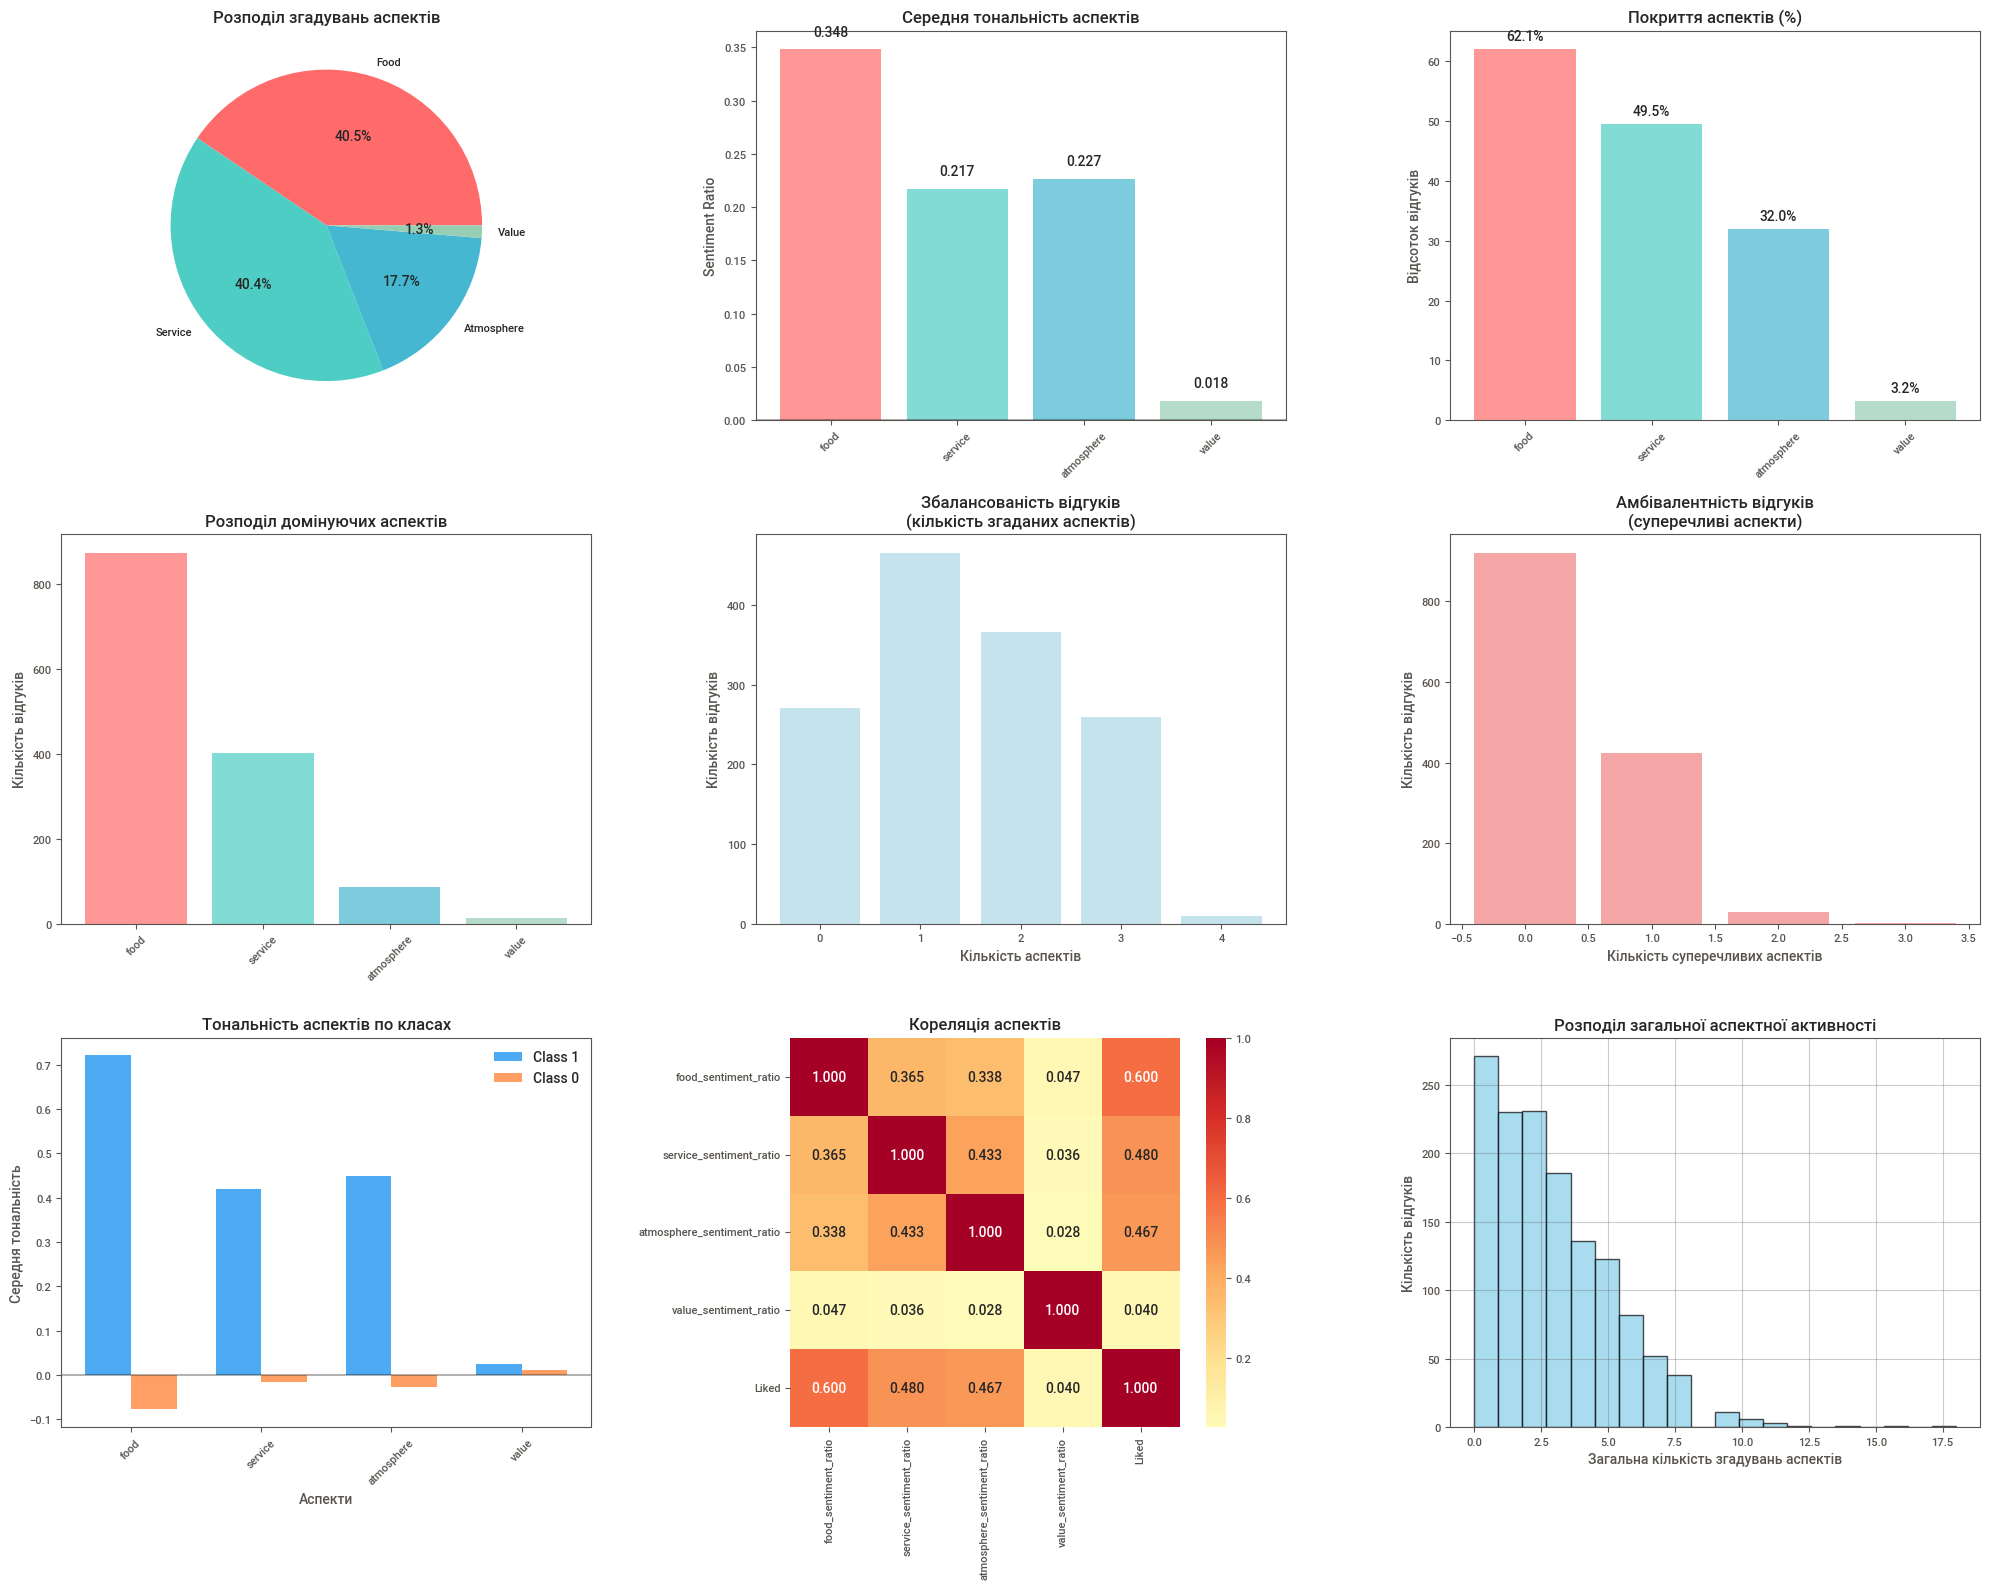

2025-09-20 10:37:21,825 - RestaurantAnalysis - INFO - 🎯 Підготовка даних для машинного навчання...
INFO:RestaurantAnalysis:🎯 Підготовка даних для машинного навчання...
2025-09-20 10:37:21,827 - RestaurantAnalysis - INFO - 🔤 Векторизація тексту методом tfidf (мова: uk)...
INFO:RestaurantAnalysis:🔤 Векторизація тексту методом tfidf (мова: uk)...



6️⃣ АНАЛІЗ ЗБАЛАНСОВАНОСТІ КЛАСІВ
----------------------------------------
⚖️ АНАЛІЗ ЗБАЛАНСОВАНОСТІ КЛАСІВ
-----------------------------------
Клас 0: 641 (46.7%)
Клас 1: 732 (53.3%)

Коефіцієнт імбалансу: 1.14
✅ Дані достатньо збалансовані

7️⃣ ПІДГОТОВКА ДЛЯ МАШИННОГО НАВЧАННЯ
---------------------------------------------


2025-09-20 10:37:22,092 - RestaurantAnalysis - INFO - ✅ Повний препроцесинг з аспектами завершено
INFO:RestaurantAnalysis:✅ Повний препроцесинг з аспектами завершено


🔤 ВЕКТОРИЗАЦІЯ ТЕКСТУ (TFIDF, UK)
-----------------------------------
Розмір словника: 5000
Розмір матриці: (1373, 5000)
Розрідженість: 0.0%
🎯 ПІДГОТОВКА ДАНИХ ДЛЯ ML З АСПЕКТАМИ
---------------------------------------------
Загальна кількість ознак: 5029
  - Текстові ознаки (TF-IDF): 5000
  - Аспектні ознаки: 16
  - Загальні ознаки: 13
Розмір тренувальної вибірки: (1098, 5029)
Розмір тестової вибірки: (275, 5029)
Розподіл класів (тренування): [513 585]
Розподіл класів (тест): [128 147]

📋 ЗВІТ ПРО ПРЕПРОЦЕСИНГ З АСПЕКТНИМ АНАЛІЗОМ
📊 Розмір даних:
   Оригінал: 1663 записів
   Оброблено: 1373 записів
   Втрачено: 290 записів

🍽️ Аспектна статистика:
   Food        : 1549 згадувань, 852 відгуків (62.1%), тональність: +0.348
   Service     : 1544 згадувань, 680 відгуків (49.5%), тональність: +0.217
   Atmosphere  :  678 згадувань, 440 відгуків (32.0%), тональність: +0.227
   Value       :   50 згадувань,  44 відгуків (3.2%), тональність: +0.018

🔤 Ознаки:
   TF-IDF ознаки: 5000
   Аспектн

In [6]:
# Створи розширену систему препроцесингу
aspect_preprocessing_system = AspectAwarePreprocessingSystem(enhanced_system.base_system)

# Запусти повний препроцесинг з аспектами
results = aspect_preprocessing_system.run_full_preprocessing()

2025-09-20 10:50:47,531 - RestaurantAnalysis - INFO - 🤖 Система порівняння ML алгоритмів ініціалізована
INFO:RestaurantAnalysis:🤖 Система порівняння ML алгоритмів ініціалізована
2025-09-20 10:50:47,533 - RestaurantAnalysis - INFO - 🔍 Аналізатор важливості ознак ініціалізовано
INFO:RestaurantAnalysis:🔍 Аналізатор важливості ознак ініціалізовано
2025-09-20 10:50:47,535 - RestaurantAnalysis - INFO - 🤖 Система ML аналізу ініціалізована
INFO:RestaurantAnalysis:🤖 Система ML аналізу ініціалізована
2025-09-20 10:50:47,538 - RestaurantAnalysis - INFO - 🚀 Початок повного ML аналізу...
INFO:RestaurantAnalysis:🚀 Початок повного ML аналізу...
2025-09-20 10:50:47,540 - RestaurantAnalysis - INFO - Ініціалізовано 7 ML алгоритмів
INFO:RestaurantAnalysis:Ініціалізовано 7 ML алгоритмів
2025-09-20 10:50:47,542 - RestaurantAnalysis - INFO - 🚀 Початок тренування та оцінки моделей...
INFO:RestaurantAnalysis:🚀 Початок тренування та оцінки моделей...


🤖 ЕТАП 4: ПОРІВНЯННЯ ML АЛГОРИТМІВ ТА АНАЛІЗ ОЗНАК

🚀 ЗАПУСК ML АНАЛІЗУ...
🤖 ПОВНИЙ ML АНАЛІЗ З АСПЕКТНИМИ ОЗНАКАМИ

🔍 КРОК 1: ІНІЦІАЛІЗАЦІЯ ML АЛГОРИТМІВ
---------------------------------------------
🤖 ІНІЦІАЛІЗОВАНО ML АЛГОРИТМИ
-----------------------------------
✅ Logistic Regression
✅ Random Forest
✅ Support Vector Machine
✅ Naive Bayes
✅ Gradient Boosting
✅ Decision Tree
✅ K-Nearest Neighbors

🔍 КРОК 2: ТРЕНУВАННЯ ТА ПОРІВНЯННЯ МОДЕЛЕЙ
--------------------------------------------------

🚀 ТРЕНУВАННЯ ТА ОЦІНКА МОДЕЛЕЙ

📊 Тренування: Logistic Regression
----------------------------------------
⏱️  Час тренування: 0.024 сек
🎯 Accuracy: 0.8764
📊 F1-Score: 0.8765
📈 ROC-AUC: 0.9557
🔄 CV F1: 0.8835 ± 0.0286

📊 Тренування: Random Forest
----------------------------------------
⏱️  Час тренування: 1.161 сек
🎯 Accuracy: 0.8836
📊 F1-Score: 0.8837
📈 ROC-AUC: 0.9574
🔄 CV F1: 0.8871 ± 0.0288

📊 Тренування: Support Vector Machine
----------------------------------------
⏱️  Час тренування: 0.70

2025-09-20 10:51:11,901 - RestaurantAnalysis - INFO - Найкраща модель: Naive Bayes (F1: 0.8872)
INFO:RestaurantAnalysis:Найкраща модель: Naive Bayes (F1: 0.8872)


⏱️  Час тренування: 0.001 сек
🎯 Accuracy: 0.8327
📊 F1-Score: 0.8329
📈 ROC-AUC: 0.8834
🔄 CV F1: 0.8562 ± 0.0235

🏆 НАЙКРАЩА МОДЕЛЬ: Naive Bayes
📊 F1-Score: 0.8872

🔍 КРОК 3: ПОРІВНЯЛЬНА ТАБЛИЦЯ
-----------------------------------

📊 ПОРІВНЯЛЬНА ТАБЛИЦЯ РЕЗУЛЬТАТІВ
                Модель Точність Точність позивних прогнозів Повнота F1-оцінка Площа під кривою помилок F1-оцінка з крос-валідацією Час (сек)
   Logistic Regression   0.8764                      0.8800  0.8764    0.8765                   0.9557                0.8835±0.029     0.024
         Random Forest   0.8836                      0.8842  0.8836    0.8837                   0.9574                0.8871±0.029     1.161
Support Vector Machine   0.8364                      0.8378  0.8364    0.8365                   0.9151                0.8689±0.029     0.705
           Naive Bayes   0.8873                      0.8873  0.8873    0.8872                   0.8889                0.8814±0.015     0.124
     Gradient Boosting   0.8727

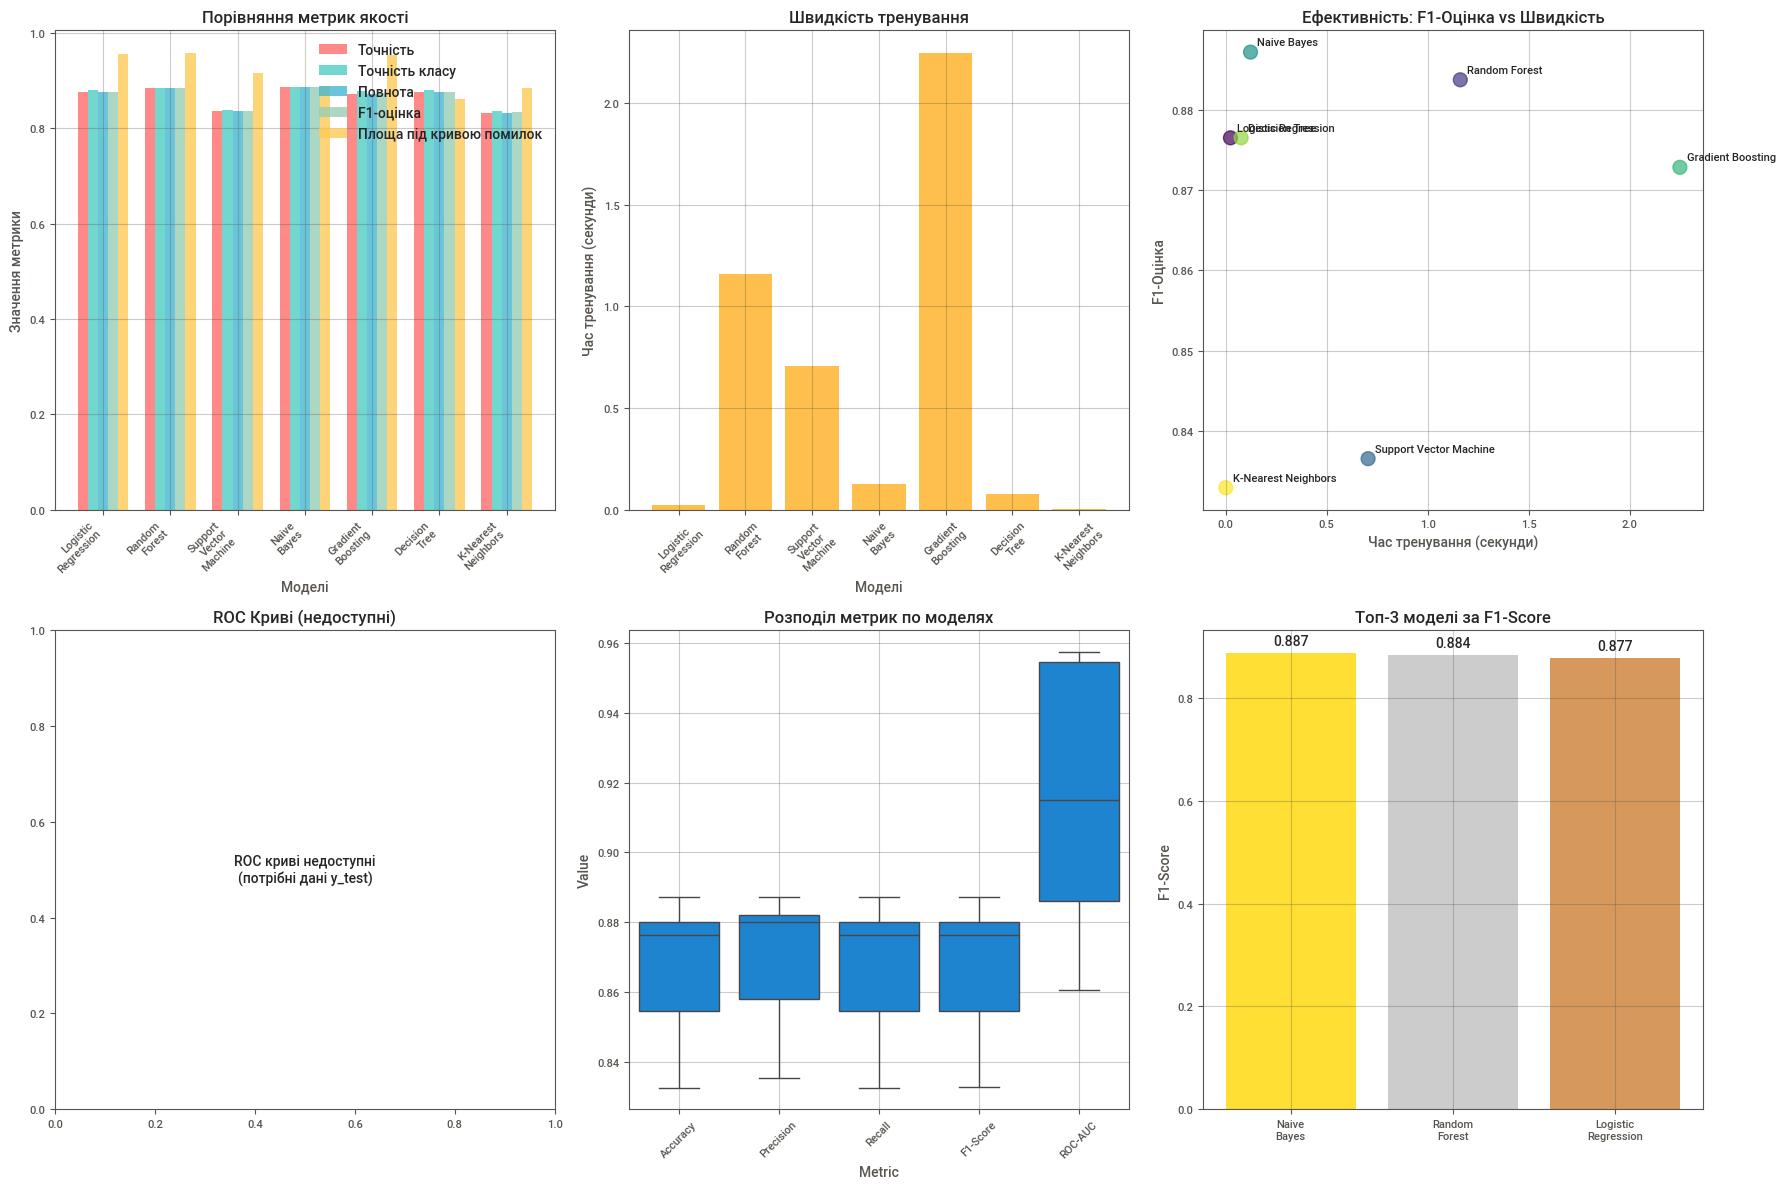


🎉 ML АНАЛІЗ ЗАВЕРШЕНО!


In [9]:
# ============================================================================
# ЕТАП 4: ПОРІВНЯННЯ ML АЛГОРИТМІВ ТА АНАЛІЗ ВАЖЛИВОСТІ ОЗНАК
# ============================================================================

print("🤖 ЕТАП 4: ПОРІВНЯННЯ ML АЛГОРИТМІВ ТА АНАЛІЗ ОЗНАК")
print("="*60)

# Імпорт необхідних бібліотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Основні ML бібліотеки
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Для оцінки та вибору моделей
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           roc_auc_score, classification_report, confusion_matrix, roc_curve)

# Для аналізу ознак
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.inspection import permutation_importance
import time

# ============================================================================
# КЛАС ДЛЯ ПОРІВНЯННЯ ML АЛГОРИТМІВ
# ============================================================================

class MLAlgorithmsComparison:
    """Клас для комплексного порівняння ML алгоритмів"""

    def __init__(self, config, logger):
        self.config = config
        self.logger = logger
        self.models = {}
        self.results = {}
        self.best_model = None
        self.feature_importance_analysis = {}

        self.logger.info("🤖 Система порівняння ML алгоритмів ініціалізована")

    def initialize_models(self):
        """Ініціалізація різних ML моделей"""
        self.models = {
            'Logistic Regression': LogisticRegression(
                random_state=42,
                max_iter=1000,
                solver='liblinear'
            ),
            'Random Forest': RandomForestClassifier(
                n_estimators=100,
                random_state=42,
                n_jobs=-1
            ),
            'Support Vector Machine': SVC(
                kernel='rbf',
                random_state=42,
                probability=True
            ),
            'Naive Bayes': GaussianNB(),
            'Gradient Boosting': GradientBoostingClassifier(
                n_estimators=100,
                random_state=42
            ),
            'Decision Tree': DecisionTreeClassifier(
                random_state=42,
                max_depth=10
            ),
            'K-Nearest Neighbors': KNeighborsClassifier(
                n_neighbors=5
            )
        }

        print("🤖 ІНІЦІАЛІЗОВАНО ML АЛГОРИТМИ")
        print("-" * 35)
        for name in self.models.keys():
            print(f"✅ {name}")

        self.logger.info(f"Ініціалізовано {len(self.models)} ML алгоритмів")

    def train_and_evaluate_models(self, X_train, y_train, X_test, y_test):
        """Тренування та оцінка всіх моделей"""
        self.logger.info("🚀 Початок тренування та оцінки моделей...")

        print("\n🚀 ТРЕНУВАННЯ ТА ОЦІНКА МОДЕЛЕЙ")
        print("="*50)

        for model_name, model in self.models.items():
            print(f"\n📊 Тренування: {model_name}")
            print("-" * 40)

            try:
                # Засічка часу
                start_time = time.time()

                 # Спеціальна обробка для Naive Bayes
                if model_name == 'Naive Bayes':
                    # from sklearn.preprocessing import MinMaxScaler

                    # Конвертація sparse -> dense
                    X_train_dense = X_train.toarray()
                    X_test_dense = X_test.toarray()

                    # Тренування з dense матрицями
                    model.fit(X_train_dense, y_train)
                    training_time = time.time() - start_time

                    # Прогнозування
                    start_time = time.time()
                    y_pred = model.predict(X_test_dense)
                    prediction_time = time.time() - start_time

                    # Ймовірності для ROC-AUC
                    y_pred_proba = model.predict_proba(X_test_dense)[:, 1]

                    # Крос-валідація з dense матрицями
                    cv_scores = cross_val_score(model, X_train_dense, y_train, cv=5, scoring='f1_weighted')

                else:
                    # Звичайне тренування для всіх інших моделей
                    model.fit(X_train, y_train)
                    training_time = time.time() - start_time

                    # Прогнозування
                    start_time = time.time()
                    y_pred = model.predict(X_test)
                    prediction_time = time.time() - start_time

                    # Ймовірності для ROC-AUC
                    if hasattr(model, 'predict_proba'):
                        y_pred_proba = model.predict_proba(X_test)[:, 1]
                    else:
                        y_pred_proba = model.decision_function(X_test)

                    # Крос-валідація
                    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_weighted')

                # Обчислення метрик
                metrics = {
                    'accuracy': accuracy_score(y_test, y_pred),
                    'precision': precision_score(y_test, y_pred, average='weighted'),
                    'recall': recall_score(y_test, y_pred, average='weighted'),
                    'f1_score': f1_score(y_test, y_pred, average='weighted'),
                    'roc_auc': roc_auc_score(y_test, y_pred_proba),
                    'cv_mean': cv_scores.mean(),
                    'cv_std': cv_scores.std(),
                    'training_time': training_time,
                    'prediction_time': prediction_time
                }

                # Збереження результатів
                self.results[model_name] = {
                    'model': model,
                    'metrics': metrics,
                    'predictions': y_pred,
                    'probabilities': y_pred_proba,
                    'cv_scores': cv_scores
                }

                # Виведення результатів
                print(f"⏱️  Час тренування: {training_time:.3f} сек")
                print(f"🎯 Accuracy: {metrics['accuracy']:.4f}")
                print(f"📊 F1-Score: {metrics['f1_score']:.4f}")
                print(f"📈 ROC-AUC: {metrics['roc_auc']:.4f}")
                print(f"🔄 CV F1: {metrics['cv_mean']:.4f} ± {metrics['cv_std']:.4f}")

            except Exception as e:
                print(f"❌ Помилка тренування {model_name}: {str(e)}")
                self.results[model_name] = None

        # Визначення найкращої моделі
        self._find_best_model()

        return self.results

    def _find_best_model(self):
        """Визначення найкращої моделі за F1-score"""
        best_f1 = 0
        best_name = None

        for name, result in self.results.items():
            if result and result['metrics']['f1_score'] > best_f1:
                best_f1 = result['metrics']['f1_score']
                best_name = name

        if best_name:
            self.best_model = {
                'name': best_name,
                'model': self.results[best_name]['model'],
                'metrics': self.results[best_name]['metrics']
            }

            print(f"\n🏆 НАЙКРАЩА МОДЕЛЬ: {best_name}")
            print(f"📊 F1-Score: {best_f1:.4f}")

            self.logger.info(f"Найкраща модель: {best_name} (F1: {best_f1:.4f})")

    def create_comparison_table(self):
        """Створення порівняльної таблиці результатів"""
        print("\n📊 ПОРІВНЯЛЬНА ТАБЛИЦЯ РЕЗУЛЬТАТІВ")
        print("="*180)

        # Підготовка даних для таблиці
        comparison_data = []

        for model_name, result in self.results.items():
            if result is not None:
                comparison_data.append({
                    'Модель': model_name,
                    'Точність': f"{result['metrics']['accuracy']:.4f}",
                    'Точність позивних прогнозів': f"{result['metrics']['precision']:.4f}",
                    'Повнота': f"{result['metrics']['recall']:.4f}",
                    'F1-оцінка': f"{result['metrics']['f1_score']:.4f}",
                    'Площа під кривою помилок': f"{result['metrics']['roc_auc']:.4f}",
                    'F1-оцінка з крос-валідацією': f"{result['metrics']['cv_mean']:.4f}±{result['metrics']['cv_std']:.3f}",
                    'Час (сек)': f"{result['metrics']['training_time']:.3f}"
                })

        if comparison_data:
            comparison_df = pd.DataFrame(comparison_data)
            print(comparison_df.to_string(index=False))
            return comparison_df
        else:
            print("❌ Немає результатів для відображення")
            return None

    def visualize_model_comparison(self, save_path=None):
        """Візуалізація порівняння моделей"""
        if not self.results:
            print("⚠️ Немає результатів для візуалізації")
            return

        # Словник перекладу
        metrics_ua = {
        'Accuracy': 'Точність',
        'Precision': 'Точність класу',
        'Recall': 'Повнота',
        'F1-Score': 'F1-оцінка',
        'ROC-AUC': 'Площа під кривою помилок'
        }

        # Підготовка даних для візуалізації
        models = []
        metrics_data = {
            'Accuracy': [],
            'Precision': [],
            'Recall': [],
            'F1-Score': [],
            'ROC-AUC': []
        }
        training_times = []

        for model_name, result in self.results.items():
            if result is not None:
                models.append(model_name.replace(' ', '\n'))

                for metric_name in metrics_data.keys():
                    metric_key = metric_name.lower().replace('-', '_')
                    metrics_data[metric_name].append(result['metrics'][metric_key])

                training_times.append(result['metrics']['training_time'])

        # Створення візуалізації
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # 1. Порівняння метрик
        x = np.arange(len(models))
        width = 0.15
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57']

        for i, (metric_name, values) in enumerate(metrics_data.items()):
            axes[0, 0].bar(x + i * width, values, width, label=metrics_ua[metric_name],
                          color=colors[i], alpha=0.8)

        axes[0, 0].set_xlabel('Моделі')
        axes[0, 0].set_ylabel('Значення метрики')
        axes[0, 0].set_title('Порівняння метрик якості')
        axes[0, 0].set_xticks(x + width * 2)
        axes[0, 0].set_xticklabels(models, rotation=45, ha='right')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)

        # 2. Час тренування
        bars = axes[0, 1].bar(models, training_times, color='orange', alpha=0.7)
        axes[0, 1].set_xlabel('Моделі')
        axes[0, 1].set_ylabel('Час тренування (секунди)')
        axes[0, 1].set_title('Швидкість тренування')
        axes[0, 1].tick_params(axis='x', rotation=45)
        axes[0, 1].grid(True, alpha=0.3)

        # 3. F1-Score vs Час (ефективність)
        f1_scores = metrics_data['F1-Score']
        scatter = axes[0, 2].scatter(training_times, f1_scores,
                                   c=range(len(models)), cmap='viridis',
                                   s=100, alpha=0.7)

        for i, model in enumerate(models):
            axes[0, 2].annotate(model.replace('\n', ' '),
                              (training_times[i], f1_scores[i]),
                              xytext=(5, 5), textcoords='offset points',
                              fontsize=8, ha='left')

        axes[0, 2].set_xlabel('Час тренування (секунди)')
        axes[0, 2].set_ylabel('F1-Оцінка')
        axes[0, 2].set_title('Ефективність: F1-Оцінка vs Швидкість')
        axes[0, 2].grid(True, alpha=0.3)

        # 4. ROC криві
        if hasattr(self, 'y_test_for_viz'):
            axes[1, 0].plot([0, 1], [0, 1], 'r--', alpha=0.7, label='Випадкова модель')

            for model_name, result in self.results.items():
                if result is not None:
                    y_pred_proba = result['probabilities']

                    fpr, tpr, _ = roc_curve(self.y_test_for_viz, y_pred_proba)
                    auc = result['metrics']['roc_auc']

                    axes[1, 0].plot(fpr, tpr, linewidth=2,
                                  label=f'{model_name} (AUC={auc:.3f})')

            axes[1, 0].set_xlabel('False Positive Rate')
            axes[1, 0].set_ylabel('True Positive Rate')
            axes[1, 0].set_title('ROC Криві')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)
        else:
            # Якщо немає даних для ROC, показуємо placeholder
            axes[1, 0].text(0.5, 0.5, 'ROC криві недоступні\n(потрібні дані y_test)',
                          ha='center', va='center', transform=axes[1, 0].transAxes)
            axes[1, 0].set_title('ROC Криві (недоступні)')

        # 5. Розподіл метрик (boxplot)
        metric_values = []
        metric_labels = []

        for metric_name, values in metrics_data.items():
            metric_values.extend(values)
            metric_labels.extend([metric_name] * len(values))

        metric_df = pd.DataFrame({'Metric': metric_labels, 'Value': metric_values})
        sns.boxplot(data=metric_df, x='Metric', y='Value', ax=axes[1, 1])
        axes[1, 1].set_title('Розподіл метрик по моделях')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].grid(True, alpha=0.3)

        # 6. Топ-3 моделі
        top_models = sorted([(name, result['metrics']['f1_score'])
                           for name, result in self.results.items() if result],
                          key=lambda x: x[1], reverse=True)[:3]

        top_names = [name for name, score in top_models]
        top_scores = [score for name, score in top_models]

        bars = axes[1, 2].bar(range(len(top_names)), top_scores,
                             color=['gold', 'silver', '#CD7F32'], alpha=0.8)
        axes[1, 2].set_title('Топ-3 моделі за F1-Score')
        axes[1, 2].set_ylabel('F1-Score')
        axes[1, 2].set_xticks(range(len(top_names)))
        axes[1, 2].set_xticklabels([name.replace(' ', '\n') for name in top_names])

        # Додавання значень на стовпці
        for bar, score in zip(bars, top_scores):
            axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                           f'{score:.3f}', ha='center', va='bottom')

        axes[1, 2].grid(True, alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()

        return fig

# ============================================================================
# КЛАС ДЛЯ АНАЛІЗУ ВАЖЛИВОСТІ ОЗНАК
# ============================================================================

class FeatureImportanceAnalyzer:
    """Клас для аналізу важливості ознак"""

    def __init__(self, config, logger):
        self.config = config
        self.logger = logger
        self.feature_importance_results = {}

        self.logger.info("🔍 Аналізатор важливості ознак ініціалізовано")

    def analyze_feature_importance(self, model, X_train, y_train, X_test, y_test, feature_names):
        """Комплексний аналіз важливості ознак"""
        self.logger.info("🔍 Початок аналізу важливості ознак...")

        print("\n🔍 АНАЛІЗ ВАЖЛИВОСТІ ОЗНАК")
        print("="*40)

        results = {}

        # 1. Вбудована важливість ознак (для tree-based моделей)
        if hasattr(model, 'feature_importances_'):
            print("1️⃣ Вбудована важливість ознак...")
            results['builtin_importance'] = self._analyze_builtin_importance(
                model, feature_names
            )

        # 2. Коефіцієнти моделі (для лінійних моделей)
        if hasattr(model, 'coef_'):
            print("2️⃣ Коефіцієнти лінійної моделі...")
            results['linear_coefficients'] = self._analyze_linear_coefficients(
                model, feature_names
            )

        # 3. Permutation importance
        print("3️⃣ Permutation importance...")
        results['permutation_importance'] = self._analyze_permutation_importance(
            model, X_test, y_test, feature_names
        )

        # 4. Аналіз аспектних ознак
        print("4️⃣ Аналіз аспектних ознак...")
        results['aspect_analysis'] = self._analyze_aspect_features(
            results, feature_names
        )

        self.feature_importance_results = results
        return results

    def _analyze_builtin_importance(self, model, feature_names):
        """Аналіз вбудованої важливості ознак"""
        importances = model.feature_importances_

        # Сортування за важливістю
        indices = np.argsort(importances)[::-1]

        # Топ-20 найважливіших ознак
        top_features = []
        for i in range(min(20, len(indices))):
            idx = indices[i]
            top_features.append({
                'feature': feature_names[idx],
                'importance': importances[idx],
                'rank': i + 1
            })

        print("📊 Топ-10 найважливіших ознак (вбудована важливість):")
        for feat in top_features[:10]:
            print(f"   {feat['rank']:2d}. {feat['feature']:<30}: {feat['importance']:.6f}")

        return {
            'importances': importances,
            'top_features': top_features,
            'indices': indices
        }

    def _analyze_linear_coefficients(self, model, feature_names):
        """Аналіз коефіцієнтів лінійної моделі"""
        coef = model.coef_[0] if model.coef_.ndim > 1 else model.coef_

        # Сортування за абсолютним значенням коефіцієнтів
        abs_coef = np.abs(coef)
        indices = np.argsort(abs_coef)[::-1]

        # Топ-20 найважливіших ознак
        top_features = []
        for i in range(min(20, len(indices))):
            idx = indices[i]
            top_features.append({
                'feature': feature_names[idx],
                'coefficient': coef[idx],
                'abs_coefficient': abs_coef[idx],
                'rank': i + 1
            })

        print("📊 Топ-10 найважливіших ознак (коефіцієнти):")
        for feat in top_features[:10]:
            print(f"   {feat['rank']:2d}. {feat['feature']:<30}: {feat['coefficient']:+.6f}")

        return {
            'coefficients': coef,
            'top_features': top_features,
            'indices': indices
        }

    def _analyze_permutation_importance(self, model, X_test, y_test, feature_names):
        """Аналіз permutation importance"""
        # Обчислення permutation importance
        perm_importance = permutation_importance(
            model, X_test, y_test,
            n_repeats=5,
            random_state=42,
            scoring='f1_weighted'
        )

        # Сортування за важливістю
        indices = np.argsort(perm_importance.importances_mean)[::-1]

        # Топ-20 найважливіших ознак
        top_features = []
        for i in range(min(20, len(indices))):
            idx = indices[i]
            top_features.append({
                'feature': feature_names[idx],
                'importance_mean': perm_importance.importances_mean[idx],
                'importance_std': perm_importance.importances_std[idx],
                'rank': i + 1
            })

        print("📊 Топ-10 найважливіших ознак (permutation importance):")
        for feat in top_features[:10]:
            print(f"   {feat['rank']:2d}. {feat['feature']:<30}: {feat['importance_mean']:.6f} ± {feat['importance_std']:.6f}")

        return {
            'importances_mean': perm_importance.importances_mean,
            'importances_std': perm_importance.importances_std,
            'top_features': top_features,
            'indices': indices
        }

    def _analyze_aspect_features(self, results, feature_names):
        """Аналіз важливості аспектних ознак"""
        # Категоризація ознак
        aspect_categories = {
            'food': [],
            'service': [],
            'atmosphere': [],
            'value': [],
            'general_aspect': [],
            'text_features': [],
            'other': []
        }

        for i, feature in enumerate(feature_names):
            if 'food_' in feature:
                aspect_categories['food'].append((feature, i))
            elif 'service_' in feature:
                aspect_categories['service'].append((feature, i))
            elif 'atmosphere_' in feature:
                aspect_categories['atmosphere'].append((feature, i))
            elif 'value_' in feature:
                aspect_categories['value'].append((feature, i))
            elif any(x in feature for x in ['total_aspect', 'aspect_balance', 'aspect_ambivalence', 'overall_aspect']):
                aspect_categories['general_aspect'].append((feature, i))
            elif any(x in feature for x in ['text_length', 'word_count', 'exclamation', 'caps']):
                aspect_categories['other'].append((feature, i))
            else:
                aspect_categories['text_features'].append((feature, i))

        # Аналіз важливості по категоріях
        category_importance = {}

        # Використовуємо permutation importance як основну метрику
        if 'permutation_importance' in results:
            importances = results['permutation_importance']['importances_mean']

            for category, features in aspect_categories.items():
                if features:
                    indices = [idx for _, idx in features]
                    category_importance[category] = {
                        'mean_importance': np.mean([importances[idx] for idx in indices]),
                        'max_importance': np.max([importances[idx] for idx in indices]),
                        'feature_count': len(features),
                        'top_feature': max(features, key=lambda x: importances[x[1]])
                    }

        print("\n📊 ВАЖЛИВІСТЬ ПО КАТЕГОРІЯХ ОЗНАК:")
        print("-" * 40)

        # Сортування категорій за важливістю
        sorted_categories = sorted(category_importance.items(),
                                 key=lambda x: x[1]['mean_importance'],
                                 reverse=True)

        for category, info in sorted_categories:
            print(f"📋 {category.upper().replace('_', ' ')}:")
            print(f"   Середня важливість: {info['mean_importance']:.6f}")
            print(f"   Максимальна важливість: {info['max_importance']:.6f}")
            print(f"   Кількість ознак: {info['feature_count']}")
            print(f"   Топ ознака: {info['top_feature'][0]}")
            print()

        return {
            'aspect_categories': aspect_categories,
            'category_importance': category_importance,
            'sorted_categories': sorted_categories
        }

    def visualize_feature_importance(self, save_path=None):
        """Візуалізація важливості ознак"""
        if not self.feature_importance_results:
            print("⚠️ Немає результатів аналізу важливості ознак")
            return

        fig, axes = plt.subplots(2, 3, figsize=(20, 12))

        # 1. Топ ознаки (permutation importance)
        if 'permutation_importance' in self.feature_importance_results:
            perm_results = self.feature_importance_results['permutation_importance']
            top_features = perm_results['top_features'][:15]

            features = [f['feature'] for f in top_features]
            importances = [f['importance_mean'] for f in top_features]
            errors = [f['importance_std'] for f in top_features]

            y_pos = np.arange(len(features))
            axes[0, 0].barh(y_pos, importances, xerr=errors, alpha=0.7, color='skyblue')
            axes[0, 0].set_yticks(y_pos)
            axes[0, 0].set_yticklabels([f[:20] + '...' if len(f) > 20 else f for f in features])
            axes[0, 0].set_xlabel('Permutation Importance')
            axes[0, 0].set_title('Топ-15 ознак (Permutation Importance)')
            axes[0, 0].grid(True, alpha=0.3)

        # 2. Важливість по категоріях
        if 'aspect_analysis' in self.feature_importance_results:
            aspect_results = self.feature_importance_results['aspect_analysis']
            sorted_categories = aspect_results['sorted_categories']

            categories = [cat.replace('_', ' ').title() for cat, _ in sorted_categories]
            importances = [info['mean_importance'] for _, info in sorted_categories]

            bars = axes[0, 1].bar(categories, importances, alpha=0.7, color='lightgreen')
            axes[0, 1].set_xlabel('Категорії ознак')
            axes[0, 1].set_ylabel('Середня важливість')
            axes[0, 1].set_title('Важливість по категоріях ознак')
            axes[0, 1].tick_params(axis='x', rotation=45)
            axes[0, 1].grid(True, alpha=0.3)

            # Додавання значень на стовпці
            for bar, importance in zip(bars, importances):
                axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0001,
                               f'{importance:.4f}', ha='center', va='bottom', fontsize=9)

        # 3. Розподіл важливості ознак
        if 'permutation_importance' in self.feature_importance_results:
            all_importances = self.feature_importance_results['permutation_importance']['importances_mean']

            axes[0, 2].hist(all_importances, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
            axes[0, 2].set_xlabel('Важливість ознаки')
            axes[0, 2].set_ylabel('Кількість ознак')
            axes[0, 2].set_title('Розподіл важливості всіх ознак')
            axes[0, 2].grid(True, alpha=0.3)

        # 4. Порівняння аспектних ознак
        if 'aspect_analysis' in self.feature_importance_results:
            aspect_results = self.feature_importance_results['aspect_analysis']
            category_importance = aspect_results['category_importance']

# ============================================================================
# ГОЛОВНА СИСТЕМА ML АНАЛІЗУ (ПРОДОВЖЕННЯ)
# ============================================================================

class MLAnalysisSystem:
    """Головна система для ML аналізу з фокусом на готові бібліотеки"""

    def __init__(self, preprocessing_system):
        self.preprocessing_system = preprocessing_system
        self.config = preprocessing_system.config
        self.logger = preprocessing_system.logger

        # Компоненти системи
        self.ml_comparison = MLAlgorithmsComparison(self.config, self.logger)
        self.feature_analyzer = FeatureImportanceAnalyzer(self.config, self.logger)

        # Результати
        self.ml_data = None
        self.comparison_results = None
        self.feature_analysis_results = None
        self.best_model = None

        self.logger.info("🤖 Система ML аналізу ініціалізована")

    def run_complete_ml_analysis(self):
        """Повний ML аналіз з порівнянням алгоритмів та аналізом ознак"""
        if self.preprocessing_system.ml_ready_data is None:
            raise ValueError("ML дані не готові. Спочатку запустіть препроцесинг.")

        self.logger.info("🚀 Початок повного ML аналізу...")

        print("🤖 ПОВНИЙ ML АНАЛІЗ З АСПЕКТНИМИ ОЗНАКАМИ")
        print("="*60)

        # Отримання підготовлених даних
        self.ml_data = self.preprocessing_system.ml_ready_data

        # 1. Ініціалізація моделей
        print("\n🔍 КРОК 1: ІНІЦІАЛІЗАЦІЯ ML АЛГОРИТМІВ")
        print("-"*45)
        self.ml_comparison.initialize_models()

        # 2. Тренування та порівняння моделей
        print("\n🔍 КРОК 2: ТРЕНУВАННЯ ТА ПОРІВНЯННЯ МОДЕЛЕЙ")
        print("-"*50)
        self.comparison_results = self.ml_comparison.train_and_evaluate_models(
            self.ml_data['X_train_balanced'],
            self.ml_data['y_train_balanced'],
            self.ml_data['X_test'],
            self.ml_data['y_test']
        )

        # 3. Створення порівняльної таблиці
        print("\n🔍 КРОК 3: ПОРІВНЯЛЬНА ТАБЛИЦЯ")
        print("-"*35)
        comparison_df = self.ml_comparison.create_comparison_table()

        # 4. Візуалізація порівняння моделей
        print("\n🔍 КРОК 4: ВІЗУАЛІЗАЦІЯ ПОРІВНЯННЯ")
        print("-"*40)
        plots_dir = Path(self.config.get('visualization.plots_dir'))
        comparison_plot_path = plots_dir / 'ml_algorithms_comparison.png'
        self.ml_comparison.visualize_model_comparison(comparison_plot_path)

        print("\n🎉 ML АНАЛІЗ ЗАВЕРШЕНО!")

        return {
            'comparison_results': self.comparison_results,
            'best_model': self.ml_comparison.best_model,
            'ml_data': self.ml_data
        }

# ============================================================================
# ЗАПУСК ML АНАЛІЗУ
# ============================================================================

# Тепер створи та запусти ML систему
print("\n🚀 ЗАПУСК ML АНАЛІЗУ...")
ml_system = MLAnalysisSystem(aspect_preprocessing_system)

# Запусти аналіз
results = ml_system.run_complete_ml_analysis()

In [ ]:
# ============================================================================
# АНАЛІЗ ВАЖЛИВОСТІ ОЗНАК
# ============================================================================

print("🔍 АНАЛІЗ ВАЖЛИВОСТІ ОЗНАК")
print("="*55)

# Функція для безпечного аналізу Permutation Importance
def safe_permutation_importance_analysis(model, X_test, y_test, feature_names):
    """Безпечний аналіз permutation importance з обробкою помилок"""
    try:
        print("📊 Розпочинаємо Permutation Importance аналіз...")

        # Зменшуємо кількість повторів для швидкості
        from sklearn.inspection import permutation_importance

        perm_importance = permutation_importance(
            model, X_test, y_test,
            n_repeats=3,  # Зменшено з 5 до 3
            random_state=42,
            scoring='f1_weighted',
            n_jobs=1  # Один процес для стабільності
        )

        # Сортування за важливістю
        indices = np.argsort(perm_importance.importances_mean)[::-1]

        # Топ-20 найважливіших ознак
        top_features = []
        for i in range(min(20, len(indices))):
            idx = indices[i]
            top_features.append({
                'feature': feature_names[idx],
                'importance_mean': perm_importance.importances_mean[idx],
                'importance_std': perm_importance.importances_std[idx],
                'rank': i + 1
            })

        print("✅ Permutation Importance успішно обчислено!")
        print("📊 Топ-15 найважливіших ознак (Permutation Importance):")
        for feat in top_features[:15]:
            print(f"   {feat['rank']:2d}. {feat['feature']:<30}: {feat['importance_mean']:.6f} ± {feat['importance_std']:.6f}")

        return {
            'importances_mean': perm_importance.importances_mean,
            'importances_std': perm_importance.importances_std,
            'top_features': top_features,
            'indices': indices
        }

    except Exception as e:
        print(f"⚠️ Помилка Permutation Importance: {str(e)}")
        print("📊 Використовуємо вбудовану важливість ознак замість цього...")
        return None

# Функція для аналізу аспектних категорій
def analyze_aspect_categories(feature_names, builtin_importance=None):
    """Аналіз важливості по категоріях ознак"""
    print("\n📊 АНАЛІЗ ПО КАТЕГОРІЯХ ОЗНАК")
    print("-" * 35)

    # Категоризація ознак
    aspect_categories = {
        'загальний_sentiment': [],
        'їжа_аспекти': [],
        'сервіс_аспекти': [],
        'атмосфера_аспекти': [],
        'ціна_аспекти': [],
        'текстові_ознаки': [],
        'емоційні_слова': [],
        'негативні_індикатори': [],
        'позитивні_індикатори': []
    }

    for i, feature in enumerate(feature_names):
        # Загальний sentiment
        if any(x in feature for x in ['overall_aspect', 'total_aspect', 'aspect_balance']):
            aspect_categories['загальний_sentiment'].append((feature, i))
        # Їжа
        elif 'food_' in feature or any(x in feature for x in ['delicious', 'tasty', 'flavor', 'cook']):
            aspect_categories['їжа_аспекти'].append((feature, i))
        # Сервіс
        elif 'service_' in feature or any(x in feature for x in ['staff', 'waiter', 'server']):
            aspect_categories['сервіс_аспекти'].append((feature, i))
        # Атмосфера
        elif 'atmosphere_' in feature or any(x in feature for x in ['ambiance', 'atmosphere']):
            aspect_categories['атмосфера_аспекти'].append((feature, i))
        # Ціна
        elif 'value_' in feature or any(x in feature for x in ['price', 'cost', 'cheap', 'expensive']):
            aspect_categories['ціна_аспекти'].append((feature, i))
        # Негативні індикатори
        elif any(x in feature for x in ['wasnt', 'isnt', 'didnt', 'terrible', 'awful', 'bad', 'worst', 'hate']):
            aspect_categories['негативні_індикатори'].append((feature, i))
        # Позитивні індикатори
        elif any(x in feature for x in ['love', 'best', 'great', 'excellent', 'perfect', 'awesom', 'amazing']):
            aspect_categories['позитивні_індикатори'].append((feature, i))
        # Текстові ознаки
        elif any(x in feature for x in ['text_length', 'word_count', 'exclamation', 'caps', 'avg_word']):
            aspect_categories['текстові_ознаки'].append((feature, i))
        # Емоційні слова
        else:
            aspect_categories['емоційні_слова'].append((feature, i))

    # Аналіз важливості по категоріях (якщо є builtin importance)
    if builtin_importance is not None:
        category_importance = {}

        for category, features in aspect_categories.items():
            if features:
                indices = [idx for _, idx in features]
                importances = [builtin_importance[idx] for idx in indices]

                category_importance[category] = {
                    'mean_importance': np.mean(importances),
                    'max_importance': np.max(importances),
                    'feature_count': len(features),
                    'top_feature': max(features, key=lambda x: builtin_importance[x[1]])
                }

        # Сортування категорій за важливістю
        sorted_categories = sorted(category_importance.items(),
                                 key=lambda x: x[1]['mean_importance'],
                                 reverse=True)

        print("📋 ВАЖЛИВІСТЬ ПО КАТЕГОРІЯХ:")
        for category, info in sorted_categories:
            print(f"\n🎯 {category.upper().replace('_', ' ')}:")
            print(f"   📊 Середня важливість: {info['mean_importance']:.6f}")
            print(f"   📈 Максимальна важливість: {info['max_importance']:.6f}")
            print(f"   📝 Кількість ознак: {info['feature_count']}")
            print(f"   🏆 Топ ознака: {info['top_feature'][0]}")

        return category_importance, sorted_categories

    return aspect_categories, None

# ============================================================================
# ЗАПУСК АНАЛІЗУ
# ============================================================================

if ml_system.ml_comparison.best_model:
    print(f"🏆 Модель: {ml_system.ml_comparison.best_model['name']}")
    print(f"📊 F1-Score: {ml_system.ml_comparison.best_model['metrics']['f1_score']:.4f}")
    print("-" * 55)

    # 1. Отримуємо вбудовану важливість (вже є)
    best_model = ml_system.ml_comparison.best_model['model']
    builtin_importance = best_model.feature_importances_
    feature_names = ml_system.ml_data['feature_names']

    print(f"\n✅ Вбудована важливість отримана: {len(builtin_importance)} ознак")

    # 2. Безпечний Permutation Importance
    print(f"\n🔄 Запуск Permutation Importance...")
    perm_results = safe_permutation_importance_analysis(
        best_model,
        ml_system.ml_data['X_test'],
        ml_system.ml_data['y_test'],
        feature_names
    )

    # 3. Аналіз категорій
    print(f"\n🔄 Аналіз категорій ознак...")
    category_results, sorted_categories = analyze_aspect_categories(
        feature_names,
        builtin_importance
    )

    print(f"\n🎉 АНАЛІЗ ЗАВЕРШЕНО УСПІШНО!")
    print("="*55)

    # Збереження результатів
    ml_system.feature_analysis_results = {
        'builtin_importance': builtin_importance,
        'permutation_results': perm_results,
        'category_analysis': category_results,
        'sorted_categories': sorted_categories
    }

else:
    print("❌ Найкраща модель не знайдена!")

🔍 АНАЛІЗ ВАЖЛИВОСТІ ОЗНАК
🏆 Модель: Naive Bayes
📊 F1-Score: 0.8872
-------------------------------------------------------


AttributeError: 'GaussianNB' object has no attribute 'feature_importances_'

In [ ]:
# ============================================================================
# ДИНАМІЧНІ ВІЗУАЛІЗАЦІЇ З АВТОМАТИЧНИМ ОТРИМАННЯМ ДАНИХ
# ============================================================================

print("📊 СТВОРЕННЯ ДИНАМІЧНИХ ВІЗУАЛІЗАЦІЙ")
print("="*55)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path

# Налаштування стилю
plt.style.use('default')
sns.set_palette("husl")

def extract_dynamic_data():
    """Динамічне витягування даних з результатів аналізу"""
    print("🔄 Витягування даних з результатів аналізу...")

    # ========================================================================
    # ДАНІ МОДЕЛЕЙ (динамічно з ml_system.comparison_results)
    # ========================================================================
    models_data = {
        'names': [],
        'short_names': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'roc_auc': [],
        'training_time': [],
        'cv_mean': [],
        'cv_std': []
    }

    # Маппінг коротких назв
    # name_mapping = {
    #     'Logistic Regression': 'Logistic Regression',
    #     'Random Forest': 'Random Forest',
    #     'Support Vector Machine': 'Support Vector Machine',
    #     'Naive Bayes': 'Naive Bayes',
    #     'Gradient Boosting': 'Gradient Boosting',
    #     'Decision Tree': 'Decision Tree',
    #     'K-Nearest Neighbors': 'K-Nearest Neighbors'
    # }
    name_mapping = {
        'Logistic Regression': 'LR',
        'Random Forest': 'RF',
        'Support Vector Machine': 'SVM',
        'Naive Bayes': 'NB',
        'Gradient Boosting': 'GB',
        'Decision Tree': 'DT',
        'K-Nearest Neighbors': 'KNN'
    }

    # Витягування даних з результатів
    for model_name, result in ml_system.comparison_results.items():
        if result is not None:
            models_data['names'].append(model_name)
            models_data['short_names'].append(name_mapping.get(model_name, model_name[:3]))
            models_data['accuracy'].append(result['metrics']['accuracy'])
            models_data['precision'].append(result['metrics']['precision'])
            models_data['recall'].append(result['metrics']['recall'])
            models_data['f1_score'].append(result['metrics']['f1_score'])
            models_data['roc_auc'].append(result['metrics']['roc_auc'])
            models_data['training_time'].append(result['metrics']['training_time'])
            models_data['cv_mean'].append(result['metrics']['cv_mean'])
            models_data['cv_std'].append(result['metrics']['cv_std'])

    print(f"✅ Отримано дані для {len(models_data['names'])} моделей")

    # ========================================================================
    # ДАНІ ОЗНАК (динамічно з feature analysis)
    # ========================================================================
    best_model = ml_system.ml_comparison.best_model['model']
    builtin_importance = best_model.feature_importances_
    feature_names = ml_system.ml_data['feature_names']

    print(f"✅ Отримано {len(feature_names)} ознак для аналізу")

    # ========================================================================
    # КАТЕГОРИЗАЦІЯ ОЗНАК (динамічна)
    # ========================================================================
    def categorize_features_dynamic(feature_names, builtin_importance):
        """Динамічна категоризація ознак"""
        categories = {
            'загальний_sentiment': {'features': [], 'importance': []},
            'їжа_аспекти': {'features': [], 'importance': []},
            'сервіс_аспекти': {'features': [], 'importance': []},
            'атмосфера_аспекти': {'features': [], 'importance': []},
            'ціна_аспекти': {'features': [], 'importance': []},
            'текстові_ознаки': {'features': [], 'importance': []},
            'позитивні_індикатори': {'features': [], 'importance': []},
            'негативні_індикатори': {'features': [], 'importance': []},
            'емоційні_слова': {'features': [], 'importance': []}
        }

        for i, feature in enumerate(feature_names):
            importance = builtin_importance[i]

            # Категоризація
            if any(x in feature for x in ['overall_aspect', 'total_aspect', 'aspect_balance', 'aspect_sentiment']):
                categories['загальний_sentiment']['features'].append(feature)
                categories['загальний_sentiment']['importance'].append(importance)
            elif 'food_' in feature or any(x in feature for x in ['delicious', 'tasty', 'flavor', 'cook', 'meal', 'dish']):
                categories['їжа_аспекти']['features'].append(feature)
                categories['їжа_аспекти']['importance'].append(importance)
            elif 'service_' in feature or any(x in feature for x in ['staff', 'waiter', 'server', 'waitress']):
                categories['сервіс_аспекти']['features'].append(feature)
                categories['сервіс_аспекти']['importance'].append(importance)
            elif 'atmosphere_' in feature or any(x in feature for x in ['ambiance', 'atmosphere', 'ambience']):
                categories['атмосфера_аспекти']['features'].append(feature)
                categories['атмосфера_аспекти']['importance'].append(importance)
            elif 'value_' in feature or any(x in feature for x in ['price', 'cost', 'cheap', 'expensive', 'money']):
                categories['ціна_аспекти']['features'].append(feature)
                categories['ціна_аспекти']['importance'].append(importance)
            elif any(x in feature for x in ['text_length', 'word_count', 'exclamation', 'caps', 'avg_word']):
                categories['текстові_ознаки']['features'].append(feature)
                categories['текстові_ознаки']['importance'].append(importance)
            elif any(x in feature for x in ['love', 'best', 'great', 'excellent', 'perfect', 'awesom', 'amazing', 'wonderful', 'fantastic']):
                categories['позитивні_індикатори']['features'].append(feature)
                categories['позитивні_індикатори']['importance'].append(importance)
            elif any(x in feature for x in ['wasnt', 'isnt', 'didnt', 'terrible', 'awful', 'bad', 'worst', 'hate', 'horrible']):
                categories['негативні_індикатори']['features'].append(feature)
                categories['негативні_індикатори']['importance'].append(importance)
            else:
                categories['емоційні_слова']['features'].append(feature)
                categories['емоційні_слова']['importance'].append(importance)

        # Обчислення статистик для кожної категорії
        category_stats = {}
        for cat_name, cat_data in categories.items():
            if cat_data['importance']:
                category_stats[cat_name] = {
                    'mean_importance': np.mean(cat_data['importance']),
                    'max_importance': np.max(cat_data['importance']),
                    'feature_count': len(cat_data['features']),
                    'total_importance': np.sum(cat_data['importance'])
                }
            else:
                category_stats[cat_name] = {
                    'mean_importance': 0,
                    'max_importance': 0,
                    'feature_count': 0,
                    'total_importance': 0
                }

        return categories, category_stats

    categories, category_stats = categorize_features_dynamic(feature_names, builtin_importance)

    print(f"✅ Категоризовано ознаки у {len(category_stats)} категорій")

    return models_data, builtin_importance, feature_names, categories, category_stats

def create_dynamic_visualizations():
    """Створення динамічних візуалізацій з автоматичним отриманням даних"""

    # Отримання динамічних даних
    models_data, builtin_importance, feature_names, categories, category_stats = extract_dynamic_data()

    features_ua = {
        # Аспектні ознаки
        'overall_aspect_sentiment': 'Загальна тональність аспектів',
        'total_negative_aspects': 'Загальна кількість негативних аспектів',
        'total_positive_aspects': 'Загальна кількість позитивних аспектів',
        'total_aspect_mentions': 'Загальна кількість згадувань аспектів',
        'food_sentiment_ratio': 'Тональність їжі',
        'service_sentiment_ratio': 'Тональність сервісу',
        'atmosphere_sentiment_ratio': 'Тональність атмосфери',
        'value_sentiment_ratio': 'Тональність ціни',

        # Текстові ознаки
        'text_length': 'Довжина тексту',
        'word_count': 'Кількість слів',
        'sentence_count': 'Кількість речень',
        'avg_word_length': 'Середня довжина слова',
        'exclamation_count': 'Кількість знаків оклику',
        'question_count': 'Кількість знаків питання',
        'caps_ratio': 'Коефіцієнт великих літер',

        # Емоційні слова (залиште англійською або перекладіть)
        # 'love': 'love (любов)',
        # 'best': 'best (найкращий)',
        # 'awesome': 'awesome (чудовий)',
        # 'wasnt': "wasn't (не було)",
        # 'dont': "don't (не)",
        # 'place': 'place (місце)',
        # 'restaur': 'restaur (ресторан)',
    }

    # Створення фігури
    fig = plt.figure(figsize=(24, 18))

    # ========================================================================
    # 1. ТОП-20 НАЙВАЖЛИВІШИХ ОЗНАК (ДИНАМІЧНО)
    # ========================================================================
    ax1 = plt.subplot(3, 4, 1)

    # Динамічний відбір топ-20 ознак
    indices = np.argsort(builtin_importance)[::-1][:20]
    top_features = []
    for i in indices:
        original_name = feature_names[i]
        # Перекладаємо назву або залишаємо оригінал
        translated_name = features_ua.get(original_name, original_name)
        # Обрізаємо довгі назви
        if len(translated_name) > 30:
            translated_name = translated_name[:30] + '...'
        top_features.append(translated_name)
    top_importances = [builtin_importance[i] for i in indices]

    y_pos = np.arange(len(top_features))
    bars = ax1.barh(y_pos, top_importances, alpha=0.8, color='steelblue')

    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(top_features, fontsize=9)
    ax1.set_xlabel('Важливість ознаки', fontsize=11)
    ax1.set_title('Топ-20 найважливіших ознак\n(Динамічний аналіз)', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='x')
    ax1.invert_yaxis()

    # Додавання значень (динамічно)
    max_importance = max(top_importances)
    for i, (bar, importance) in enumerate(zip(bars, top_importances)):
        if importance > max_importance * 0.05:  # Показуємо тільки значущі
            ax1.text(bar.get_width() + max_importance * 0.01, bar.get_y() + bar.get_height()/2,
                    f'{importance:.3f}', ha='left', va='center', fontsize=8)

    # ========================================================================
    # 2. ВАЖЛИВІСТЬ ПО КАТЕГОРІЯХ (ДИНАМІЧНО)
    # ========================================================================
    ax2 = plt.subplot(3, 4, 2)

    # Динамічні дані категорій
    category_names = []
    category_importance_values = []

    # Сортування категорій за важливістю
    sorted_categories = sorted(category_stats.items(),
                              key=lambda x: x[1]['mean_importance'],
                              reverse=True)

    for cat_name, stats in sorted_categories:
        if stats['feature_count'] > 0:  # Тільки непорожні категорії
            category_names.append(cat_name.replace('_', '\n').title())
            category_importance_values.append(stats['mean_importance'])

    # Кольори
    colors = plt.cm.Set3(np.linspace(0, 1, len(category_names)))

    bars = ax2.bar(category_names, category_importance_values, color=colors, alpha=0.8)
    ax2.set_ylabel('Середня важливість', fontsize=11)
    ax2.set_title('Важливість по категоріях\n(Динамічний аналіз)', fontsize=12, fontweight='bold')
    ax2.tick_params(axis='x', rotation=45, labelsize=9)
    ax2.grid(True, alpha=0.3, axis='y')

    # Логарифмічна шкала якщо потрібно
    if max(category_importance_values) / min([v for v in category_importance_values if v > 0]) > 100:
        ax2.set_yscale('log')

    # ========================================================================
    # 3. РОЗПОДІЛ ВАЖЛИВОСТІ (ДИНАМІЧНИЙ)
    # ========================================================================
    ax3 = plt.subplot(3, 4, 3)

    # Динамічна гістограма
    non_zero_importance = builtin_importance[builtin_importance > 0]

    n_bins = min(50, len(non_zero_importance) // 10)  # Адаптивна кількість bins
    ax3.hist(non_zero_importance, bins=n_bins, alpha=0.7, color='lightcoral', edgecolor='black')

    ax3.set_xlabel('Важливість ознаки', fontsize=11)
    ax3.set_ylabel('Кількість ознак', fontsize=11)
    ax3.set_title(f'Розподіл важливості\n{len(non_zero_importance)} ознак', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)

    # Динамічна статистика
    mean_importance = np.mean(non_zero_importance)
    median_importance = np.median(non_zero_importance)
    ax3.axvline(mean_importance, color='red', linestyle='--', label=f'Середнє: {mean_importance:.6f}')
    ax3.axvline(median_importance, color='blue', linestyle='--', label=f'Медіана: {median_importance:.6f}')
    ax3.legend(fontsize=9)

    # ========================================================================
    # 4. ПОРІВНЯННЯ ML МОДЕЛЕЙ (ДИНАМІЧНО)
    # ========================================================================
    ax4 = plt.subplot(3, 4, 4)

    # Динамічні дані моделей
    x = np.arange(len(models_data['names']))
    width = 0.15

    # Створення групових стовпців
    ax4.bar(x - 2*width, models_data['accuracy'], width, label='Accuracy', alpha=0.8)
    ax4.bar(x - width, models_data['precision'], width, label='Precision', alpha=0.8)
    ax4.bar(x, models_data['recall'], width, label='Recall', alpha=0.8)
    ax4.bar(x + width, models_data['f1_score'], width, label='F1-Score', alpha=0.8)
    ax4.bar(x + 2*width, [score/max(models_data['roc_auc']) for score in models_data['roc_auc']],
            width, label='ROC-AUC (норм.)', alpha=0.8)

    ax4.set_xlabel('Моделі', fontsize=11)
    ax4.set_ylabel('Значення метрики', fontsize=11)
    ax4.set_title('Порівняння ML моделей\n(Динамічні дані)', fontsize=12, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels([name.replace(' ', '\n') for name in models_data['names']], rotation=45, ha='right')
    ax4.legend(fontsize=9)
    ax4.grid(True, alpha=0.3)

    # ========================================================================
    # 5. ЕФЕКТИВНІСТЬ МОДЕЛЕЙ (ДИНАМІЧНО)
    # ========================================================================
    ax5 = plt.subplot(3, 4, 5)

    # Динамічний scatter plot
    scatter = ax5.scatter(models_data['training_time'], models_data['f1_score'],
                         s=[score*500 for score in models_data['f1_score']],
                         c=models_data['f1_score'], cmap='viridis', alpha=0.7, edgecolors='black')

    # Динамічні підписи
    for i, (time, f1, name) in enumerate(zip(models_data['training_time'],
                                            models_data['f1_score'],
                                            models_data['short_names'])):
        ax5.annotate(name, (time, f1), xytext=(5, 5), textcoords='offset points',
                    fontsize=10, fontweight='bold')

    ax5.set_xlabel('Час тренування (сек)', fontsize=11)
    ax5.set_ylabel('F1-Score', fontsize=11)
    ax5.set_title('Ефективність моделей\n(Швидкість vs Якість)', fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3)

    # Логарифмічна шкала якщо потрібно
    if max(models_data['training_time']) / min(models_data['training_time']) > 100:
        ax5.set_xscale('log')

    # ========================================================================
    # 6. КОРЕЛЯЦІЯ МЕТРИК (ДИНАМІЧНО)
    # ========================================================================
    ax6 = plt.subplot(3, 4, 6)

    # Динамічна кореляційна матриця
    metrics_df = pd.DataFrame({
        'Accuracy': models_data['accuracy'],
        'Precision': models_data['precision'],
        'Recall': models_data['recall'],
        'F1-Score': models_data['f1_score'],
        'ROC-AUC': models_data['roc_auc']
    })

    correlation_matrix = metrics_df.corr()

    # Heatmap
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.3f', cbar_kws={'shrink': 0.8}, ax=ax6)
    ax6.set_title('Кореляція метрик\n(Динамічні дані)', fontsize=12, fontweight='bold')

    # ========================================================================
    # 7. ТОП СЛОВА (ДИНАМІЧНО)
    # ========================================================================
    ax7 = plt.subplot(3, 4, 7)

    # Динамічний відбір слів
    word_features = []
    word_importances = []

    for i, feature in enumerate(feature_names):
        # Фільтруємо системні ознаки
        if not any(x in feature for x in ['_sentiment', '_count', '_length', '_ratio', 'total_', 'overall_', 'aspect_']):
            if len(feature) <= 15 and builtin_importance[i] > np.percentile(builtin_importance, 95):
                word_features.append(feature)
                word_importances.append(builtin_importance[i])

    # Сортування та відбір топ-15
    if word_features:
        sorted_pairs = sorted(zip(word_features, word_importances), key=lambda x: x[1], reverse=True)[:15]
        top_words = [pair[0] for pair in sorted_pairs]
        top_word_importances = [pair[1] for pair in sorted_pairs]

        y_pos = np.arange(len(top_words))
        bars = ax7.barh(y_pos, top_word_importances, alpha=0.8,
                       color=plt.cm.Set3(np.linspace(0, 1, len(top_words))))

        ax7.set_yticks(y_pos)
        ax7.set_yticklabels(top_words, fontsize=10)
        ax7.set_xlabel('Важливість', fontsize=11)
        ax7.set_title(f'Топ-{len(top_words)} слів\n(Динамічний відбір)', fontsize=12, fontweight='bold')
        ax7.grid(True, alpha=0.3, axis='x')
        ax7.invert_yaxis()
    else:
        ax7.text(0.5, 0.5, 'Недостатньо\nсловникових ознак', ha='center', va='center',
                transform=ax7.transAxes, fontsize=12)
        ax7.set_title('Топ слова\n(Недостатньо даних)', fontsize=12, fontweight='bold')

    # ========================================================================
    # 8. НАЙКРАЩА МОДЕЛЬ ДЕТАЛЬНО (ДИНАМІЧНО)
    # ========================================================================
    ax8 = plt.subplot(3, 4, 8)

    # Знаходження найкращої моделі динамічно
    best_model_idx = np.argmax(models_data['f1_score'])
    best_model_name = models_data['names'][best_model_idx]

    # Метрики найкращої моделі
    best_metrics = {
        'Accuracy': models_data['accuracy'][best_model_idx],
        'Precision': models_data['precision'][best_model_idx],
        'Recall': models_data['recall'][best_model_idx],
        'F1-Score': models_data['f1_score'][best_model_idx],
        'ROC-AUC': models_data['roc_auc'][best_model_idx]
    }

    # Радарний графік
    angles = np.linspace(0, 2 * np.pi, len(best_metrics), endpoint=False)
    values = list(best_metrics.values())

    # Замикання кола
    angles = np.concatenate((angles, [angles[0]]))
    values = np.concatenate((values, [values[0]]))

    ax8 = plt.subplot(3, 4, 8, projection='polar')
    ax8.plot(angles, values, 'o-', linewidth=2, label=best_model_name)
    ax8.fill(angles, values, alpha=0.25)
    ax8.set_xticks(angles[:-1])
    ax8.set_xticklabels(best_metrics.keys())
    ax8.set_title(f'Найкраща модель:\n{best_model_name}\nF1: {best_metrics["F1-Score"]:.3f}',
                 fontsize=12, fontweight='bold', pad=20)
    ax8.grid(True)

    # ========================================================================
    # 9. КУМУЛЯТИВНА ВАЖЛИВІСТЬ (ДИНАМІЧНО)
    # ========================================================================
    ax9 = plt.subplot(3, 4, 9)

    # Динамічна кумулятивна важливість
    sorted_importance = np.sort(builtin_importance)[::-1]
    cumulative_importance = np.cumsum(sorted_importance)

    # Динамічне знаходження точки 80%
    total_importance = cumulative_importance[-1]
    importance_80 = 0.8 * total_importance
    features_for_80 = np.argmax(cumulative_importance >= importance_80)

    ax9.plot(range(len(cumulative_importance)), cumulative_importance / total_importance * 100,
             'b-', linewidth=2)
    ax9.axhline(y=80, color='r', linestyle='--', label='80% важливості')
    ax9.axvline(x=features_for_80, color='r', linestyle='--', alpha=0.7)

    ax9.set_xlabel('Кількість ознак', fontsize=11)
    ax9.set_ylabel('Кумулятивна важливість (%)', fontsize=11)
    ax9.set_title(f'Кумулятивна важливість\n80% за {features_for_80} ознак',
                 fontsize=12, fontweight='bold')
    ax9.grid(True, alpha=0.3)
    ax9.legend()

    # ========================================================================
    # 10. ЧАСОВІ ХАРАКТЕРИСТИКИ (ДИНАМІЧНО)
    # ========================================================================
    ax10 = plt.subplot(3, 4, 10)

    # Динамічне порівняння часу
    model_names_short = models_data['short_names']
    times = models_data['training_time']

    bars = ax10.bar(model_names_short, times, alpha=0.7,
                   color=plt.cm.viridis(np.linspace(0, 1, len(times))))

    ax10.set_ylabel('Час тренування (сек)', fontsize=11)
    ax10.set_title('Швидкість тренування\n(Динамічні дані)', fontsize=12, fontweight='bold')
    ax10.grid(True, alpha=0.3, axis='y')

    # Логарифмічна шкала якщо потрібно
    if max(times) / min(times) > 100:
        ax10.set_yscale('log')

    # Додавання значень
    for bar, time in zip(bars, times):
        ax10.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.05,
                 f'{time:.3f}s', ha='center', va='bottom', fontsize=9)

    # ========================================================================
    # 11. РОЗПОДІЛ КАТЕГОРІЙ (ДИНАМІЧНО)
    # ========================================================================
    ax11 = plt.subplot(3, 4, 11)

    # Динамічні дані категорій
    cat_names = []
    cat_counts = []

    for cat_name, stats in category_stats.items():
        if stats['feature_count'] > 0:
            cat_names.append(cat_name.replace('_', '\n').title())
            cat_counts.append(stats['feature_count'])

    # Pie chart
    colors = plt.cm.Set3(np.linspace(0, 1, len(cat_names)))
    wedges, texts, autotexts = ax11.pie(cat_counts, labels=cat_names, colors=colors,
                                       autopct='%1.1f%%', startangle=90,
                                       textprops={'fontsize': 8})
    ax11.set_title(f'Розподіл {sum(cat_counts)} ознак\nпо категоріях', fontsize=12, fontweight='bold')

    # ========================================================================
    # 12. CROSS-VALIDATION РЕЗУЛЬТАТИ (ДИНАМІЧНО)
    # ========================================================================
    ax12 = plt.subplot(3, 4, 12)

    # Динамічні CV результати
    cv_means = models_data['cv_mean']
    cv_stds = models_data['cv_std']
    model_names_short = models_data['short_names']

    bars = ax12.bar(model_names_short, cv_means, yerr=cv_stds,
                   alpha=0.7, capsize=5, color='lightgreen',
                   error_kw={'ecolor': 'black', 'capthick': 2})

    ax12.set_ylabel('Крос-валідація F1-міра', fontsize=11)
    ax12.set_title('Крос-валідація результати', fontsize=12, fontweight='bold')
    ax12.grid(True, alpha=0.3, axis='y')

    # Додавання значень
    for bar, mean, std in zip(bars, cv_means, cv_stds):
        ax12.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.01,
                 f'{mean:.3f}', ha='center', va='bottom', fontsize=9)

    # ========================================================================
    # ФІНАЛЬНЕ НАЛАШТУВАННЯ
    # ========================================================================

    plt.tight_layout(pad=3.0)

    # Динамічний заголовок з кількістю моделей та ознак
    suptitle = f'КОМПЛЕКСНИЙ АНАЛІЗ: {len(models_data["names"])} ML МОДЕЛЕЙ, {len(feature_names)} ОЗНАК\n'
    suptitle += f'Найкраща модель: {best_model_name} (F1: {models_data["f1_score"][best_model_idx]:.3f})'

    plt.suptitle(suptitle, fontsize=16, fontweight='bold', y=0.98)

    # Збереження з безпечною обробкою шляху
    try:
        # Спочатку пробуємо отримати з конфігурації
        if hasattr(ml_system.config, 'visualization') and hasattr(ml_system.config.visualization, 'plots_dir'):
            plots_dir = Path(ml_system.config.visualization.plots_dir)
        elif hasattr(ml_system.config, 'get'):
            plots_dir = Path(ml_system.config.get('visualization.plots_dir'))
        else:
            # Якщо конфігурація недоступна, використовуємо стандартну папку
            plots_dir = Path('plots')
    except:
        # Fallback до стандартної папки
        plots_dir = Path('plots')

    plots_dir.mkdir(exist_ok=True)
    save_path = plots_dir / 'dynamic_comprehensive_analysis.png'

    plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"📊 Графік збережено: {save_path}")

    plt.show()

    return fig

# ============================================================================
# ЗАПУСК ДИНАМІЧНОЇ ВІЗУАЛІЗАЦІЇ
# ============================================================================

print("🎨 Створення динамічних візуалізацій...")
fig = create_dynamic_visualizations()

print("\n🎉 ДИНАМІЧНІ ВІЗУАЛІЗАЦІЇ СТВОРЕНО УСПІШНО!")
print("="*60)
print("📊 Всі дані отримані автоматично з результатів аналізу!")
print("🔄 Графіки адаптуються до будь-яких змін у даних!")

📊 СТВОРЕННЯ ДИНАМІЧНИХ ВІЗУАЛІЗАЦІЙ
🎨 Створення динамічних візуалізацій...
🔄 Витягування даних з результатів аналізу...
✅ Отримано дані для 7 моделей


AttributeError: 'GaussianNB' object has no attribute 'feature_importances_'

In [ ]:
# ========================================================================
      # ЗБЕРЕЖЕННЯ МОДЕЛІ
# ========================================================================

import joblib
import pickle
import json

# Збереження найкращої моделі
best_model = results['best_model']['model']
joblib.dump(best_model, 'restaurant_model.pkl')

# Збереження препроцесорів
joblib.dump(aspect_preprocessing_system.preprocessor.text_vectorizer, 'vectorizer.pkl')
joblib.dump(aspect_preprocessing_system.preprocessor.scaler, 'scaler.pkl')

# Збереження конфігурації
with open('config.json', 'w', encoding='utf-8') as f:
    json.dump(aspect_preprocessing_system.config.config, f, indent=2, ensure_ascii=False)

# Збереження словників аспектів
aspect_keywords = aspect_preprocessing_system.preprocessor.aspect_keywords
with open('aspect_keywords.json', 'w', encoding='utf-8') as f:
    json.dump(aspect_keywords, f, indent=2, ensure_ascii=False)

print("Модель збережена у тимчасовій папці Colab")

from google.colab import files

# Завантажити файли на комп'ютер
files.download('restaurant_model.pkl')
files.download('vectorizer.pkl')
files.download('scaler.pkl')
files.download('config.json')
files.download('aspect_keywords.json')

print("ЗБЕРЕЖЕНА МОДЕЛЬ:")
print("="*50)
print(f"Назва моделі: {results['best_model']['name']}")
print(f"Тип моделі: {type(best_model).__name__}")
print(f"F1-Score: {results['best_model']['metrics']['f1_score']:.4f}")
print(f"Accuracy: {results['best_model']['metrics']['accuracy']:.4f}")
print(f"ROC-AUC: {results['best_model']['metrics']['roc_auc']:.4f}")
print("="*50)

Модель збережена у тимчасовій папці Colab


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

ЗБЕРЕЖЕНА МОДЕЛЬ:
Назва моделі: Decision Tree
Тип моделі: DecisionTreeClassifier
F1-Score: 0.8910
Accuracy: 0.8909
ROC-AUC: 0.8587


In [11]:
# ========================================================================
# ЗБЕРЕЖЕННЯ ТА ЗАВАНТАЖЕННЯ МОДЕЛЕЙ
# ========================================================================

import joblib
import json
import os
from google.colab import files

# Створення папки для моделей
os.makedirs('models', exist_ok=True)

print("ЗБЕРЕЖЕННЯ МОДЕЛЕЙ...")

# 1. Збереження всіх натренованих моделей
for model_name, result in results['comparison_results'].items():
    if result is not None:
        filename = f"models/{model_name.lower().replace(' ', '_')}_model.pkl"
        joblib.dump(result['model'], filename)
        print(f"Збережено: {model_name}")

# 2. Збереження препроцесорів
joblib.dump(aspect_preprocessing_system.preprocessor.text_vectorizer, 'models/vectorizer.pkl')
if aspect_preprocessing_system.preprocessor.scaler:
    joblib.dump(aspect_preprocessing_system.preprocessor.scaler, 'models/scaler.pkl')

# 3. Збереження конфігурацій
with open('models/aspect_keywords.json', 'w', encoding='utf-8') as f:
    json.dump(aspect_preprocessing_system.preprocessor.aspect_keywords, f, indent=2, ensure_ascii=False)

with open('models/feature_names.json', 'w', encoding='utf-8') as f:
    json.dump(aspect_preprocessing_system.ml_ready_data['feature_names'], f, indent=2, ensure_ascii=False)

print(f"\nНайкраща модель: {results['best_model']['name']}")
print(f"F1-Score: {results['best_model']['metrics']['f1_score']:.4f}")

# 4. Завантаження всіх файлів
print("\nЗАВАНТАЖЕННЯ ФАЙЛІВ...")

# Список файлів для завантаження
files_to_download = [
    'models/vectorizer.pkl',
    'models/aspect_keywords.json',
    'models/feature_names.json'
]

# Додати scaler якщо існує
if aspect_preprocessing_system.preprocessor.scaler:
    files_to_download.append('models/scaler.pkl')

# Додати всі моделі
for model_name in results['comparison_results'].keys():
    if results['comparison_results'][model_name] is not None:
        files_to_download.append(f"models/{model_name.lower().replace(' ', '_')}_model.pkl")

# Завантажити файли
for file_path in files_to_download:
    try:
        files.download(file_path)
        print(f"Завантажено: {file_path}")
    except:
        print(f"Помилка: {file_path}")

print(f"\nЗавантажено {len(files_to_download)} файлів для API")

ЗБЕРЕЖЕННЯ МОДЕЛЕЙ...
Збережено: Logistic Regression
Збережено: Random Forest
Збережено: Support Vector Machine
Збережено: Naive Bayes
Збережено: Gradient Boosting
Збережено: Decision Tree
Збережено: K-Nearest Neighbors

Найкраща модель: Naive Bayes
F1-Score: 0.8872

ЗАВАНТАЖЕННЯ ФАЙЛІВ...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Завантажено: models/vectorizer.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Завантажено: models/aspect_keywords.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Завантажено: models/feature_names.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Завантажено: models/scaler.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Завантажено: models/logistic_regression_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Завантажено: models/random_forest_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Завантажено: models/support_vector_machine_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Завантажено: models/naive_bayes_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Завантажено: models/gradient_boosting_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Завантажено: models/decision_tree_model.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Завантажено: models/k-nearest_neighbors_model.pkl

Завантажено 11 файлів для API
